In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os

class State:
    """ Class storing a system state & computational grid."""
    def __init__(self, initial_value, boundary_value,
                 lx=1.0, ly=1.0, dx=0.1, dtype=np.float64):
        """
        Create a system state for a heat equation problem.
        
        Parameters
        ----------
        initial_value: float or array-like
            Initial value of the state. A float is assumed to apply everywhere.
        boundary_value: float
            Value of points outside the stored grid
        lx: float
            Length of the domain in the x-axis
        ly: float
            Length of domain in the y-axis
        dx: float
            grid step size (i.e. Delta x in the heat equation)
        dtype: numpy floating point datatype
            The numpy datatype to use to store the state.
        
        """
        self.initial_value = initial_value
        self.boundary_value = boundary_value
        self.dtype = dtype
        self.ly = ly
        self.lx = lx
        self.dx = dx
        self.as_array() # instiate initial_grid
    
    def as_array(self):
        """Return the internal state as a numpy.ndarray.

        Returns
        -------
        numpy.ndarray
            The internal state as a numpy array (of the appropriate datatype)

        Example
        -------

        >>> state = State(0.0, 1.0, dx=1.0)
        >>> state.as_array()
        array([[0.]])
        """
        if isinstance(initial_value, float) or isinstance(initial_value, int):
            nx = int(lx/dx)
            ny = int(ly/dx)
            arr = np.ones((ny, nx)) * initial_value

        elif isinstance(initial_value, np.ndarray):
            arr = initial_value

        else:
            raise ValueError("Initial value must be a float, int, or numpy array")

        self.internal_grid = np.pad(arr,constant_values = boundary_value, pad_width = 1)
    
    @property
    def mean(self):
        """ Calculate the mean value of the internal state."""
        mean = np.mean(self.internal_grid)
        return mean

class Source:
    """A class storing storing a source/forcing location."""
    def __init__(self, value, i_index, j_index, type=1):
        """Initialize the source.

        Parameters
        ----------

        value: float
            The (constant) value the source holds at
        i_index: int
            The index in the x-axis the source applies at
        j_index:
            The index in the x-axis the source applies at
        type: int
            Type of source/forcing to apply:
            - type 1 (default) sets the state[i_index, j_index] = value
            - type 2 sources applies a forcing in the heat equation at
              state[i_index, j_index] of magnitude value.
        """
        self.i_index = i_index
        self.j_index = j_index
        self.value = value
        assert type in [1,2], "Type must be either 1 or 2"
        self.type = type

class Model:
    
    def __init__(self, state, kappa, sources=None,
                 dtype=None):
        """Model for the 2d Heat equation.

        T^{n+1}[i, j] = T^n[i, j] + kappa*dt/(4*dx**2)*(T^n[i-1, j-1]+ 2T^n[i, j-1] + T^n[i+1, j-1]
                                                        +2T^n[i-1, j] -12T^n[i, j]+2T^n[i+1, j]
                                                        +T^n[i-1, j+1]+ 2T^n[i, j+1] + T^n[i+1, j+1])

        Parameters
        ----------
        state: State
            Initial conditions and computational grid as a State instance.
        kappa: float
            Diffusion coefficient in heat equation.
        sources: List of Sources or None
            An optional list of sources/forcings to apply
        dtype: numpy datatype
            A datatype to work in
        """
        self.state = state
        self.kappa = kappa
        self.sources = sources
    
    def heat_equation_2d(self, state_array, dt):
        """Calculate the 2D heat equation update for a given state array.
        
        Parameters
        ----------
        state_array: array_like
            The current state to calculate the update for
        """
        T_new = state_array.copy()
        for i in range(1, state_array.shape[0]-1):
            for j in range(1, state_array.shape[1]-1):
                T_new[i,j] = state_array[i,j] + self.kappa*dt/(4*self.state.dx**2)*(
                    state_array[i-1, j-1] + 2*state_array[i, j-1] + state_array[i+1, j-1] +
                    2*state_array[i-1, j] - 12*state_array[i, j] + 2*state_array[i+1, j] +
                    state_array[i-1, j+1] + 2*state_array[i, j+1] + state_array[i+1, j+1]
                )
        return T_new

    def update(self, state_array):
        """Update the model state with a new array

        Parameters
        ----------

        state_array: array_like
            The updated state to store
        """
        self.state.internal_grid = state_array
        
        pass

    def run(self, dt, n_steps, filename=None,
            plot_steps=10):
        """
        Run the model with a given timestep and number of steps.

        Parameters
        ----------
        dt: float
            Timestep to use (i.e. Delta t in the heat equation)
        n_steps: int
            The number of timesteps to run with
        filename: str
            if present (e.g. "run_x"), the code will generate and save images of the 
            simulation run in the form "run_x_01.png". The first image ("run_x_01.png")
            is generated before the run begins
        plot_steps: int
            If a filename is present, then a new file is generated every plot_steps
            iterations. Defaults to 10.

        Returns
        -------
        State
            The resulting model state in a State instance.
        """
        assert n_steps > 0, "n_steps must be greater than 0"
        assert dt > 0.0001, "dt must be greater than 0.0001"
        assert dt > 0, "dt must be greater than 0"
        assert plot_steps > 0, "plot_steps must be greater than 0"
        if filename is not None:
            assert plot_steps > 0, "plot_steps must be greater than 0"
            DIR_2_SAVE = os.path.join(os.getcwd(), 'plots')
            os.makedirs(DIR_2_SAVE, exist_ok=True)

        if self.sources is None:
            for k in range(n_steps):
                
                if filename is not None and k % plot_steps == 0:
                    plot_name = os.path.join(DIR_2_SAVE, f'{filename}_{k}'+'.png')
                    plot_array(self.state.internal_grid, filename=plot_name, timestamp = k*dt)

                self.update(self.heat_equation_2d(self.state.internal_grid, dt))
            return self.state
        
        else:
            sources = [self.sources] if not isinstance(self.sources, list) else self.sources
            
            for k in range(n_steps):
                if k == 0:
                    if filename is not None and k % plot_steps == 0:
                        plot_name = os.path.join(DIR_2_SAVE, f'{filename}_{k}'+'.png')
                        plot_array(self.state.internal_grid, filename=plot_name, timestamp=k*dt, show_annotations=True)

                # Apply all sources
                for source in sources:
                    if source.type == 1:
                        self.state.internal_grid[source.i_index, source.j_index] = source.value
                    elif source.type == 2:  
                        self.state.internal_grid[source.i_index, source.j_index] += source.value
                
                if filename is not None and k % plot_steps == 0:
                    plot_name = os.path.join(DIR_2_SAVE, f'{filename}_{k}'+'.png')
                    plot_array(self.state.internal_grid, filename=plot_name, timestamp=k*dt, show_annotations=True)

                # Update temperature field
                self.update(self.heat_equation_2d(self.state.internal_grid, dt))
                
            return self.state

def plot_array(data, filename, *args, **kwargs):
    """Plot a numpy array as a mesh
    
    Parameters
    ----------
    data: 2D array_like
        Input data to plot
    fig: None or int
        Optional figure ID to plot on, as returned by `plt.gcf().number`
    filename: str
        Path to save the plot
    *args: 
        Additional arguments passed to pcolormesh
    **kwargs:
        Additional keyword arguments with options:
        - show_annotations: bool
            If True, adds temperature value annotations on each cell
        - timestamp: float
            Time value to display in plot title
        - show: bool
            If True, displays the plot
    """
    
    fig = plt.figure(figsize=(10,8))
    mesh = plt.pcolormesh(data.T, *args, shading='flat', ec='k', cmap='viridis')
    plt.axis('equal')
    
    if kwargs.get('show_annotations', False):
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                plt.text(i+0.5, j+0.5, f'{data[i,j]:.1f}', 
                        ha='center', va='center', color='white',
                        fontsize=8)
    
    cbar = plt.colorbar(pad=0.02)
    cbar.set_label('Temperature', rotation=270, labelpad=15)

    timestamp = kwargs.get('timestamp', None)
    plt.xlabel('X Position', fontsize=12)
    plt.ylabel('Y Position', fontsize=12)
    plt.title(f'2D Heat Distribution t={timestamp:.3f}', pad=10, fontsize=14)

    plt.grid(False)
    plt.tight_layout()

    if kwargs.get('show', False):
        plt.show()

    plt.savefig(filename, dpi=300, bbox_inches='tight')

C:\Users\Marcin\AppData\Local\Temp\ipykernel_13724\867730516.py:239: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,8))


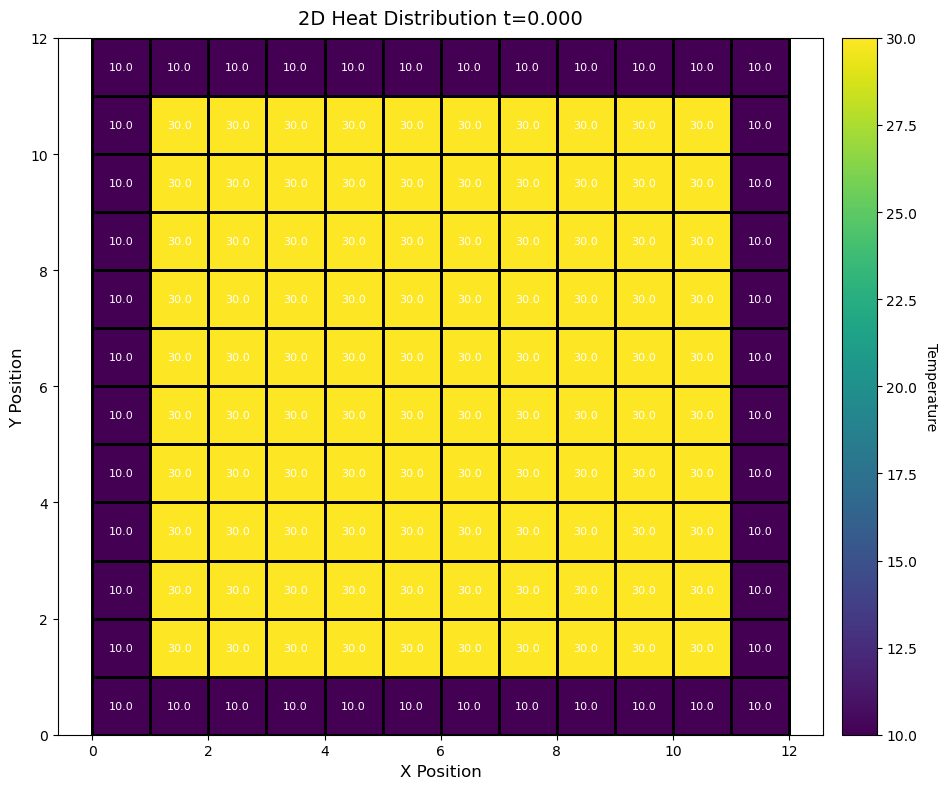

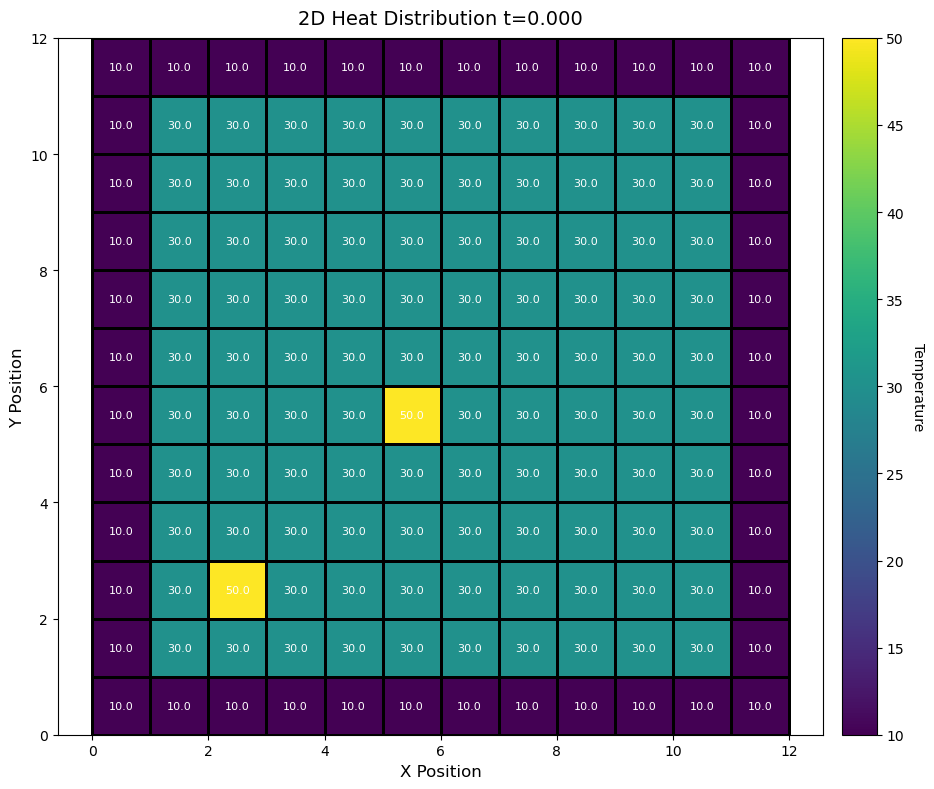

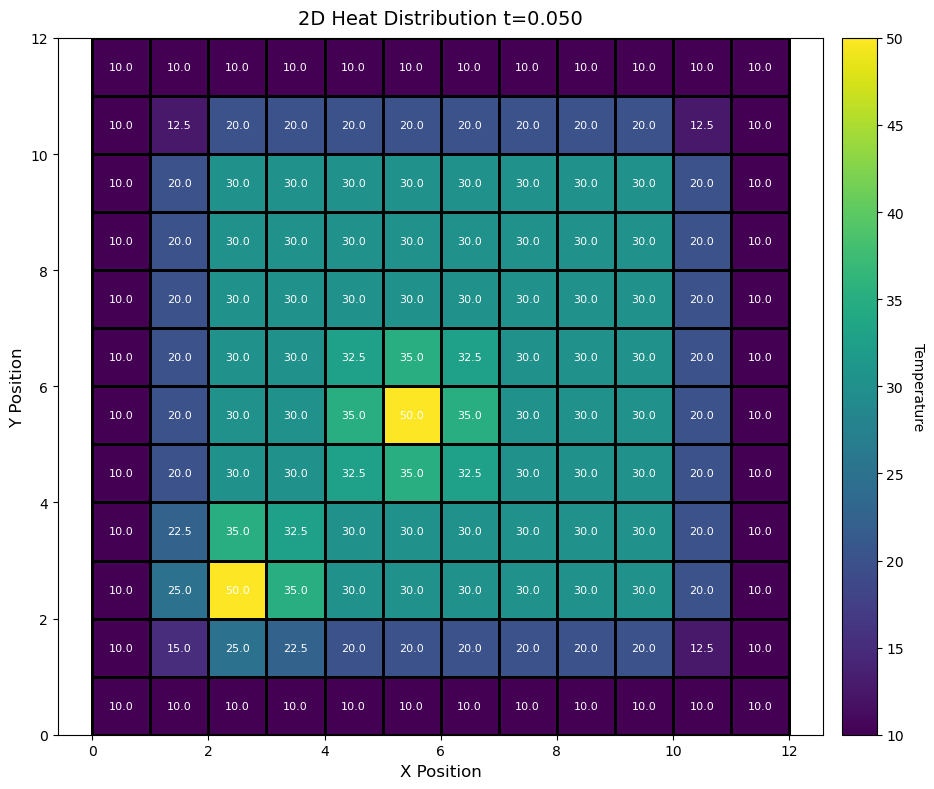

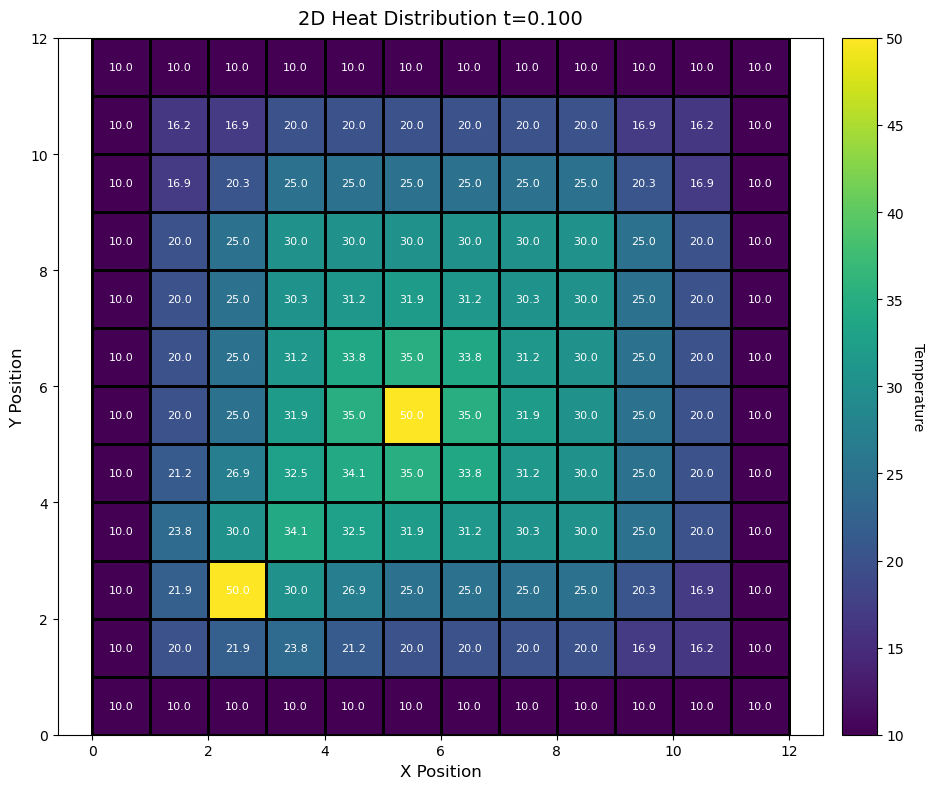

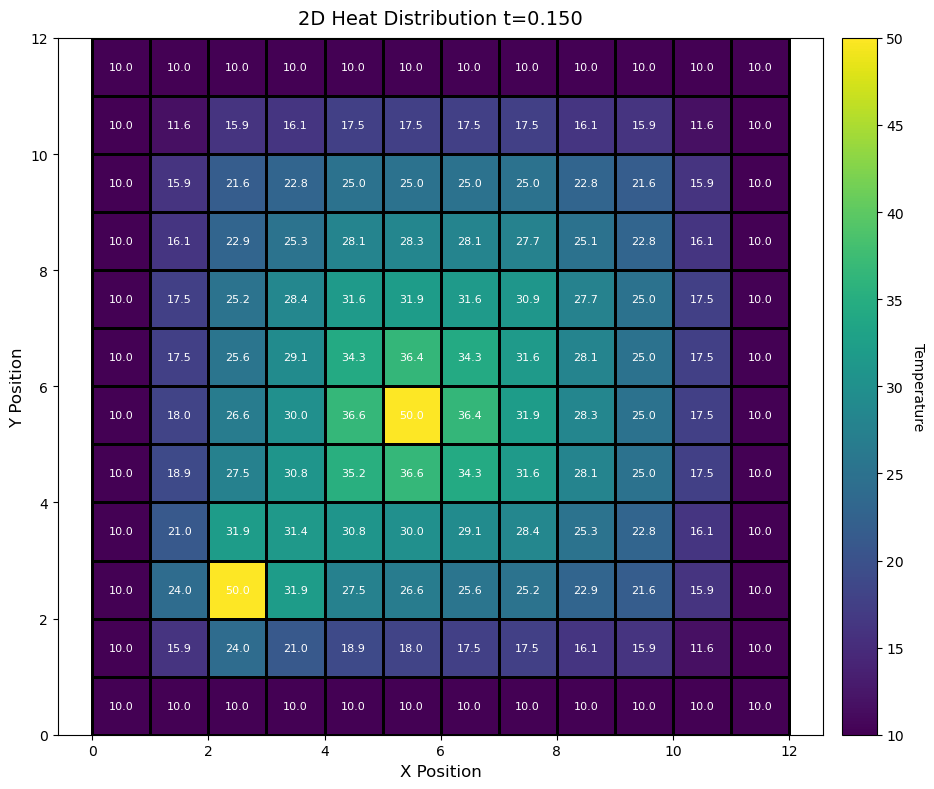

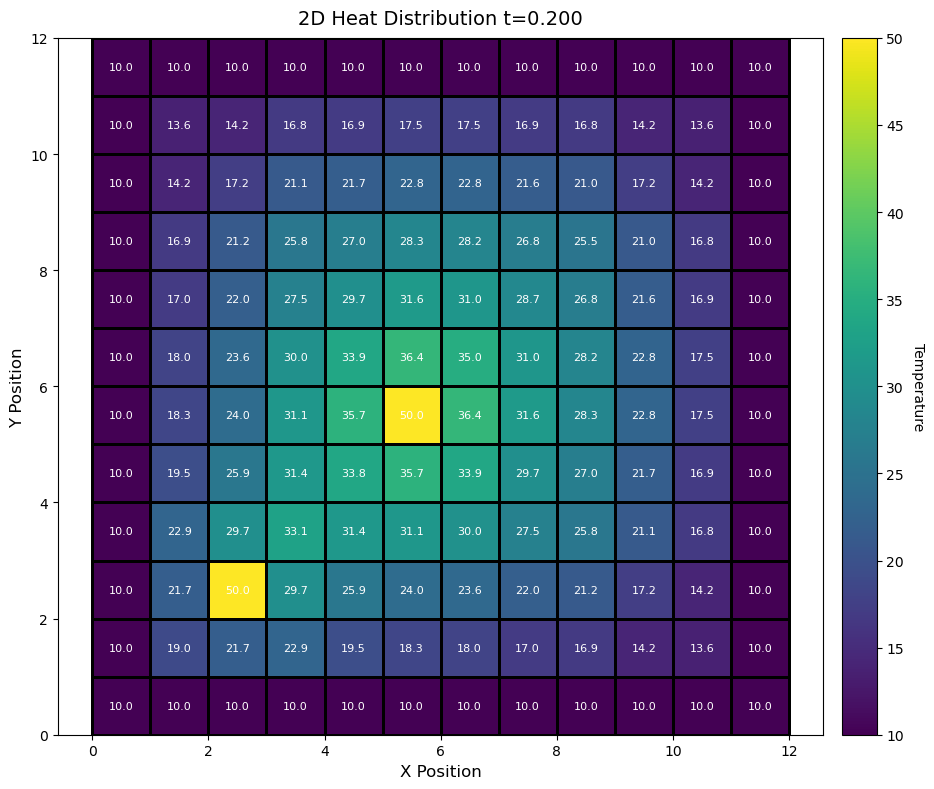

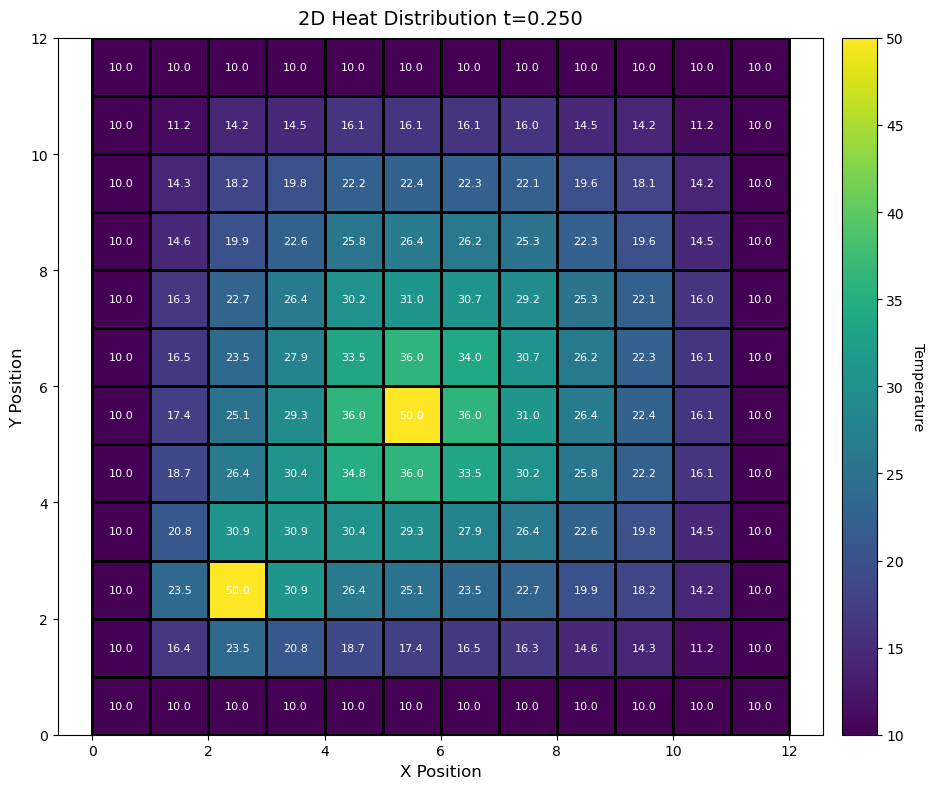

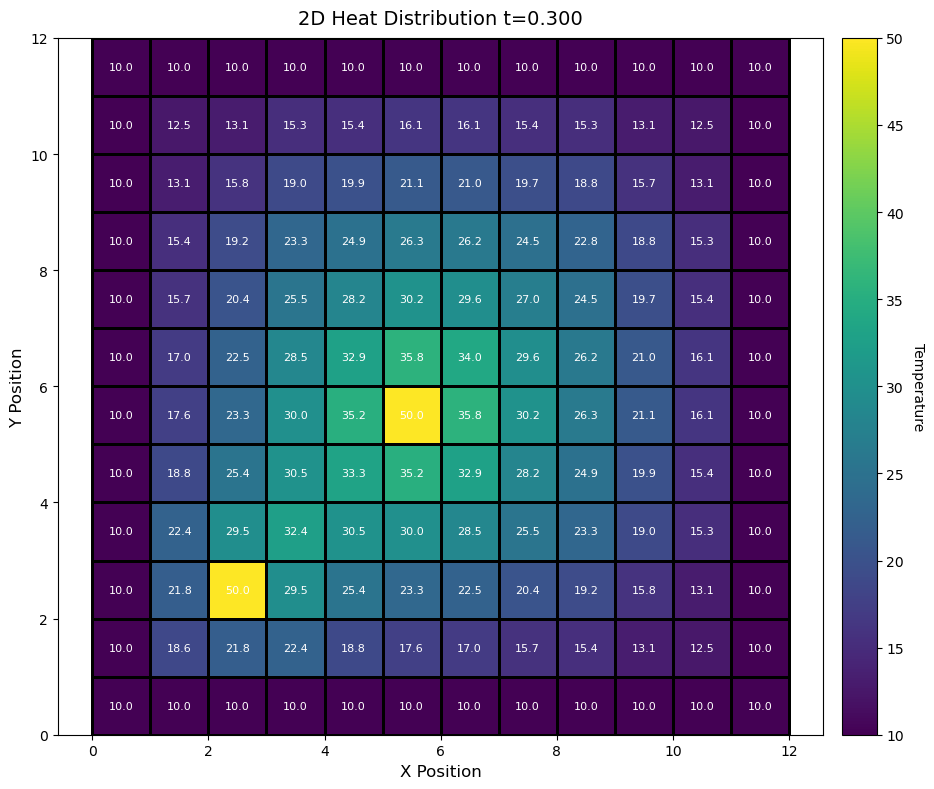

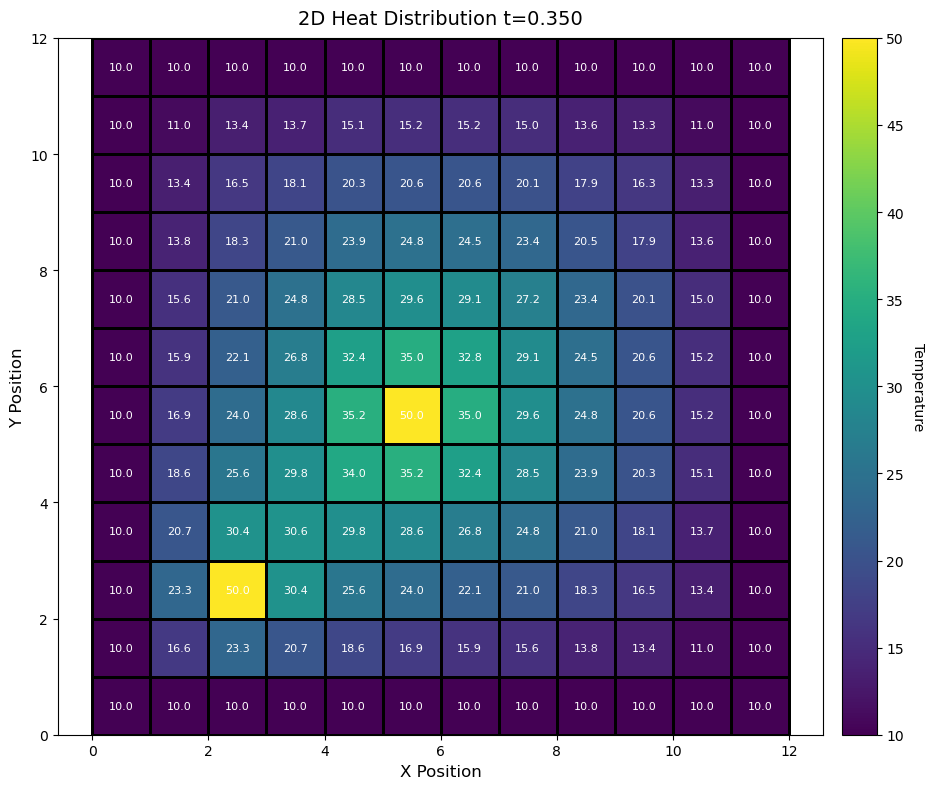

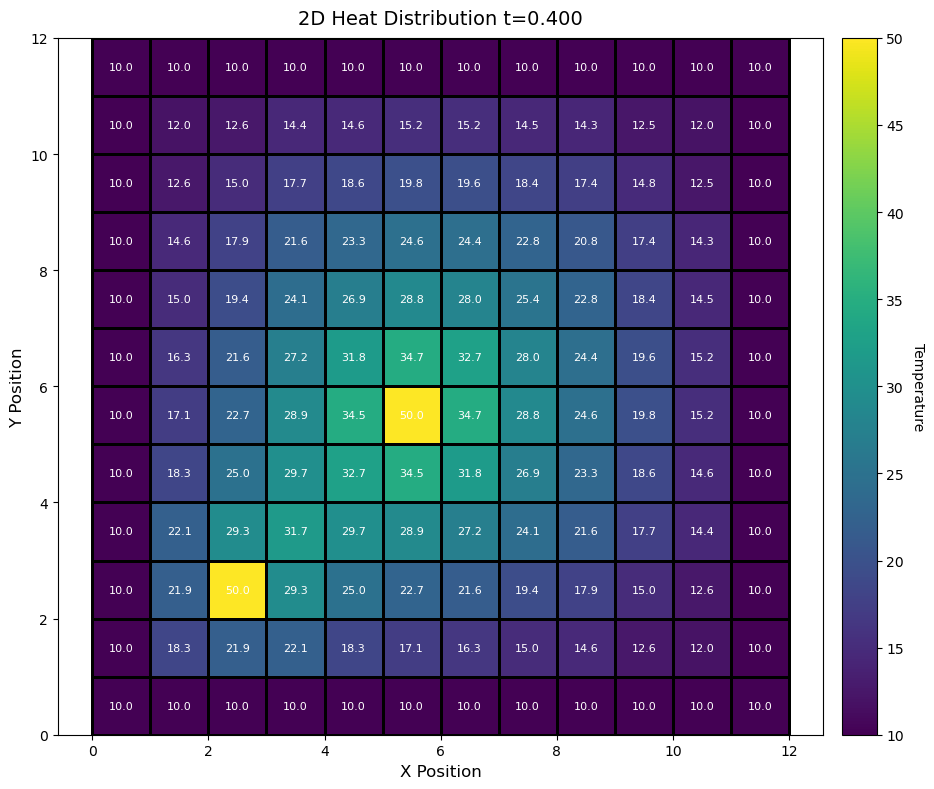

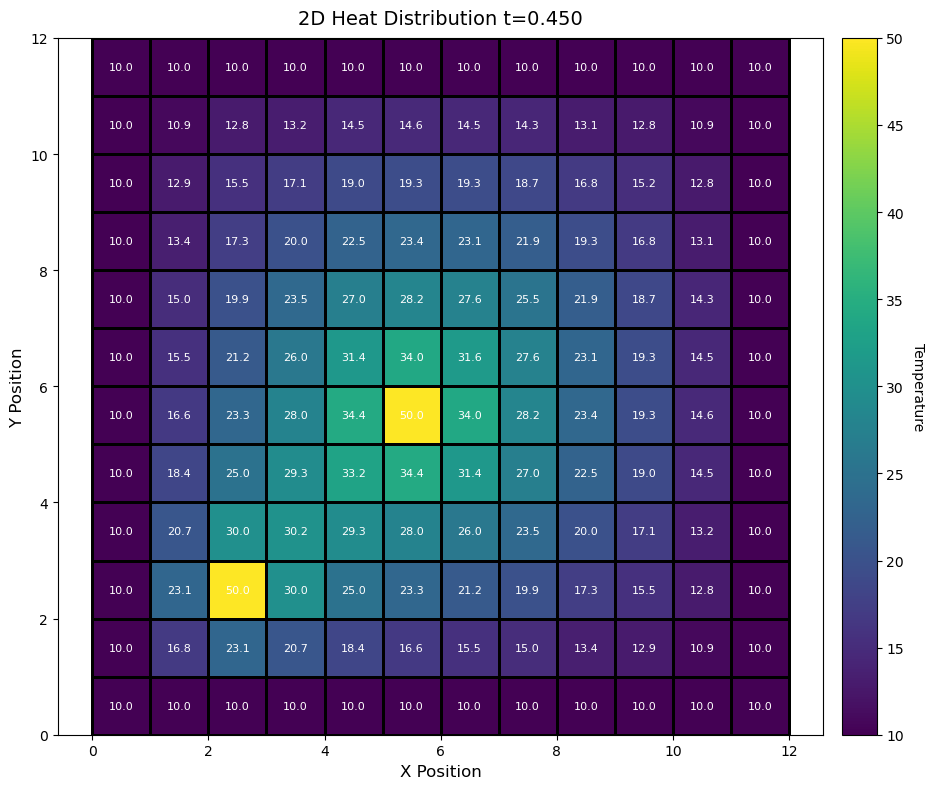

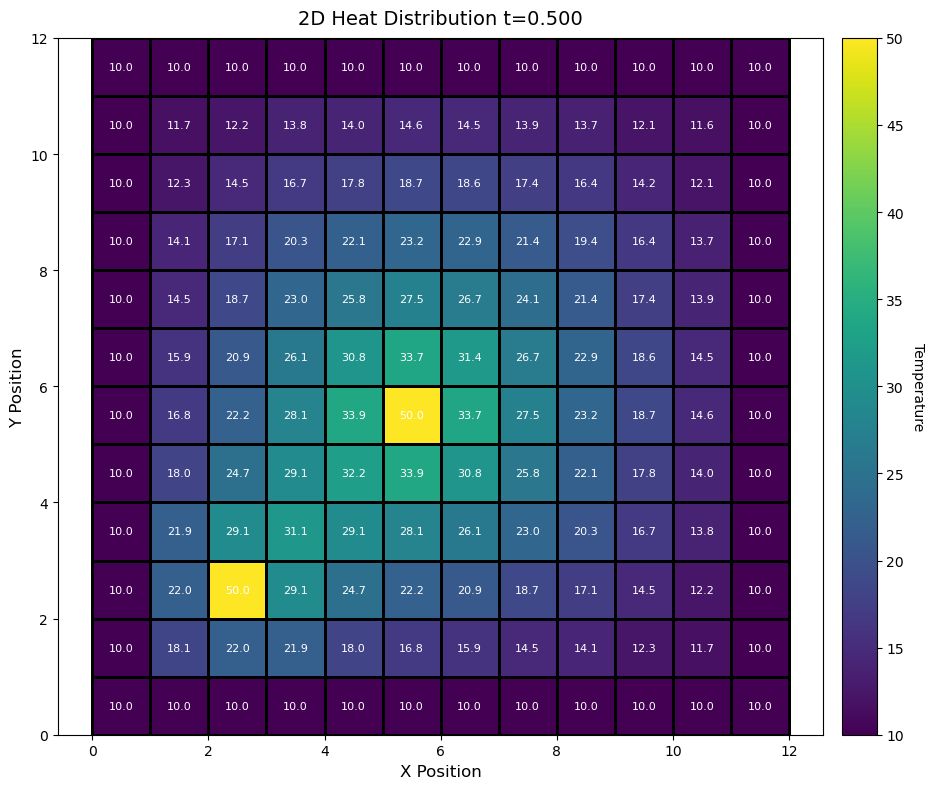

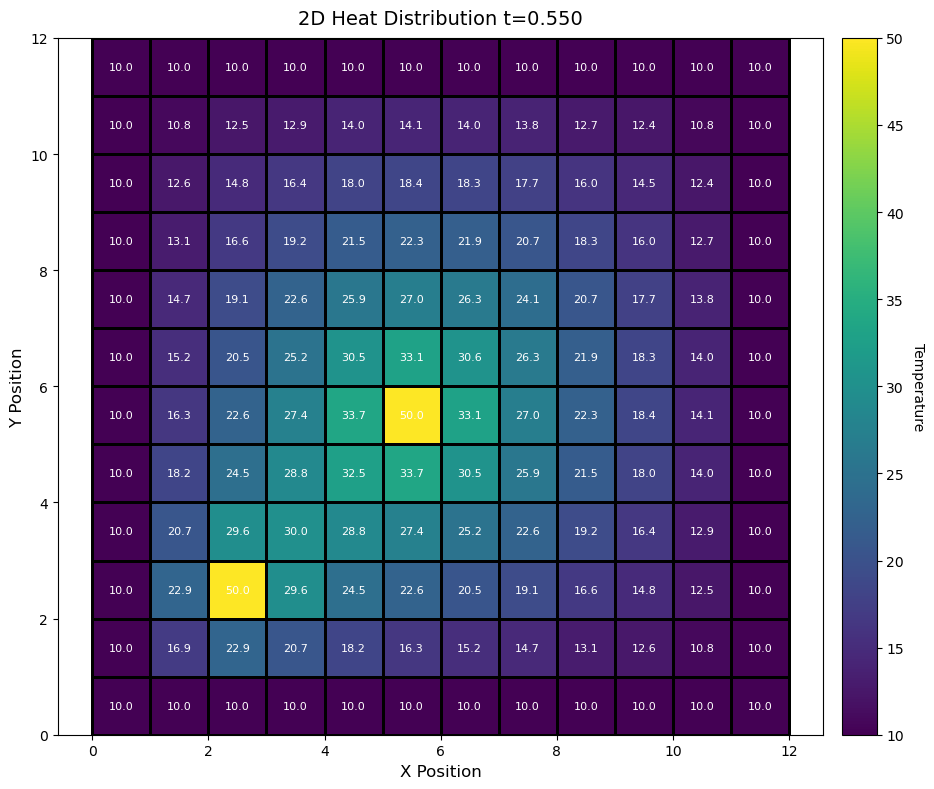

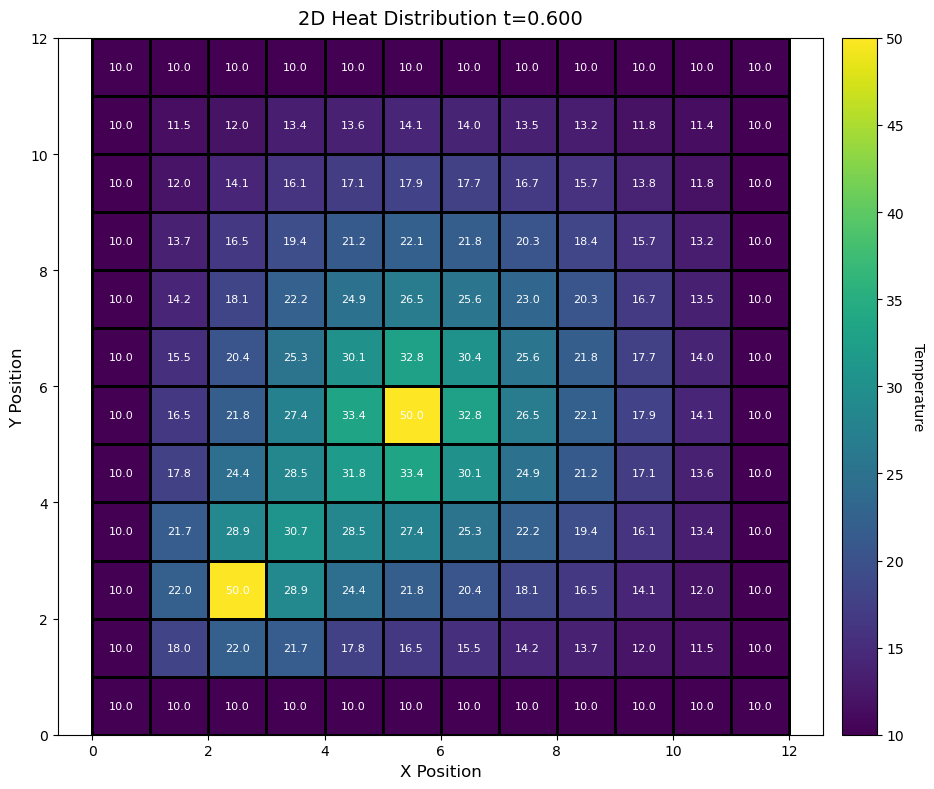

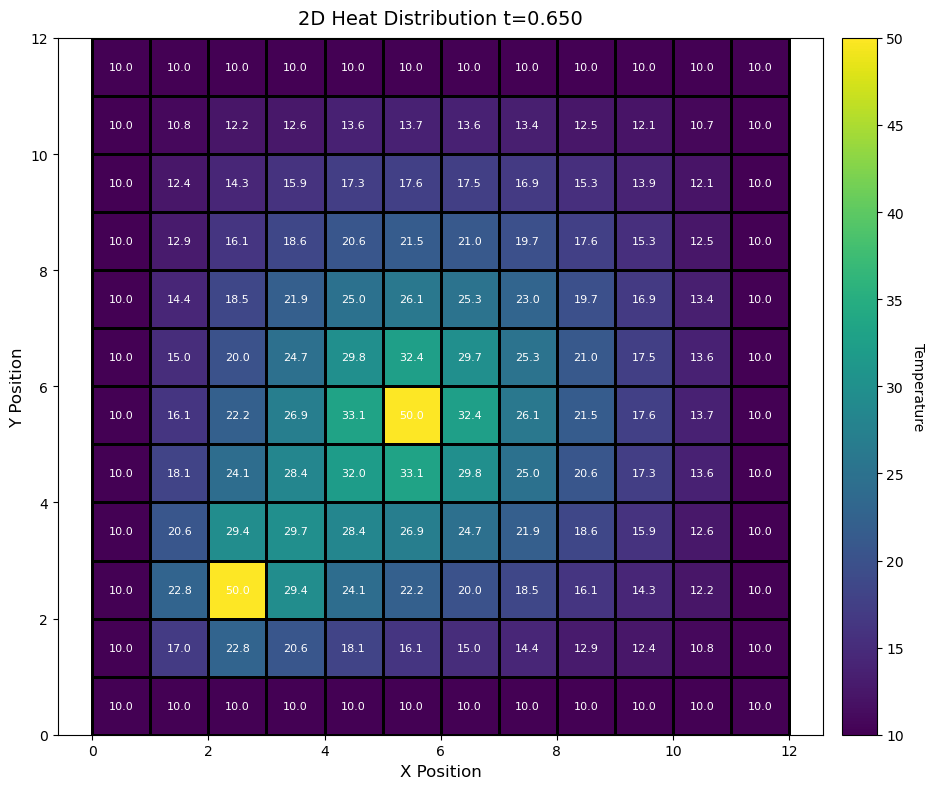

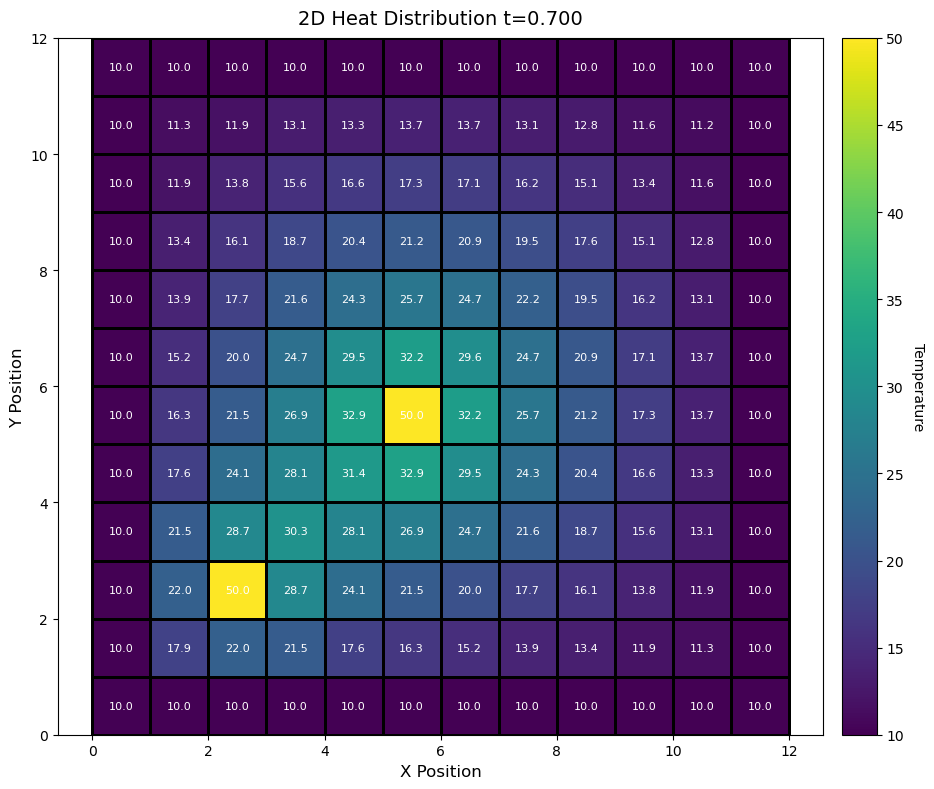

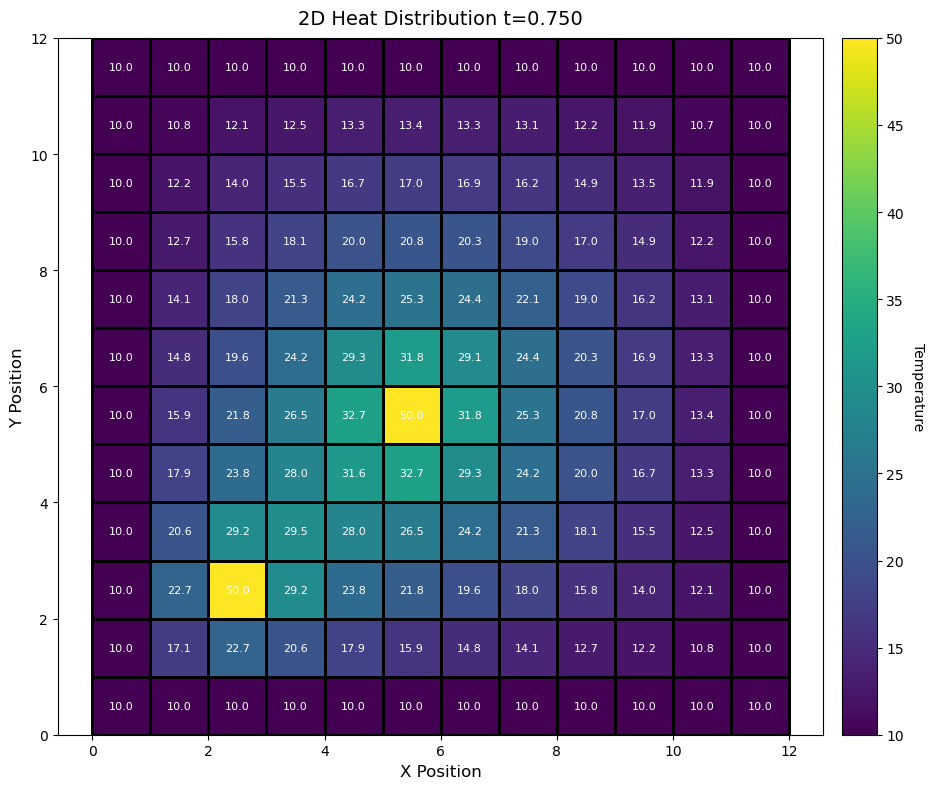

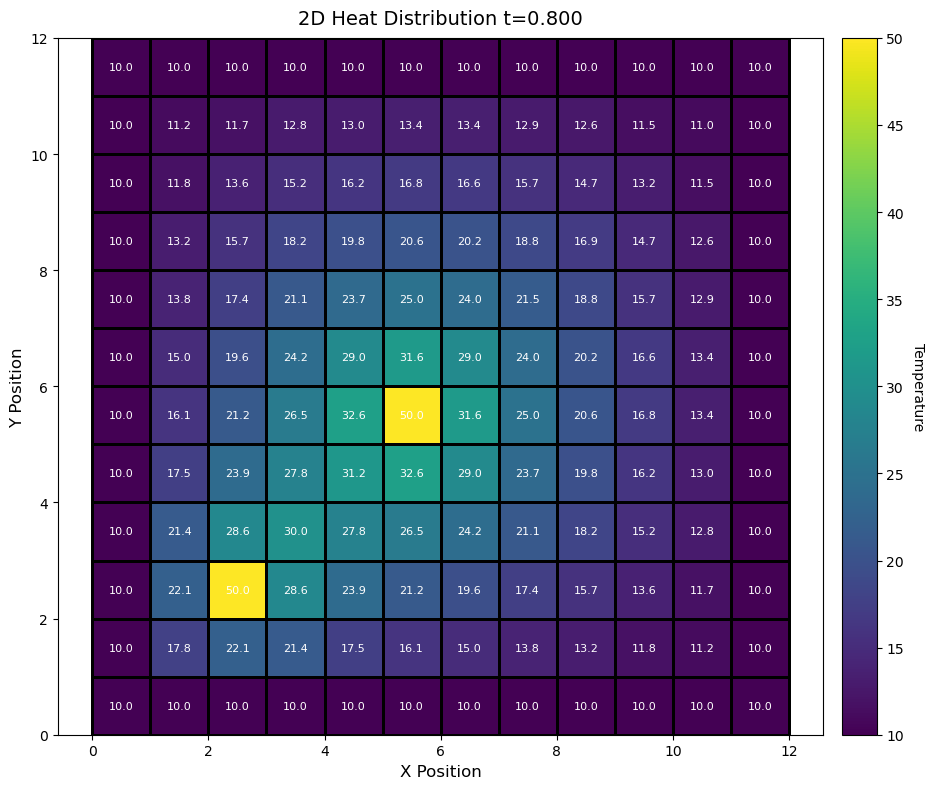

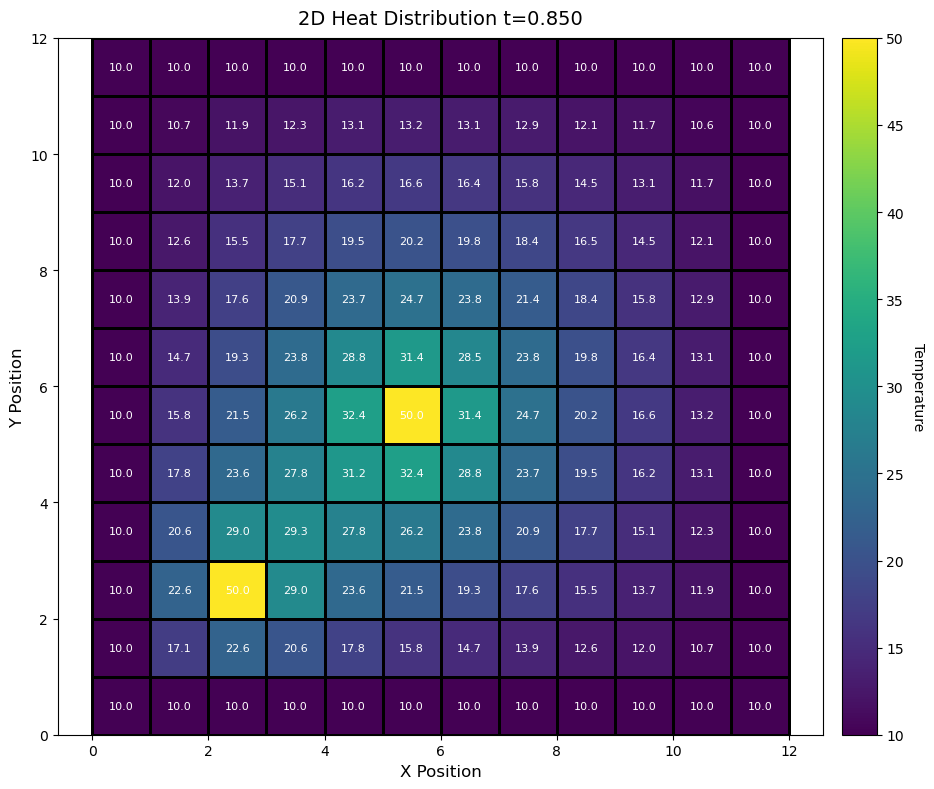

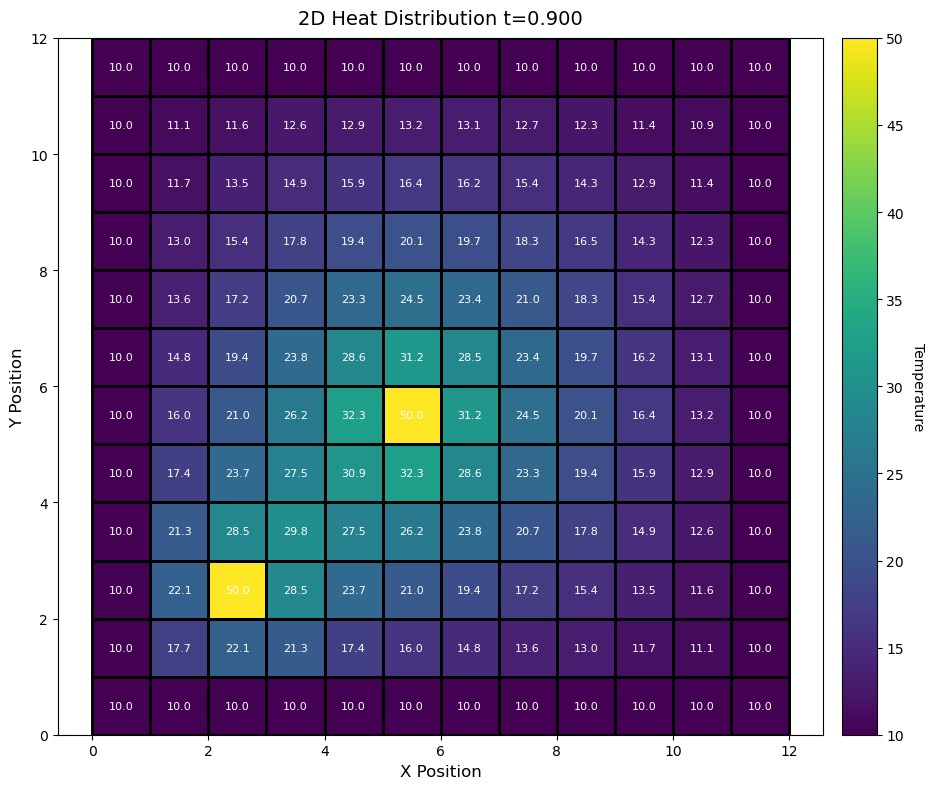

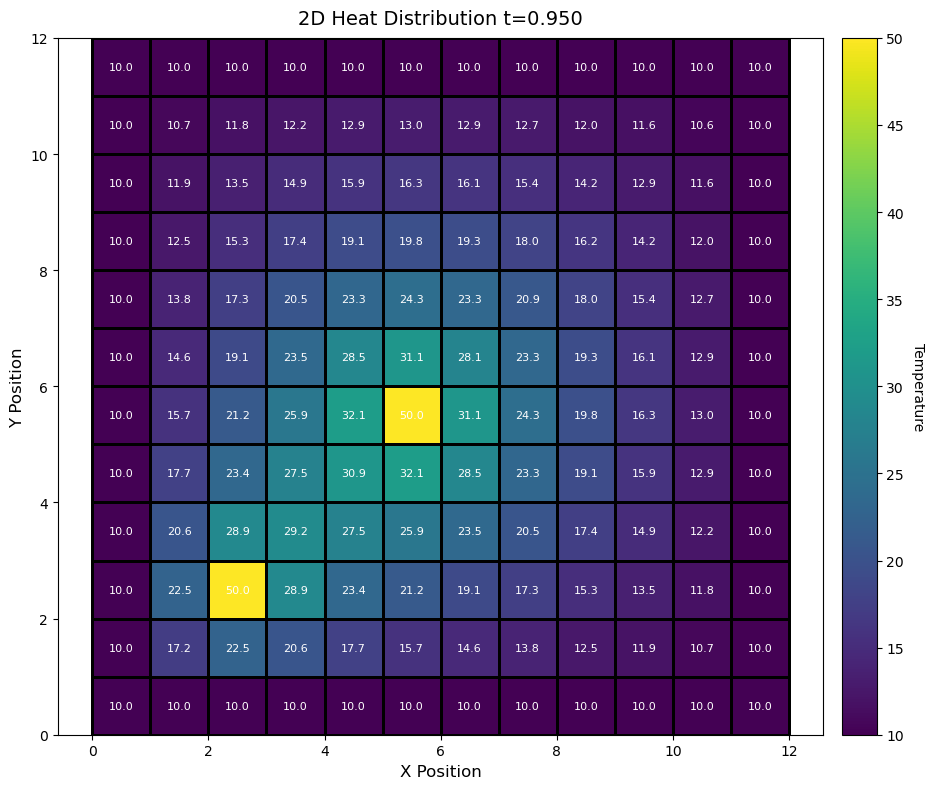

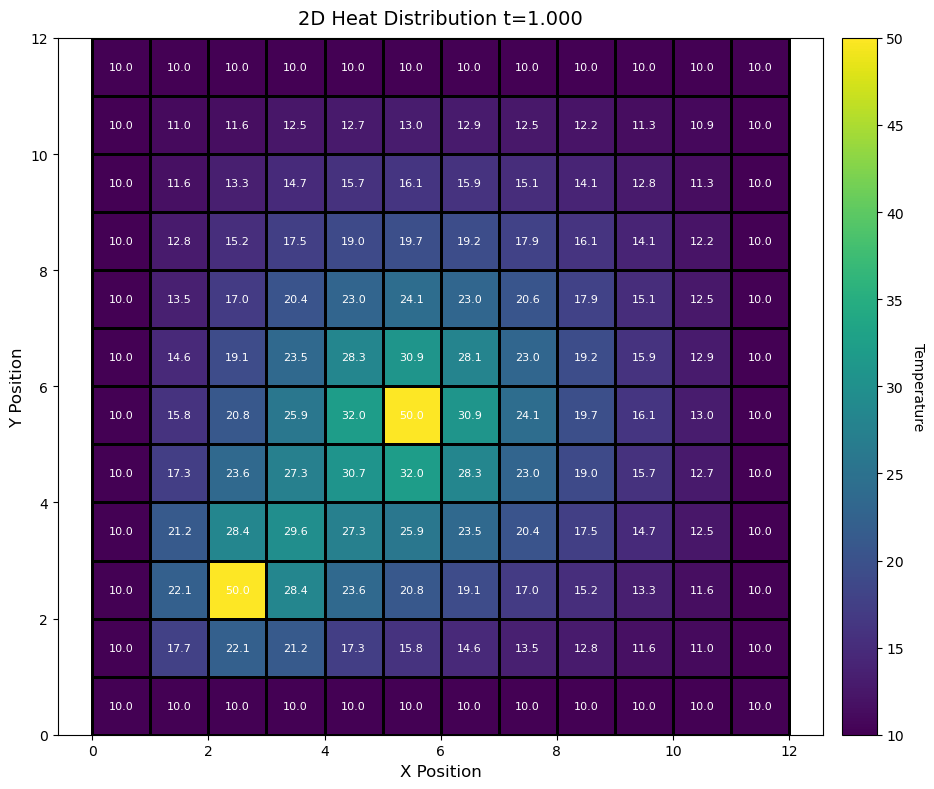

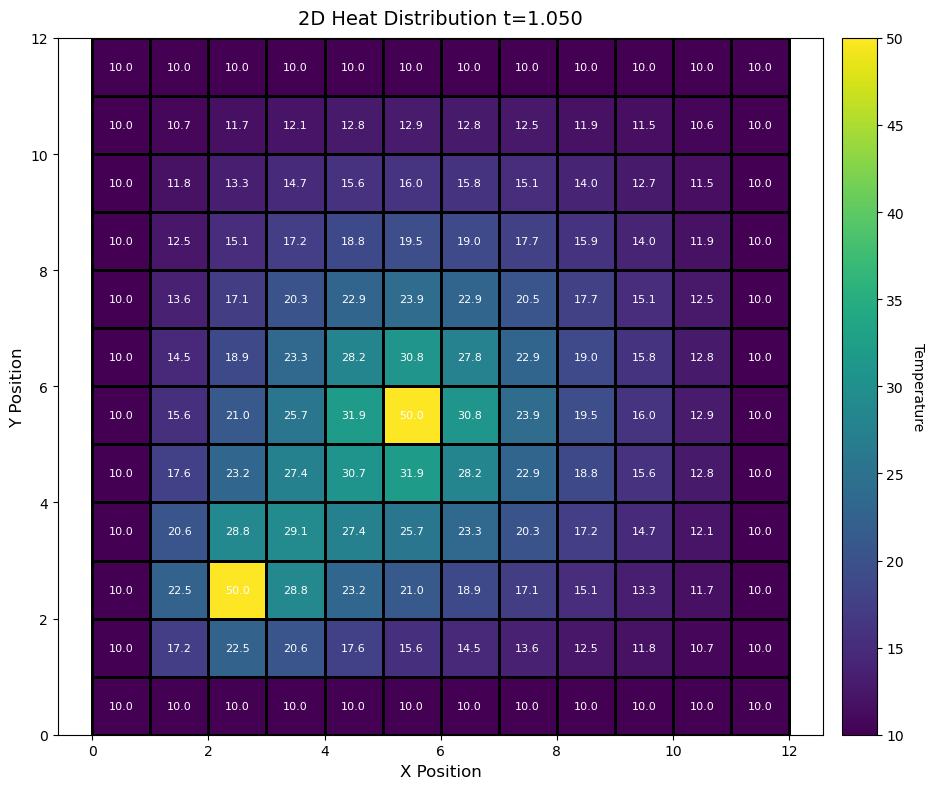

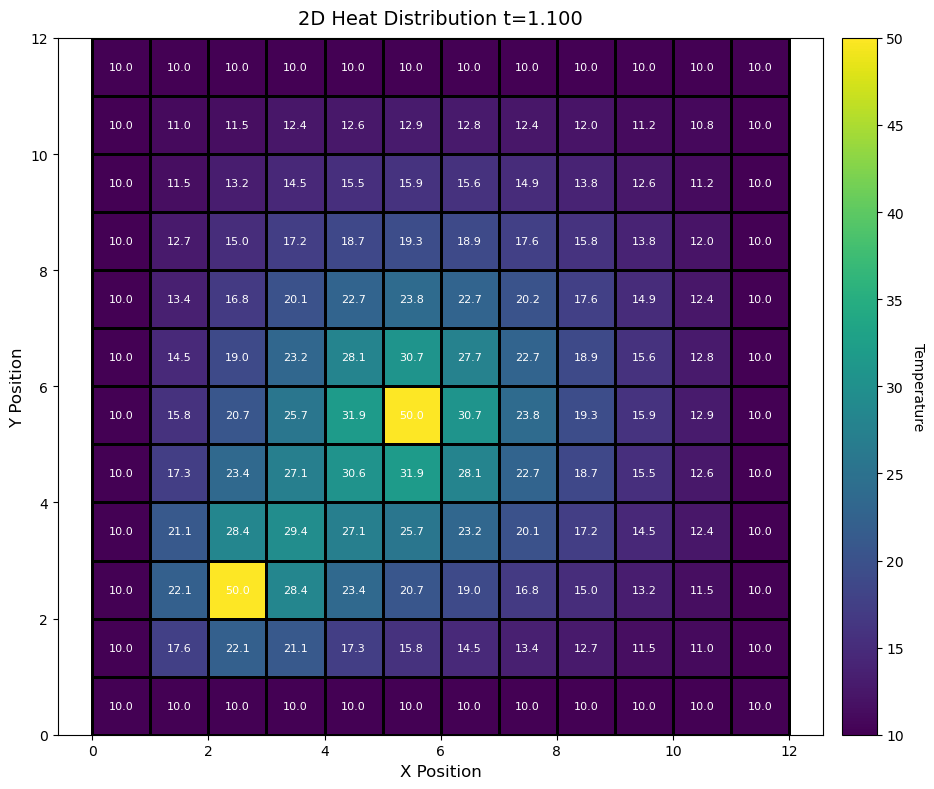

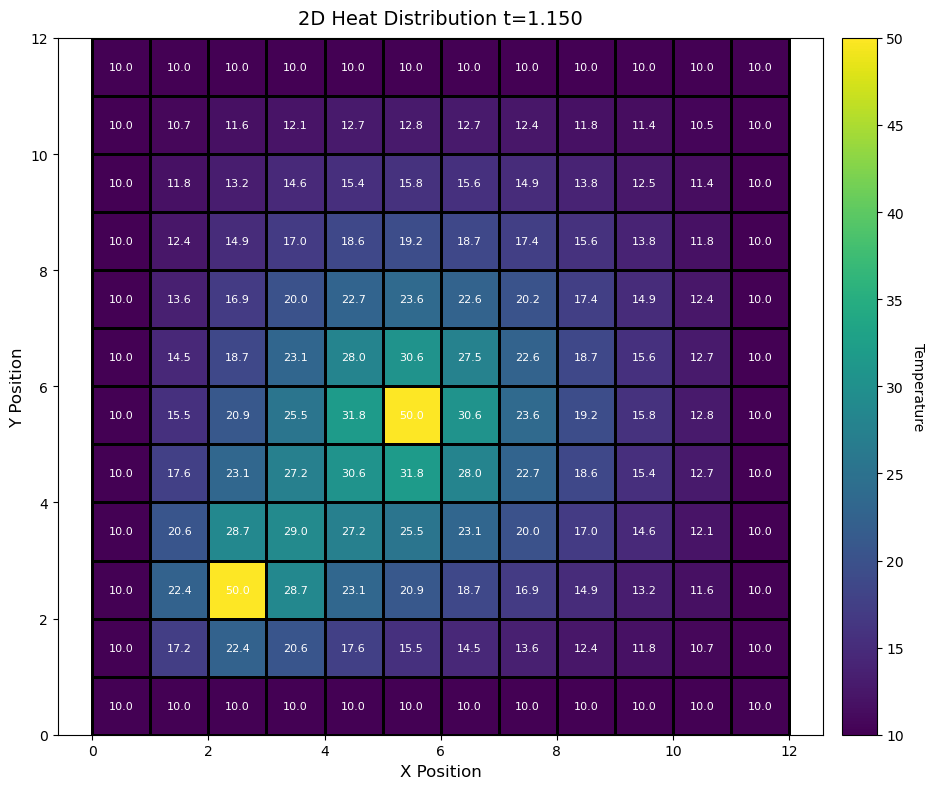

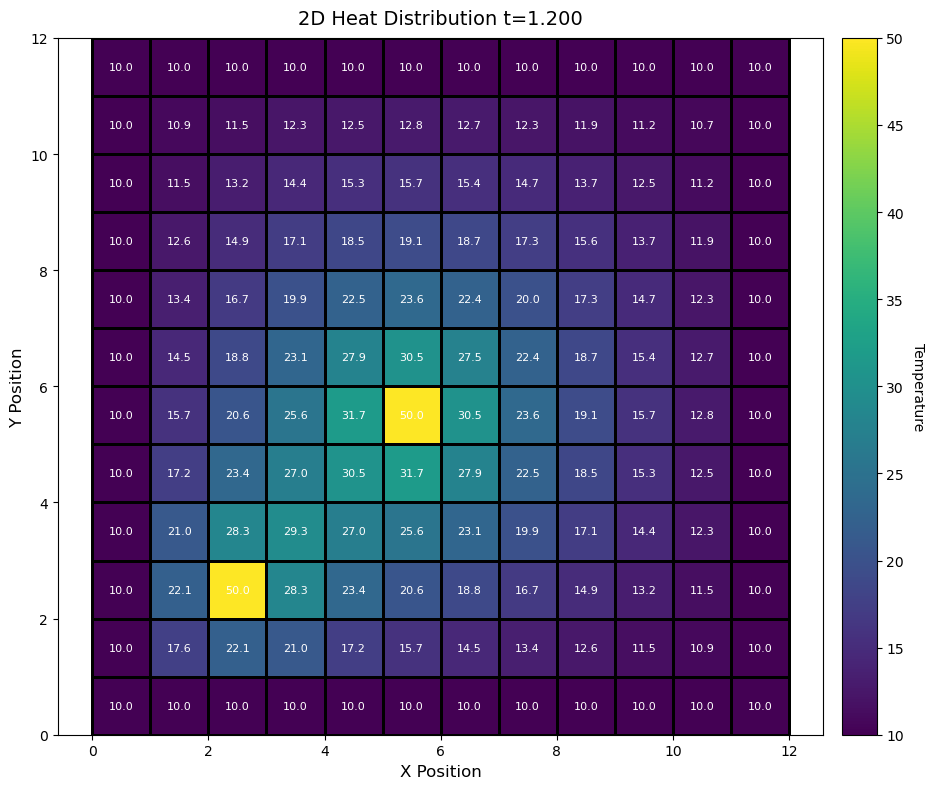

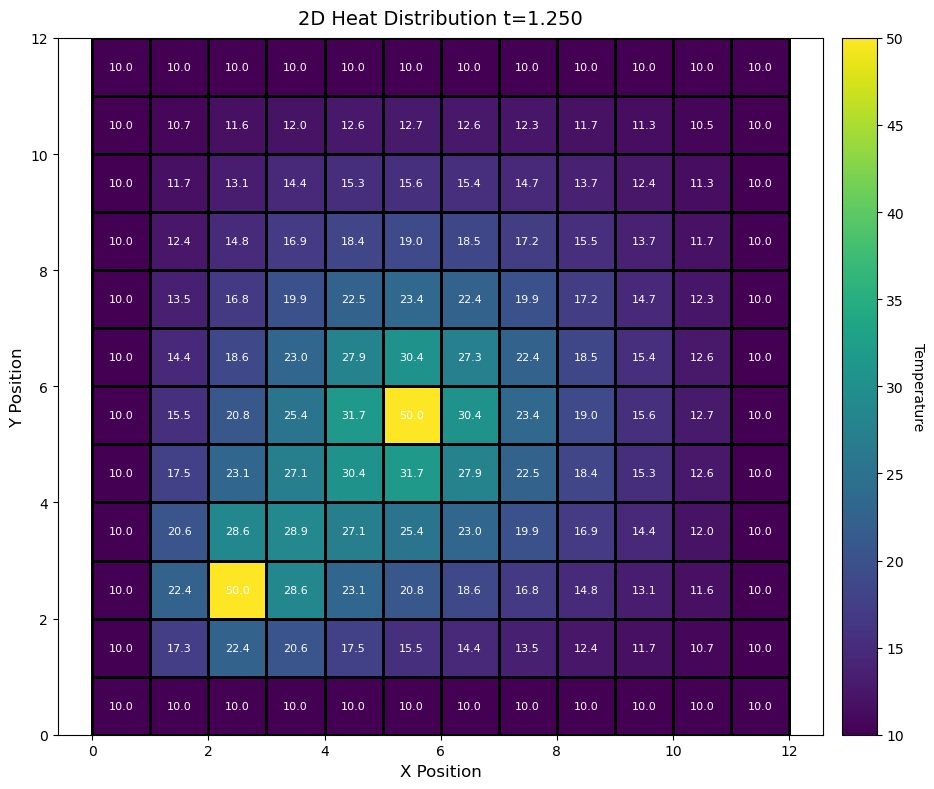

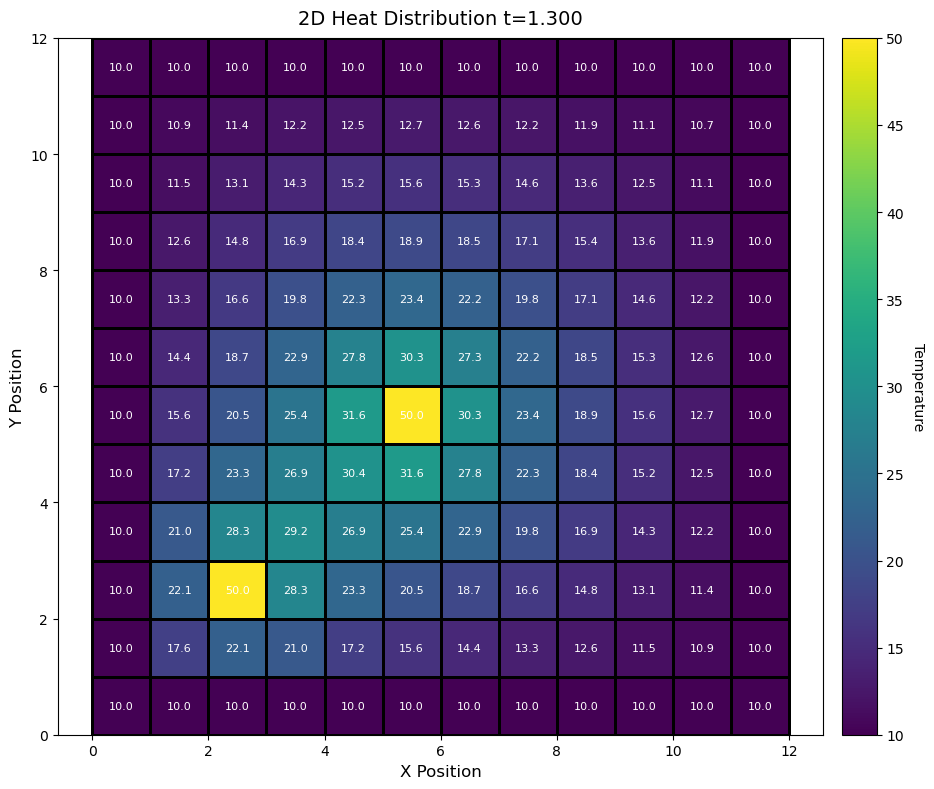

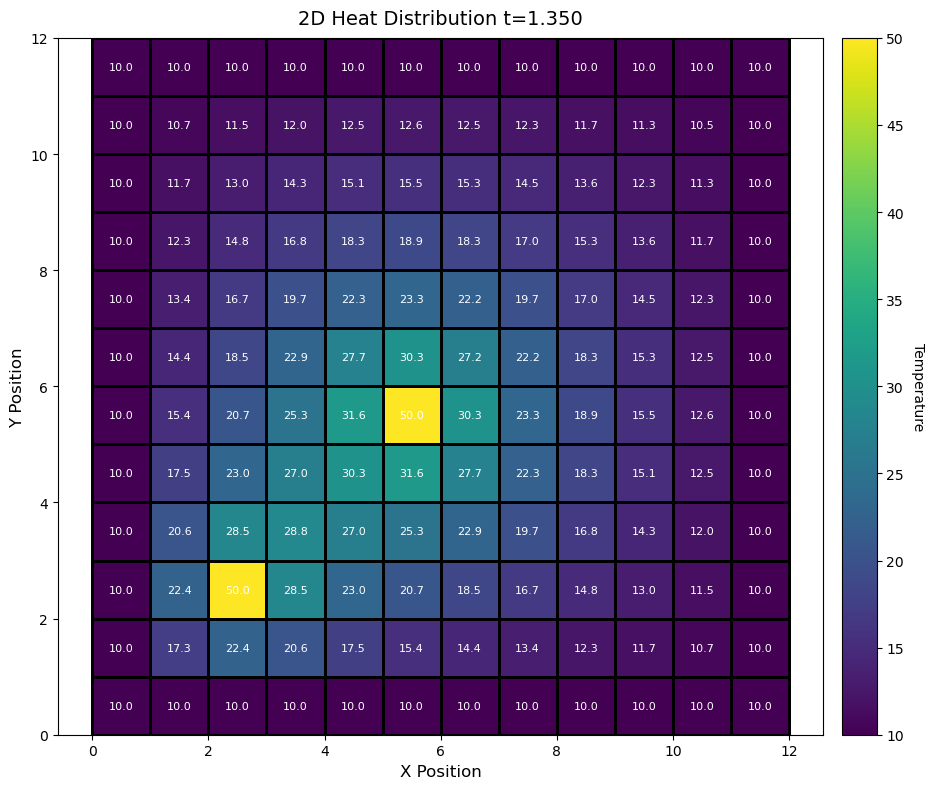

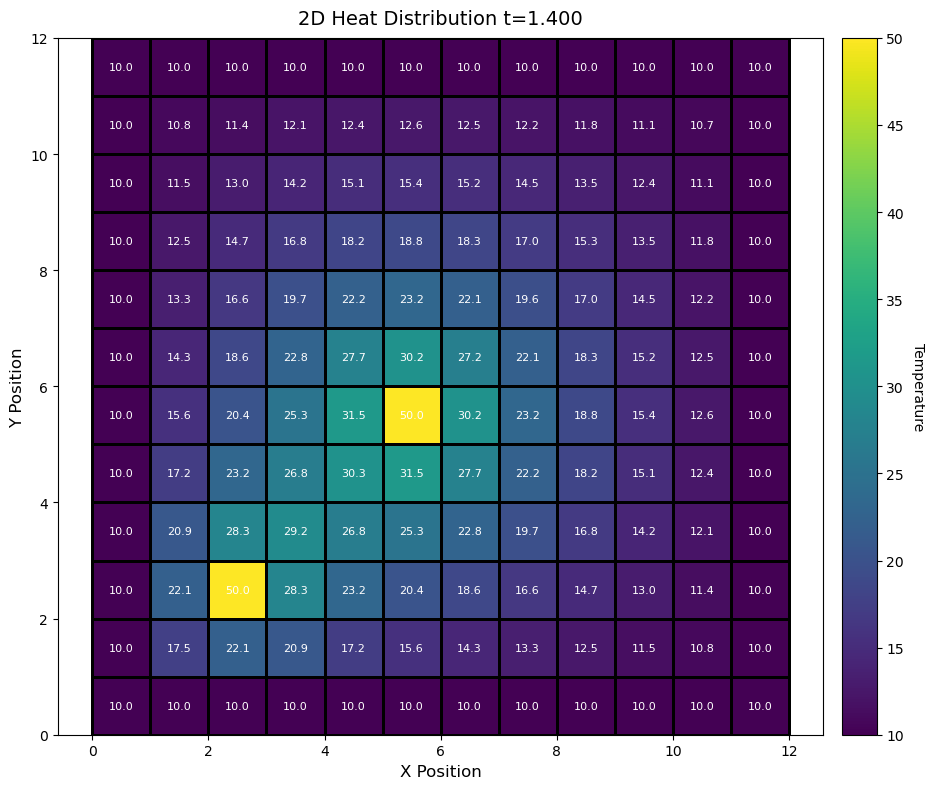

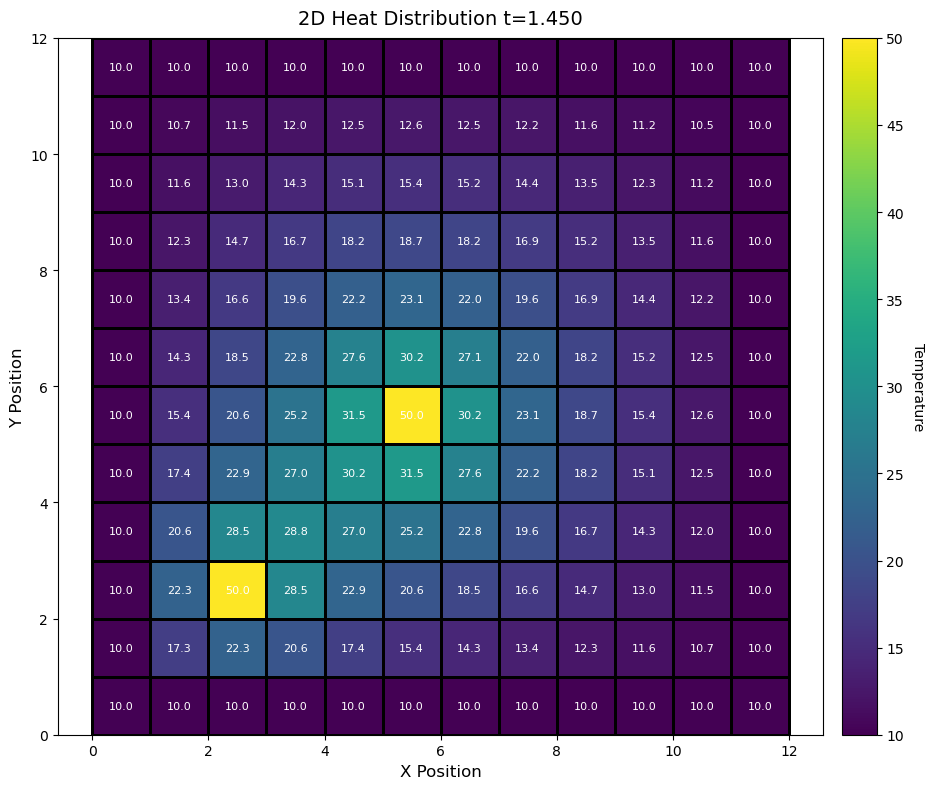

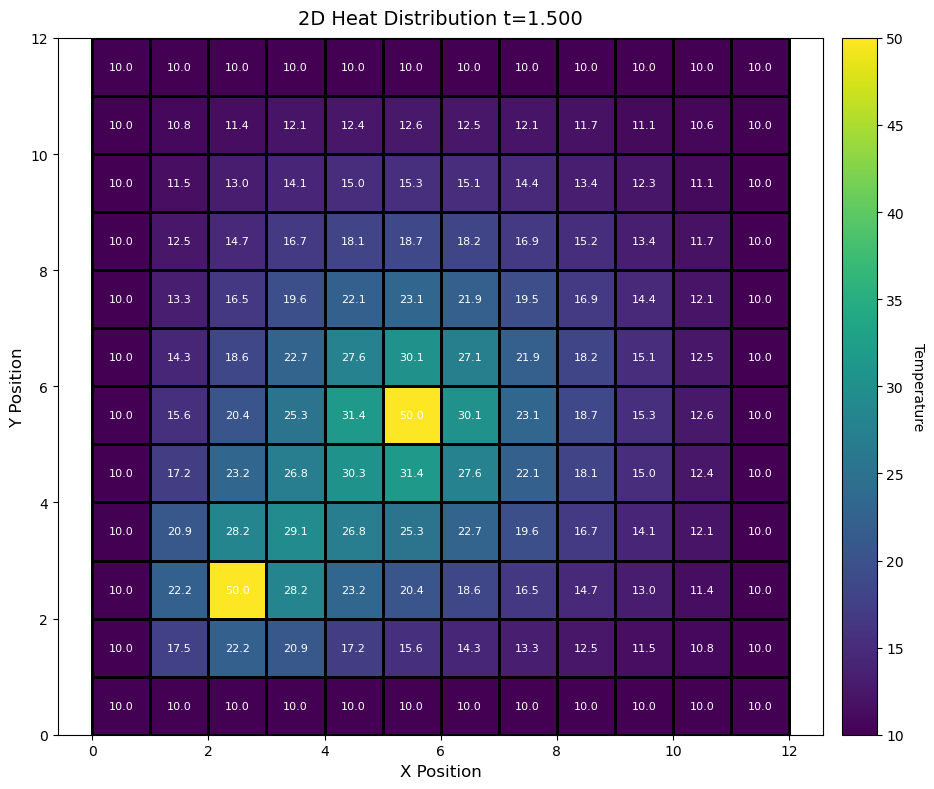

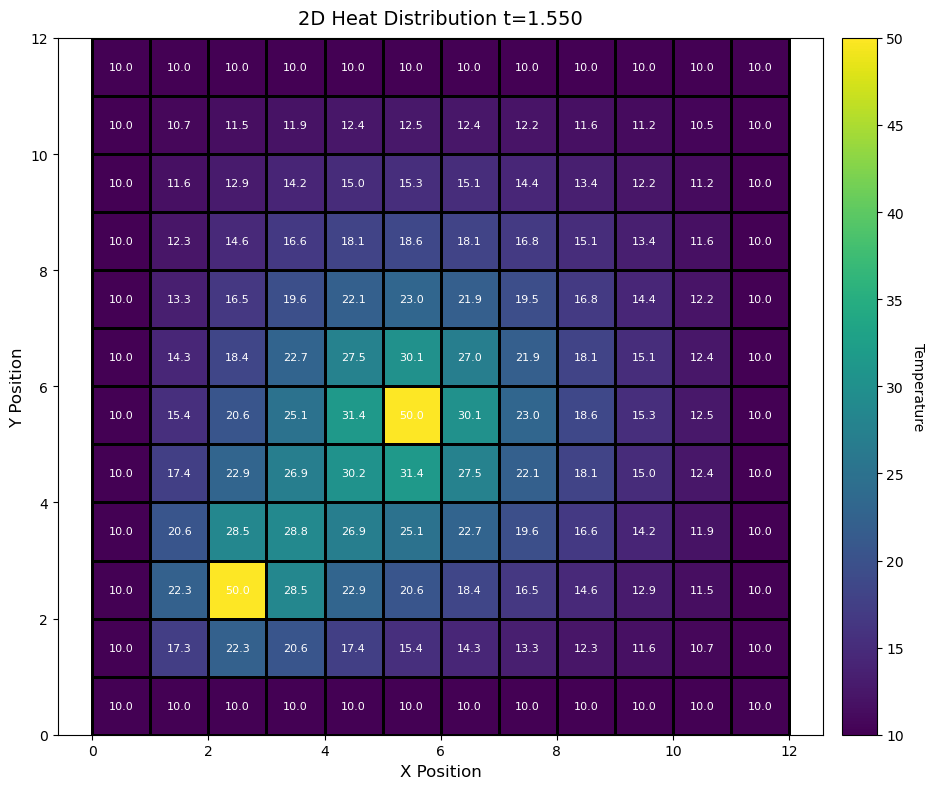

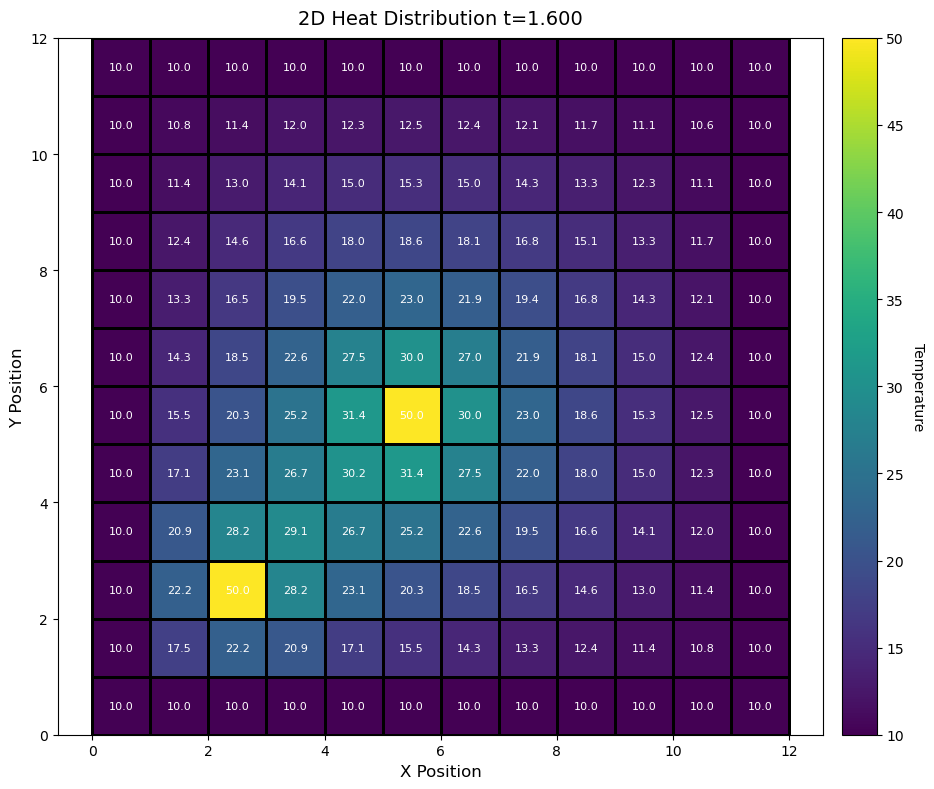

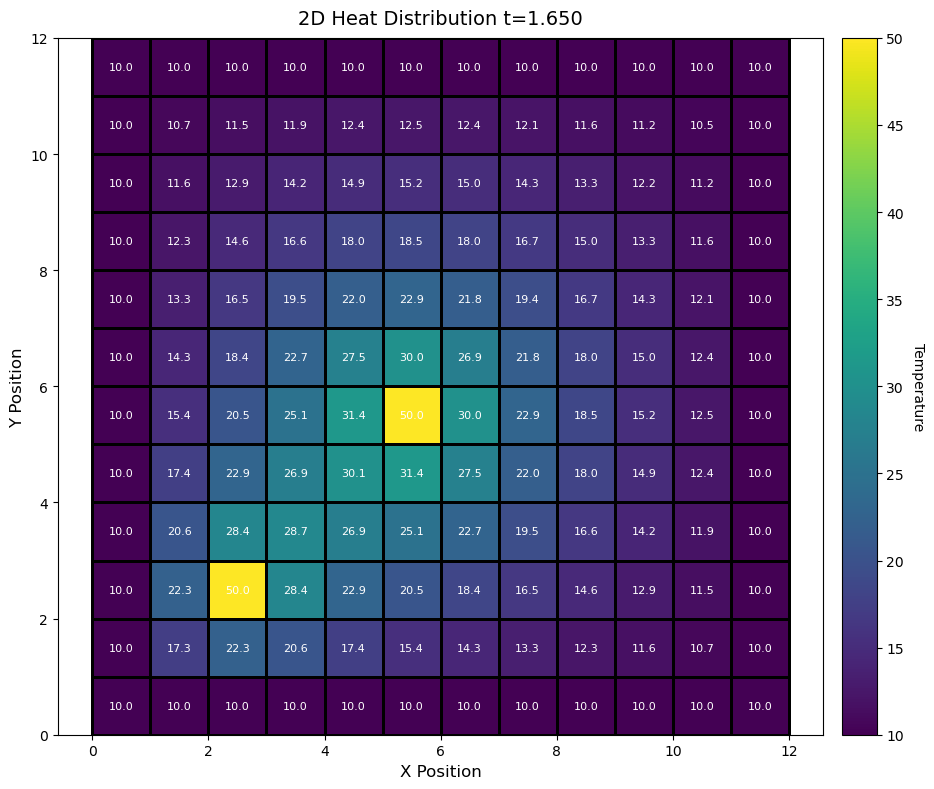

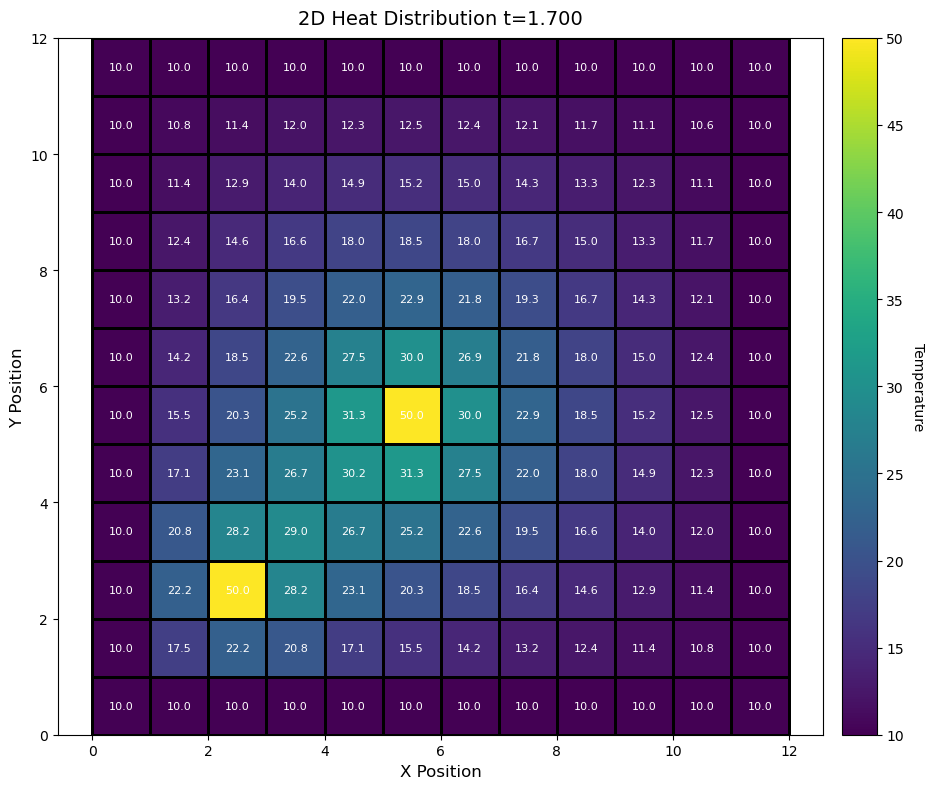

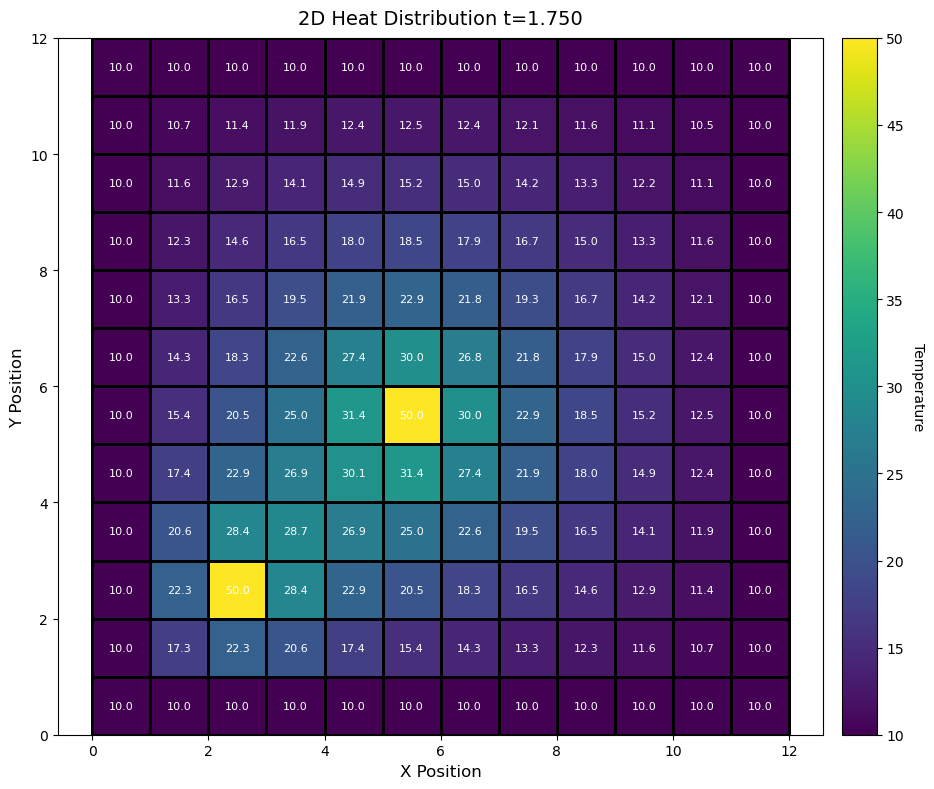

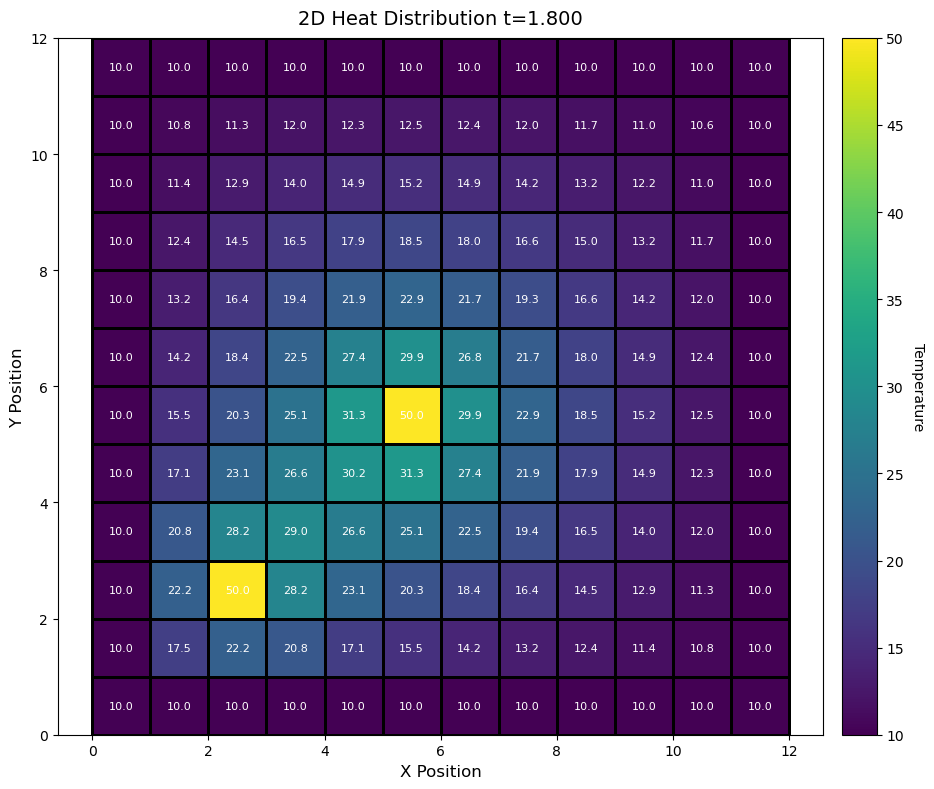

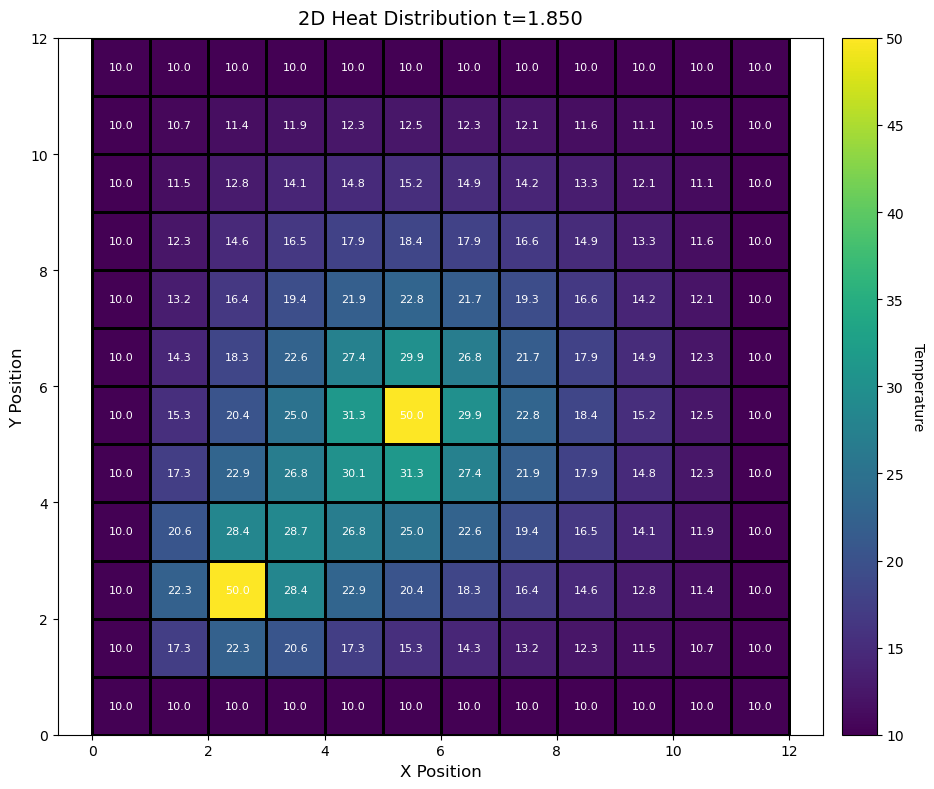

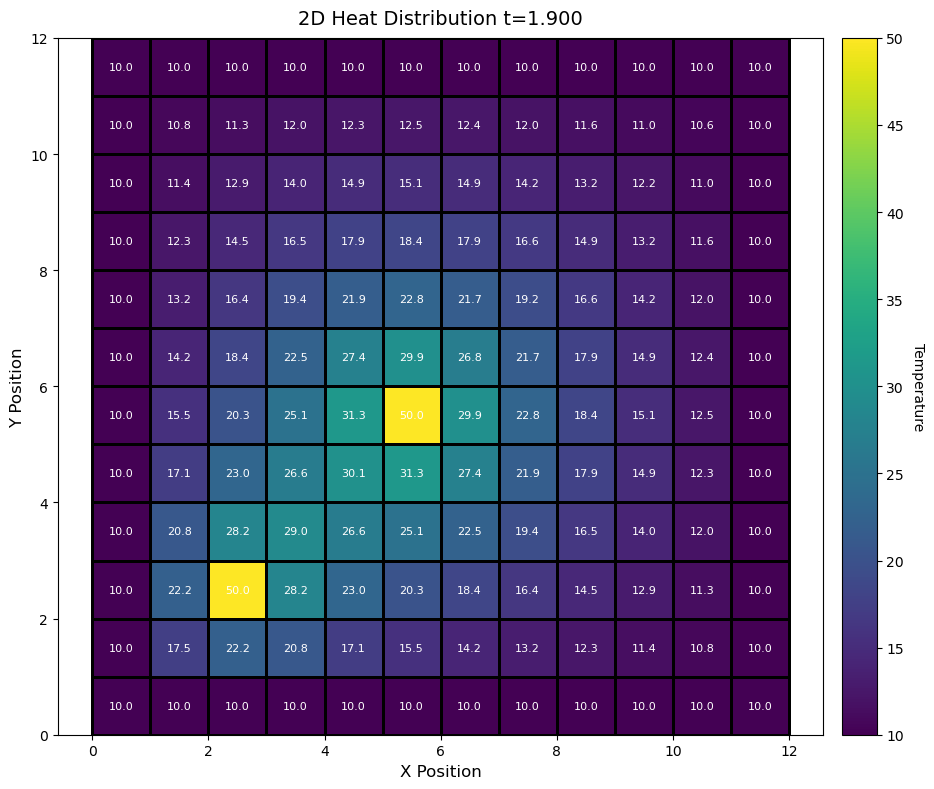

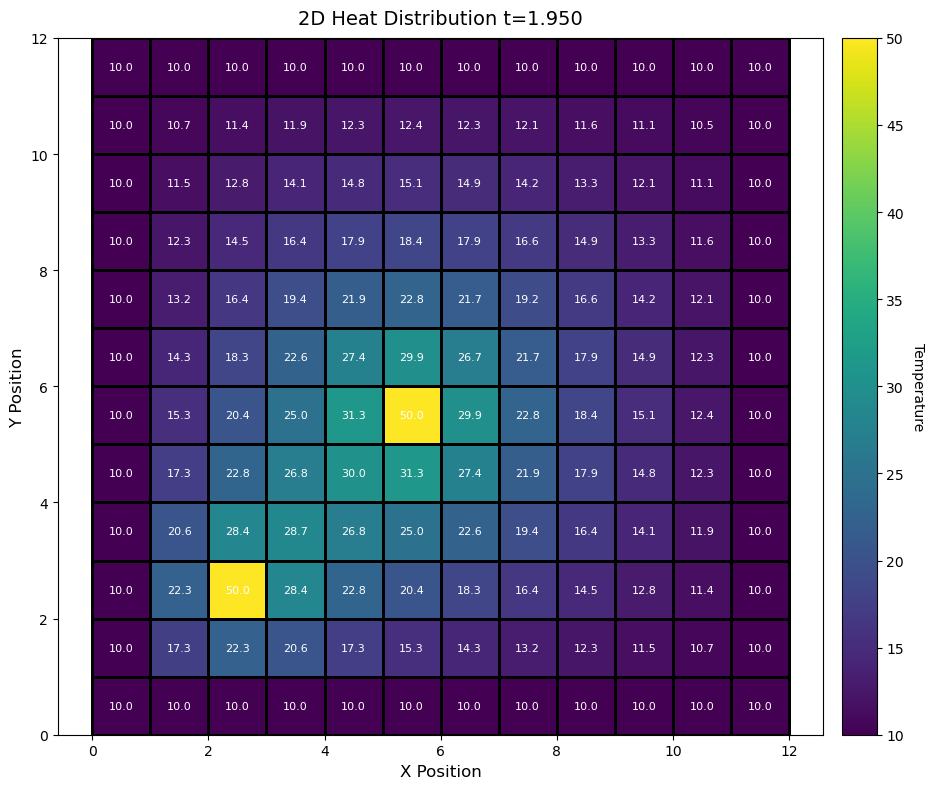

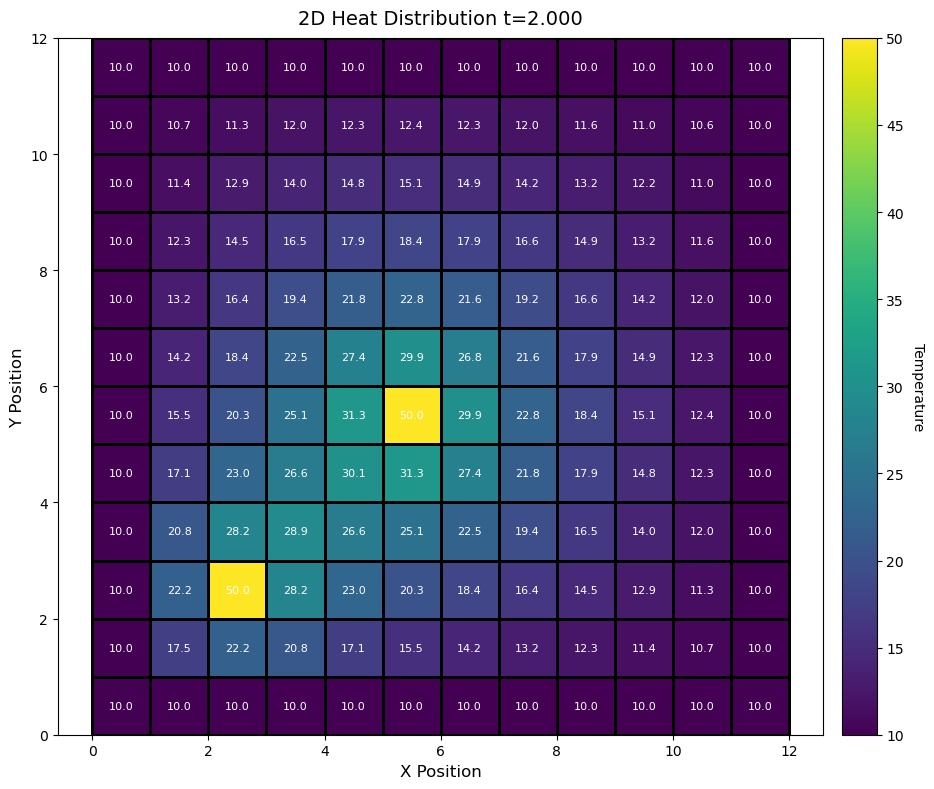

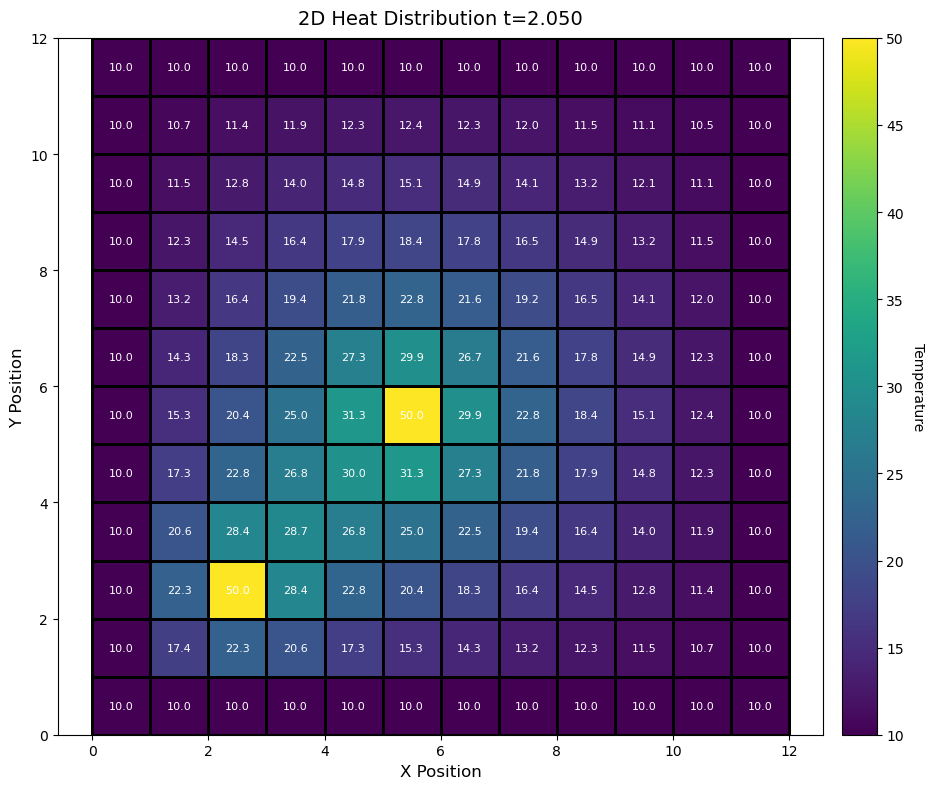

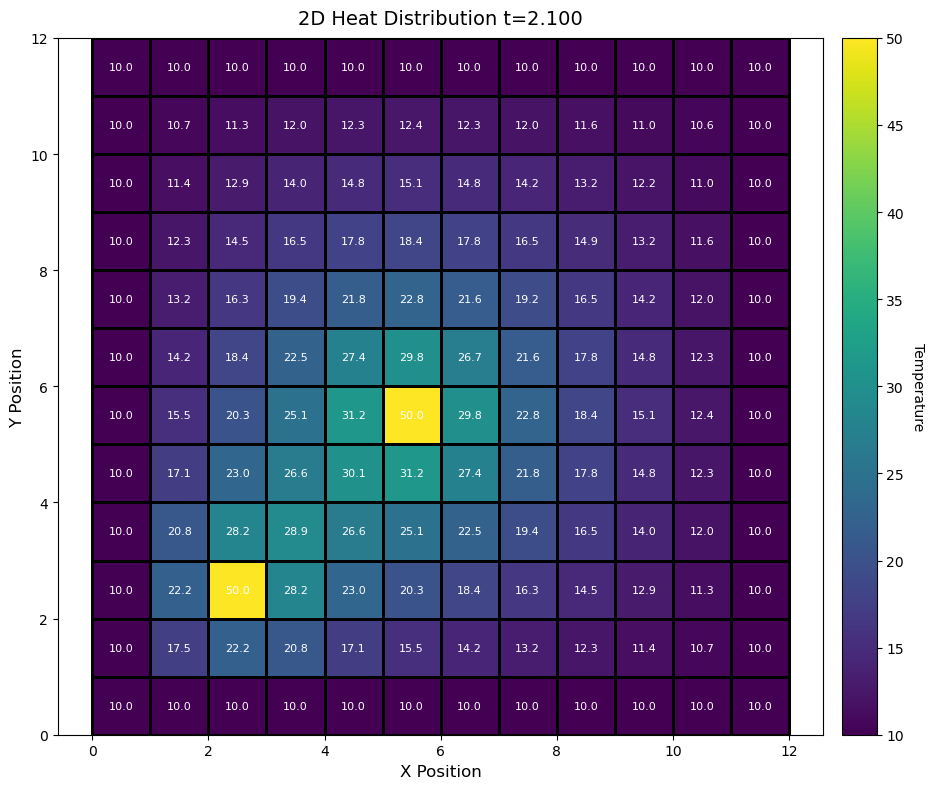

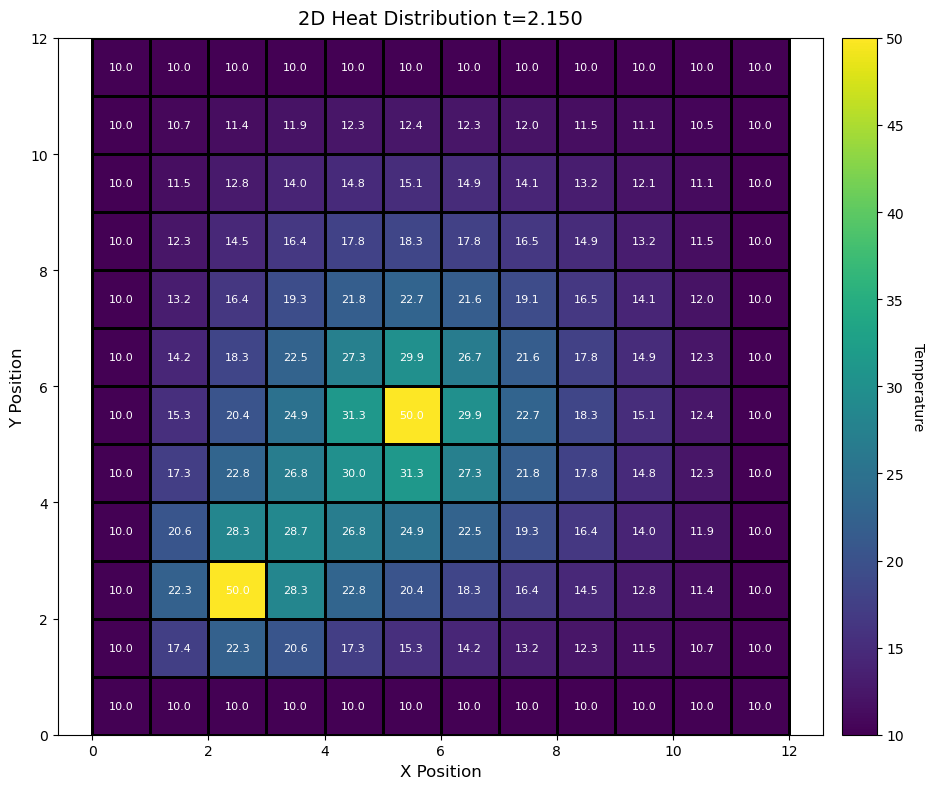

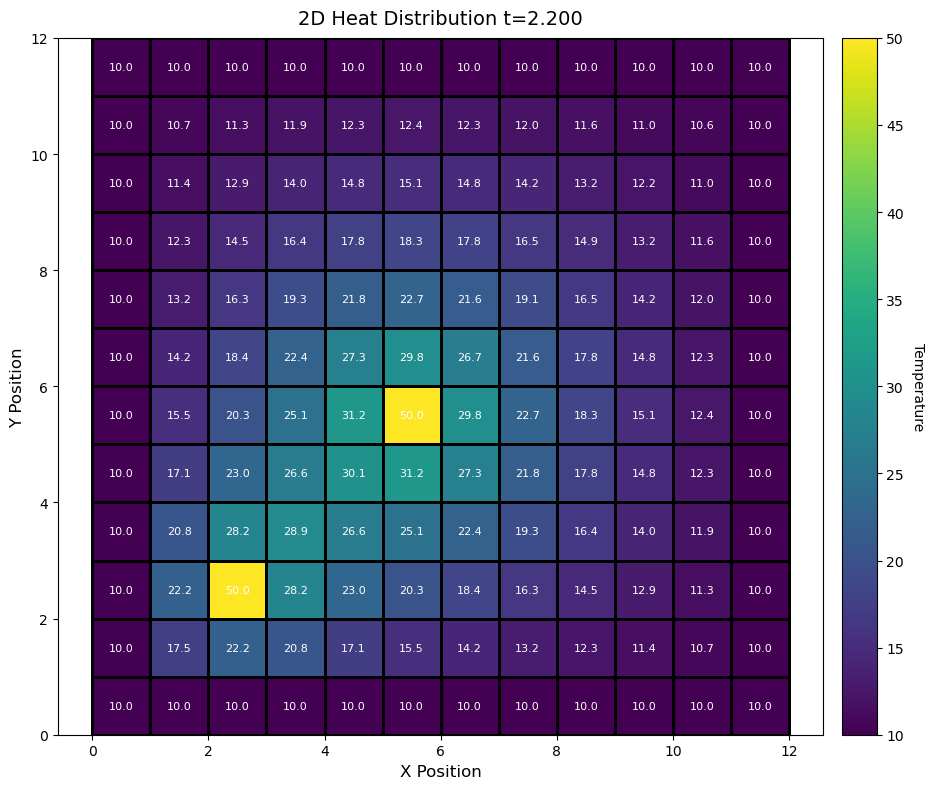

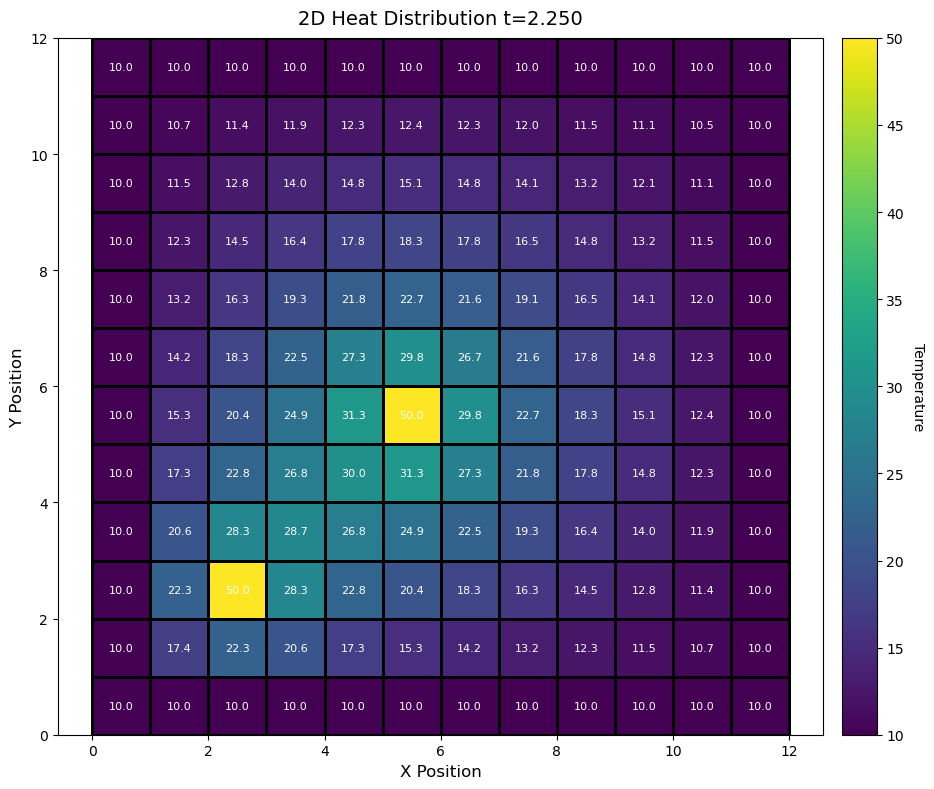

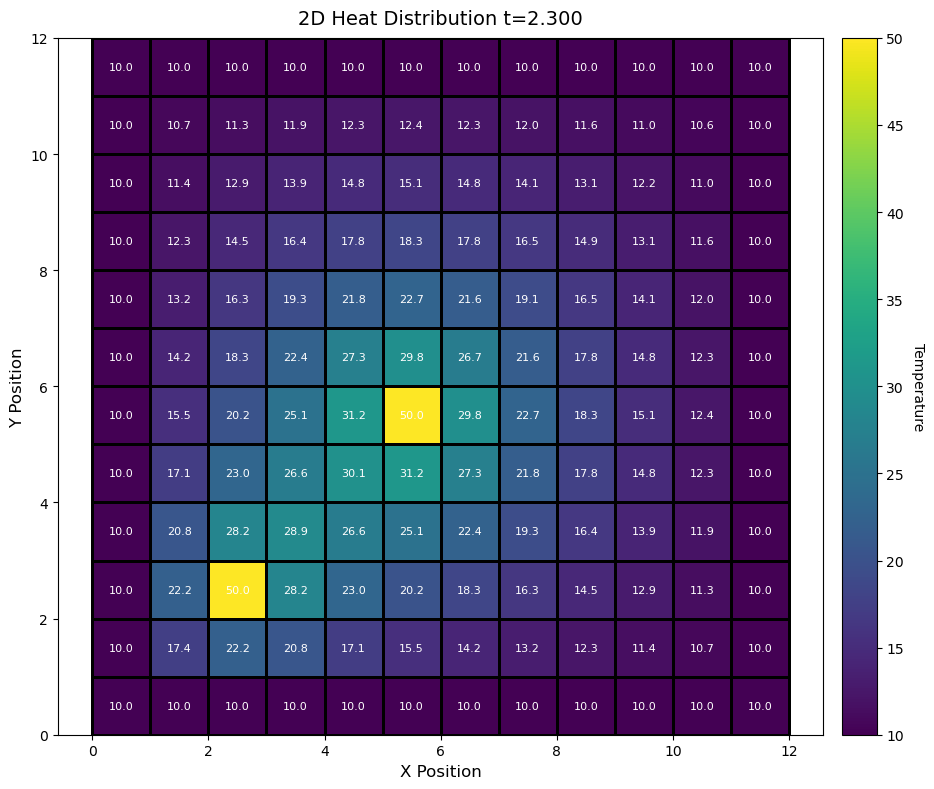

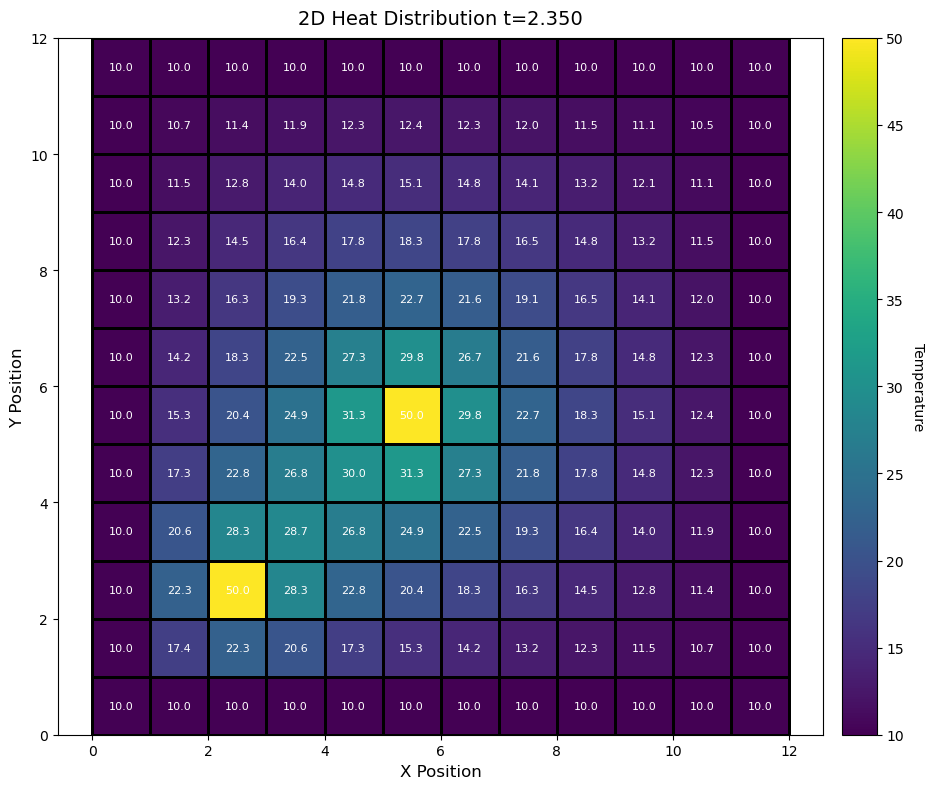

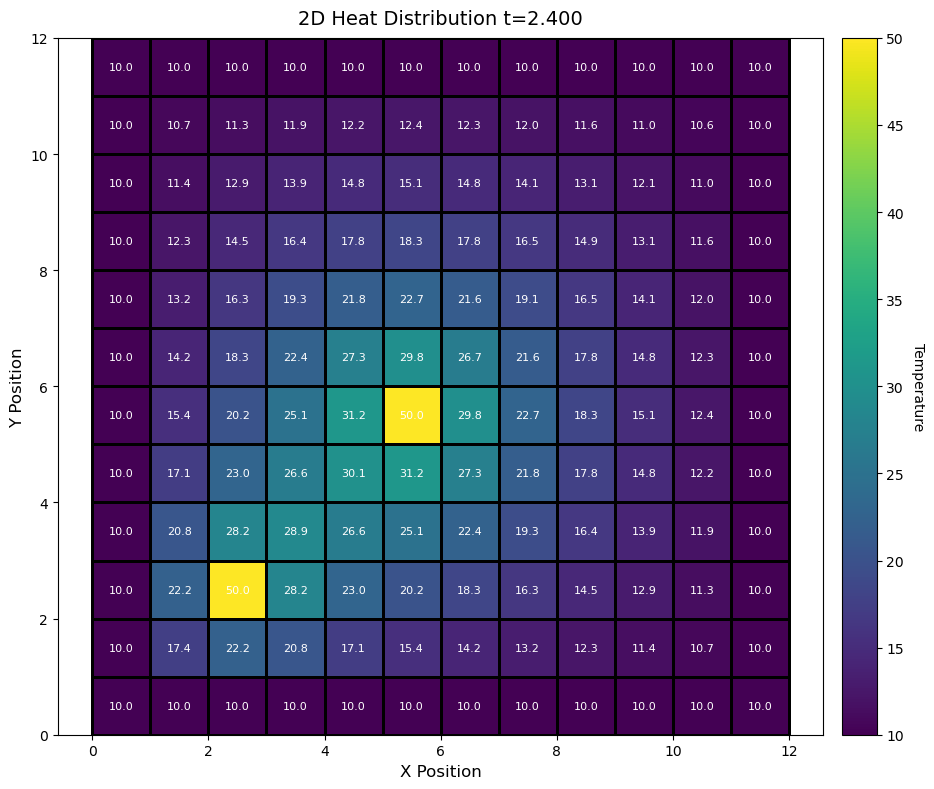

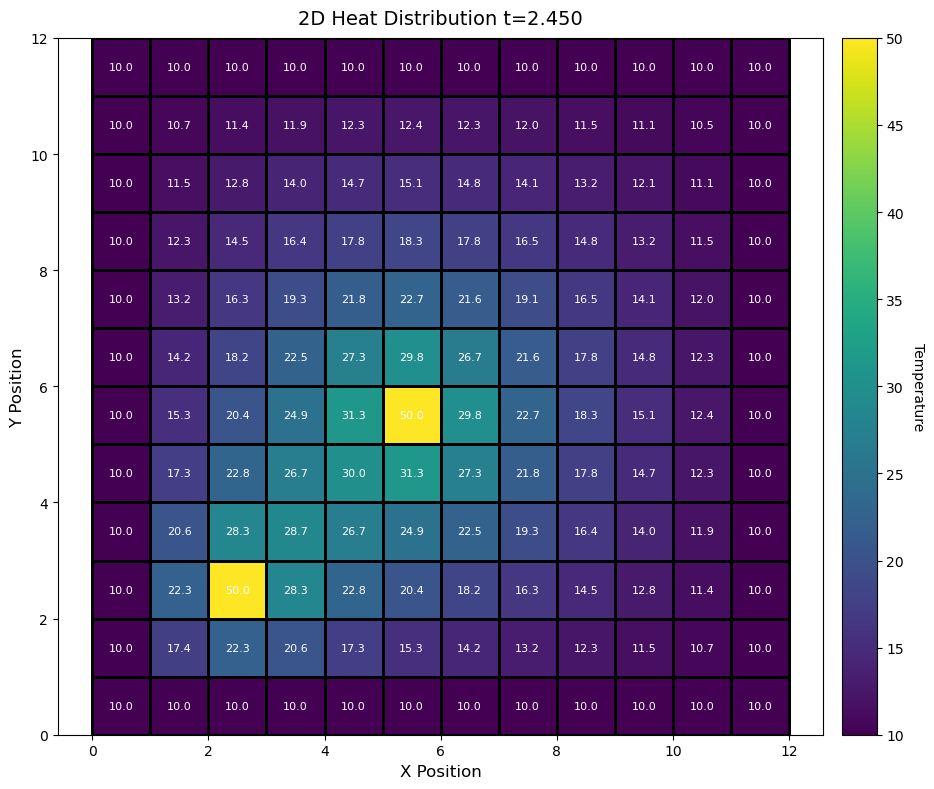

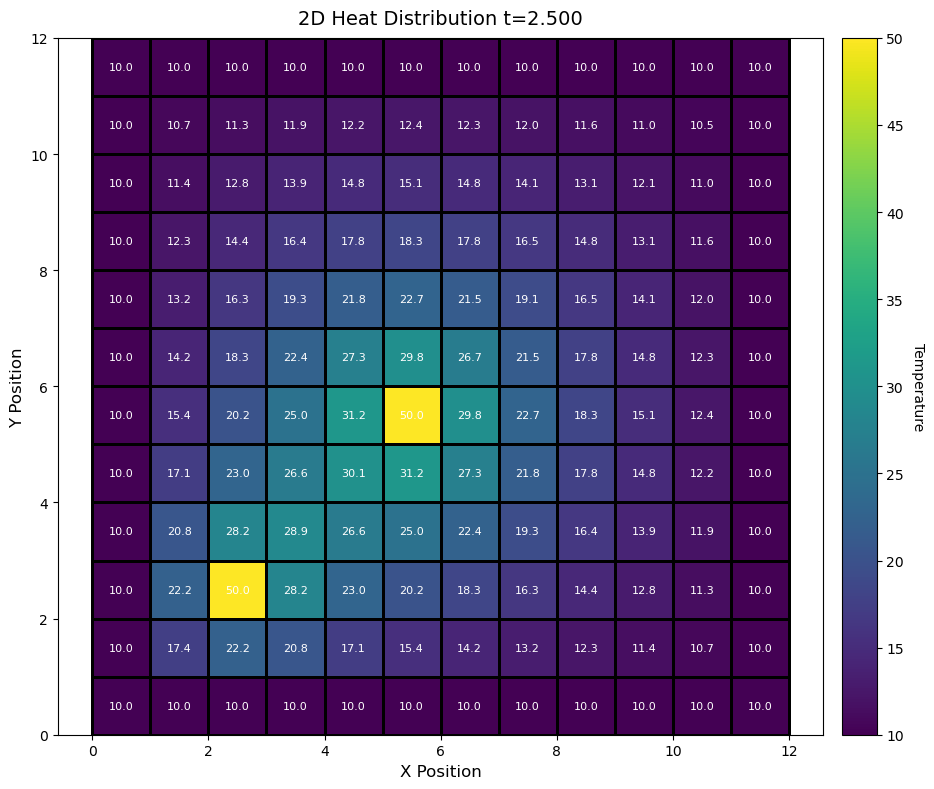

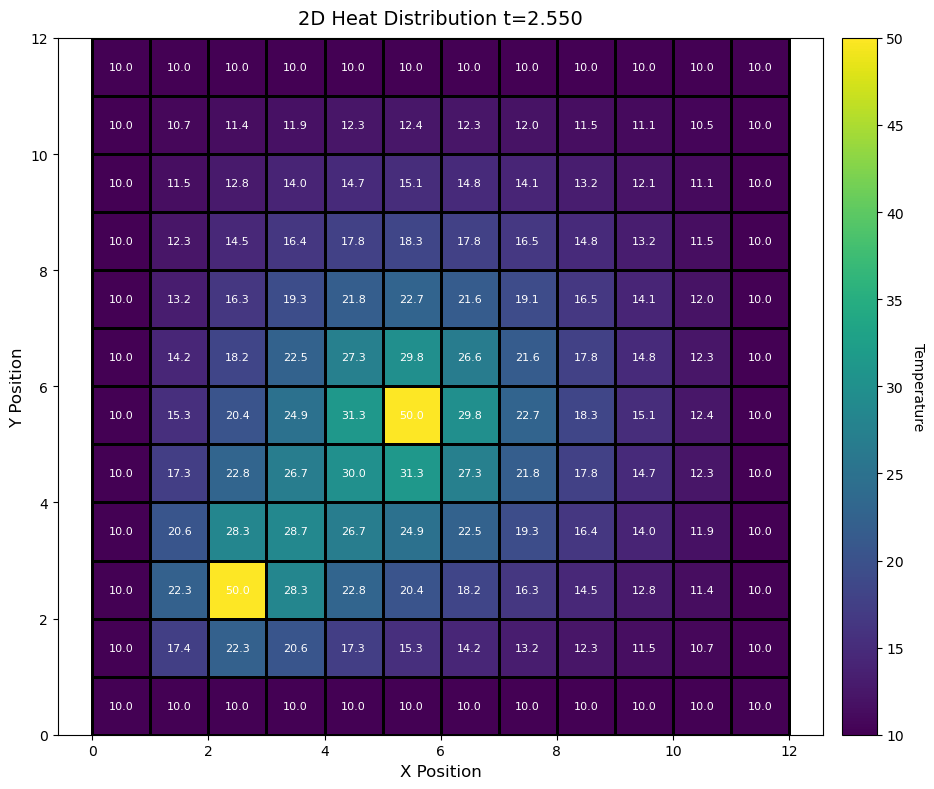

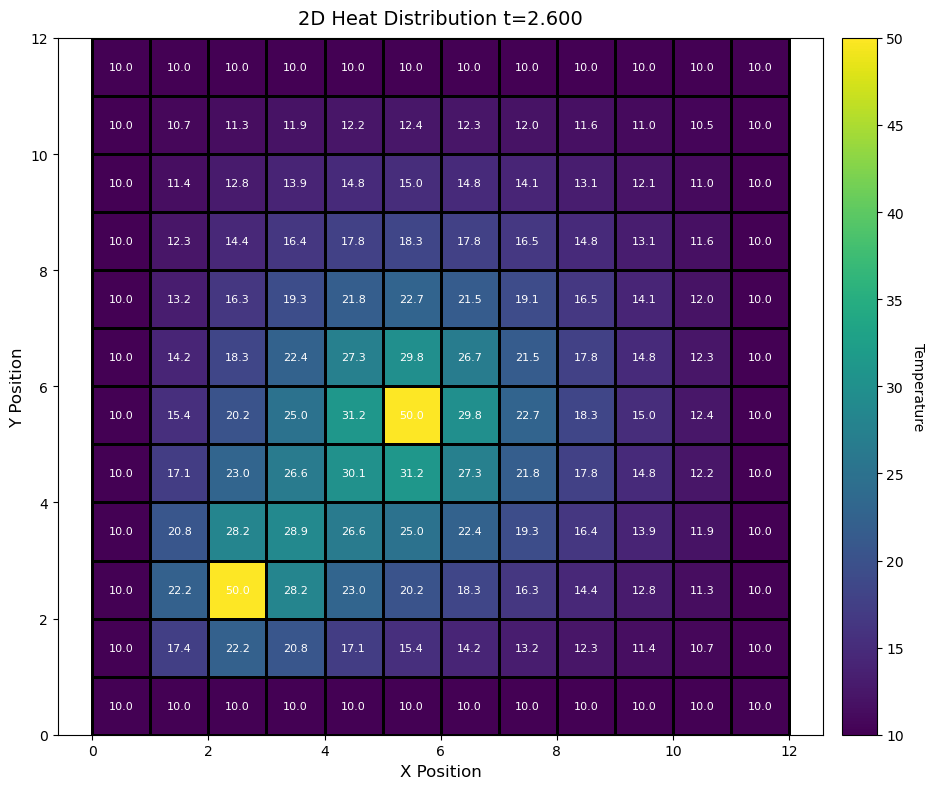

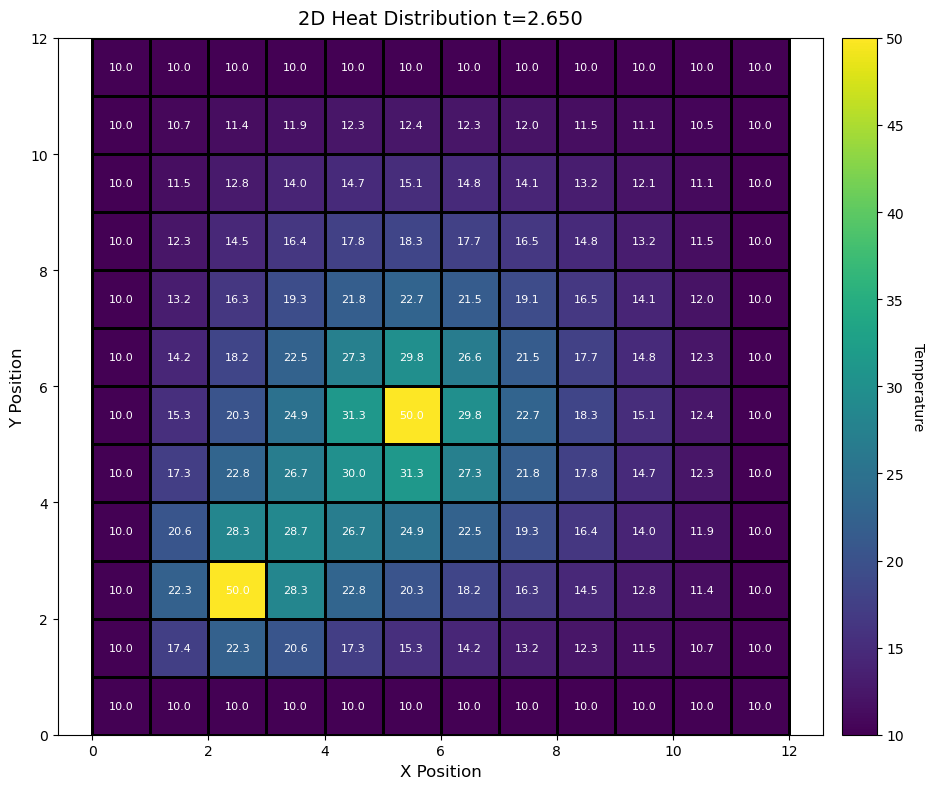

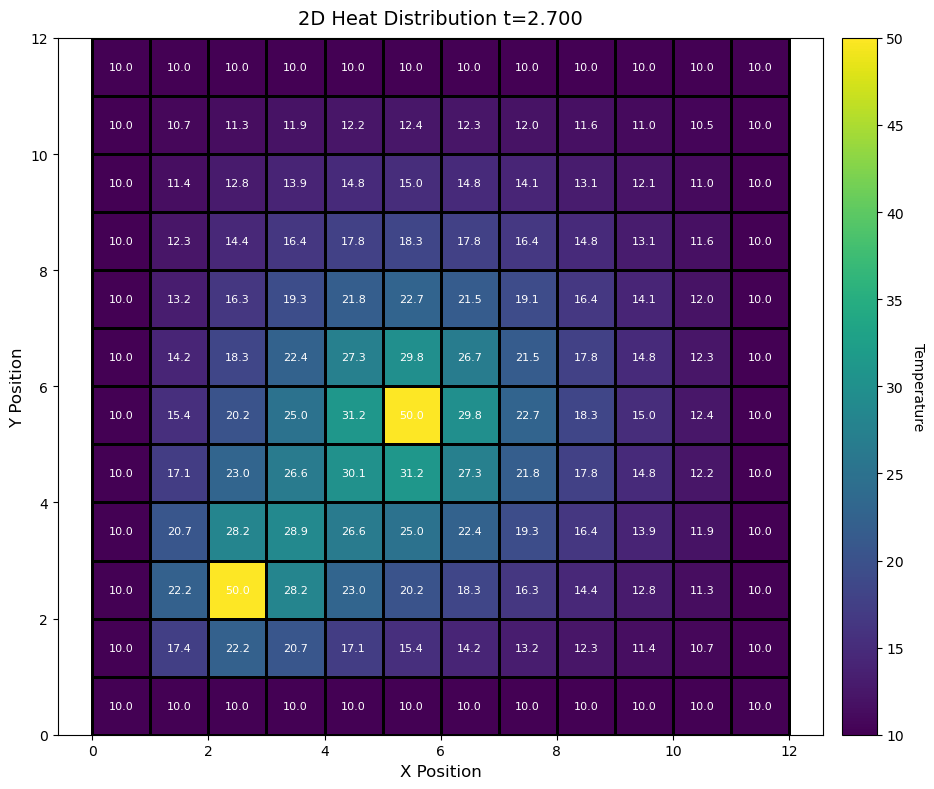

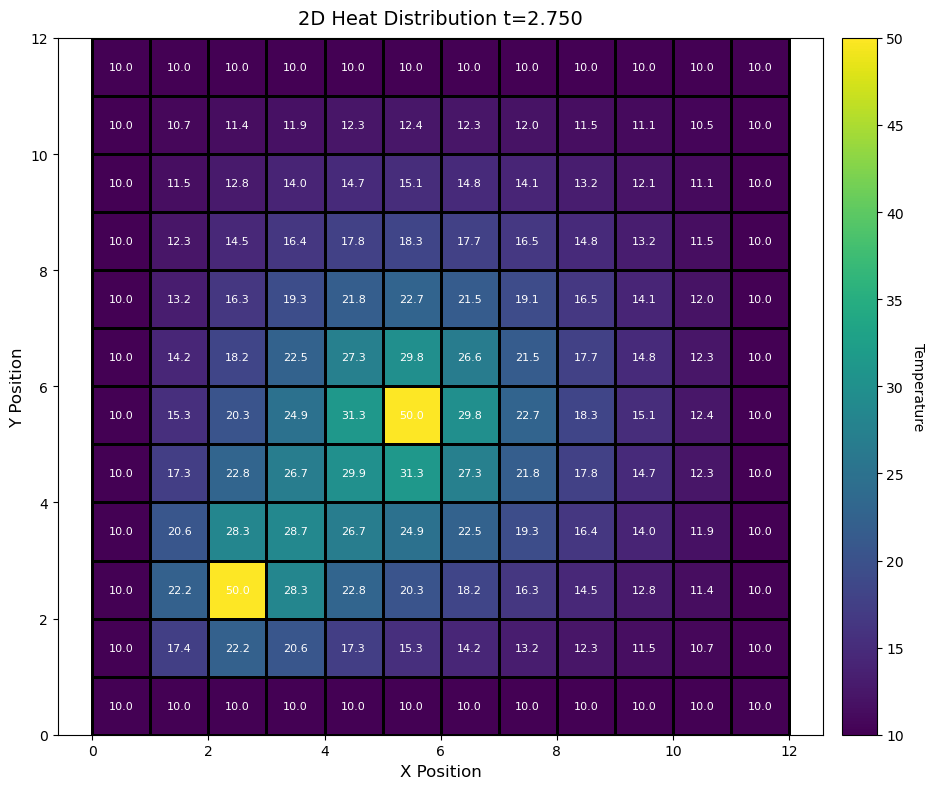

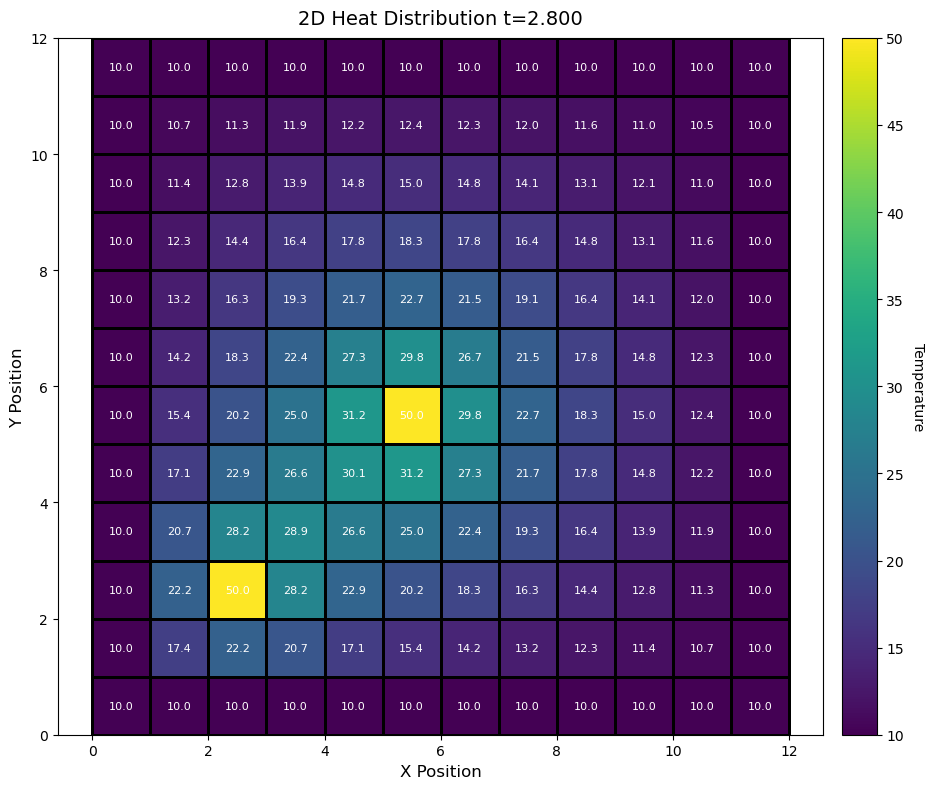

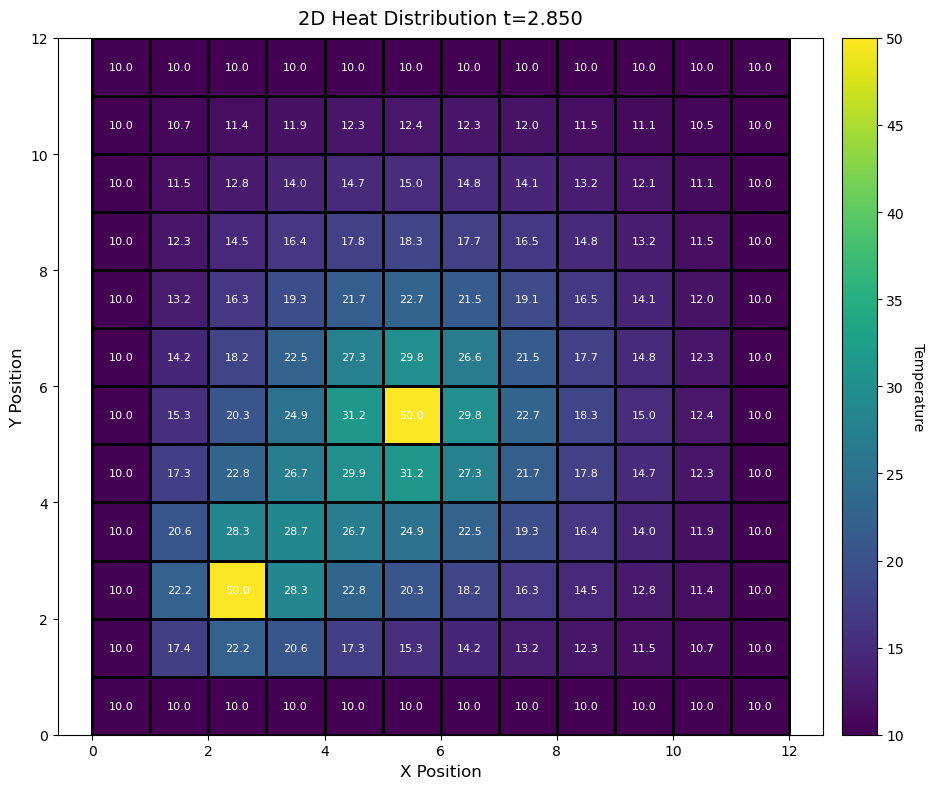

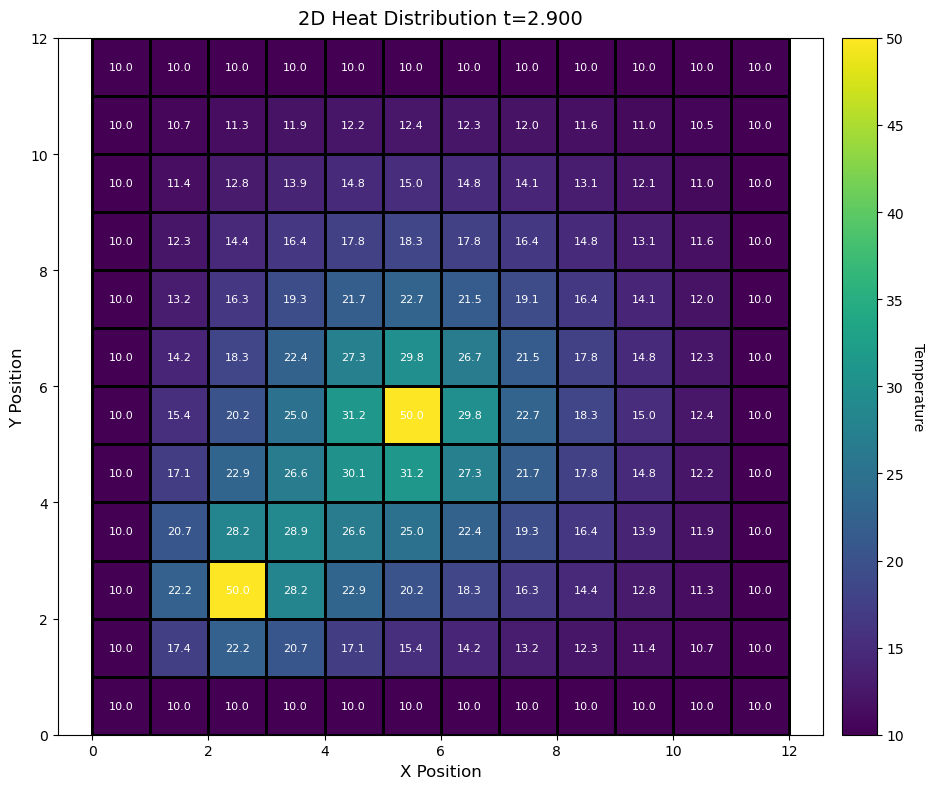

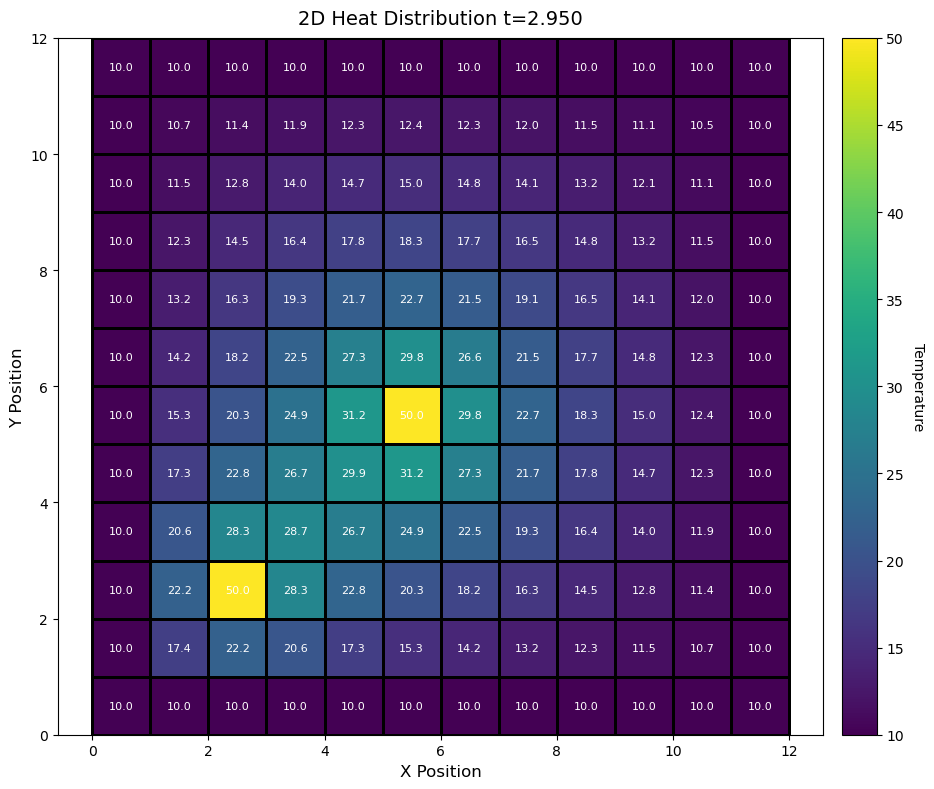

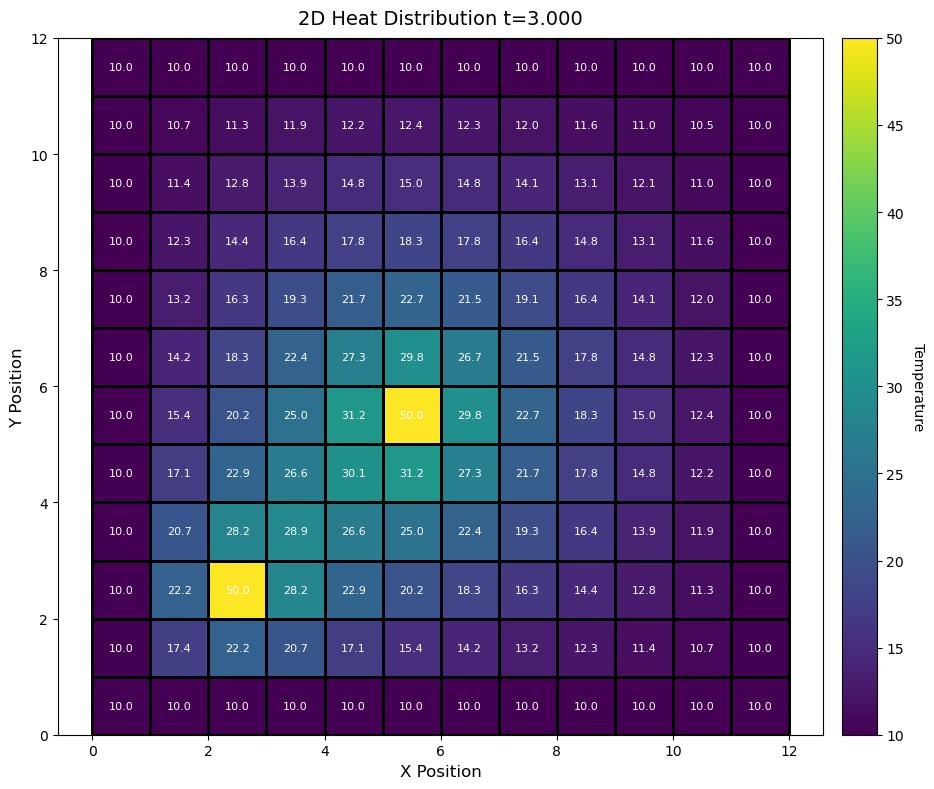

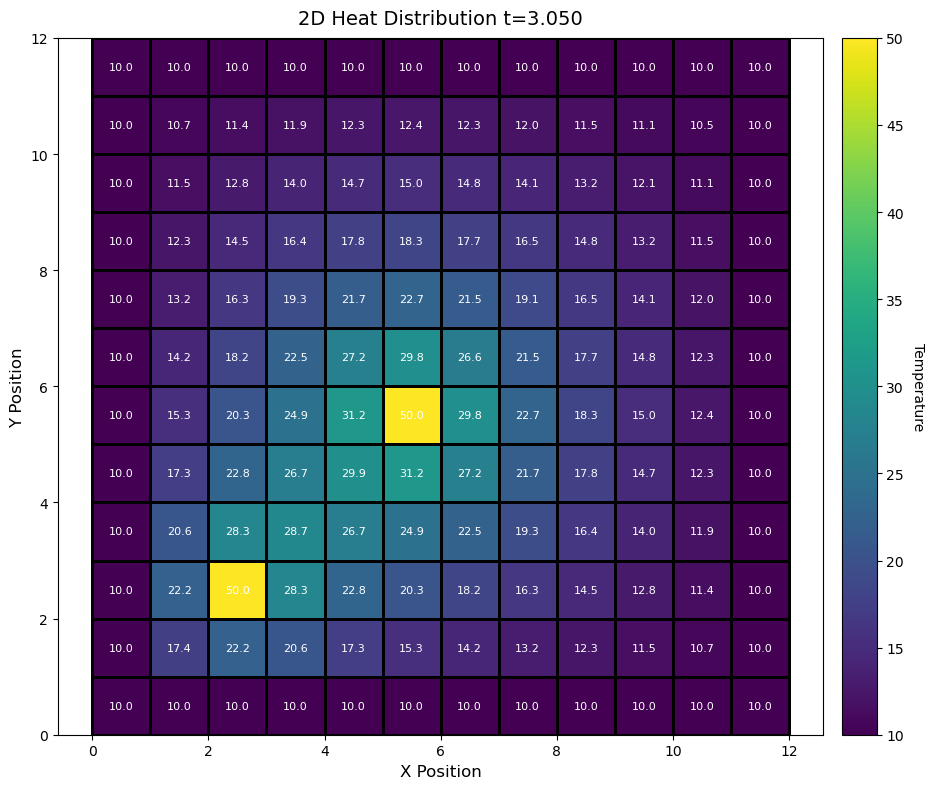

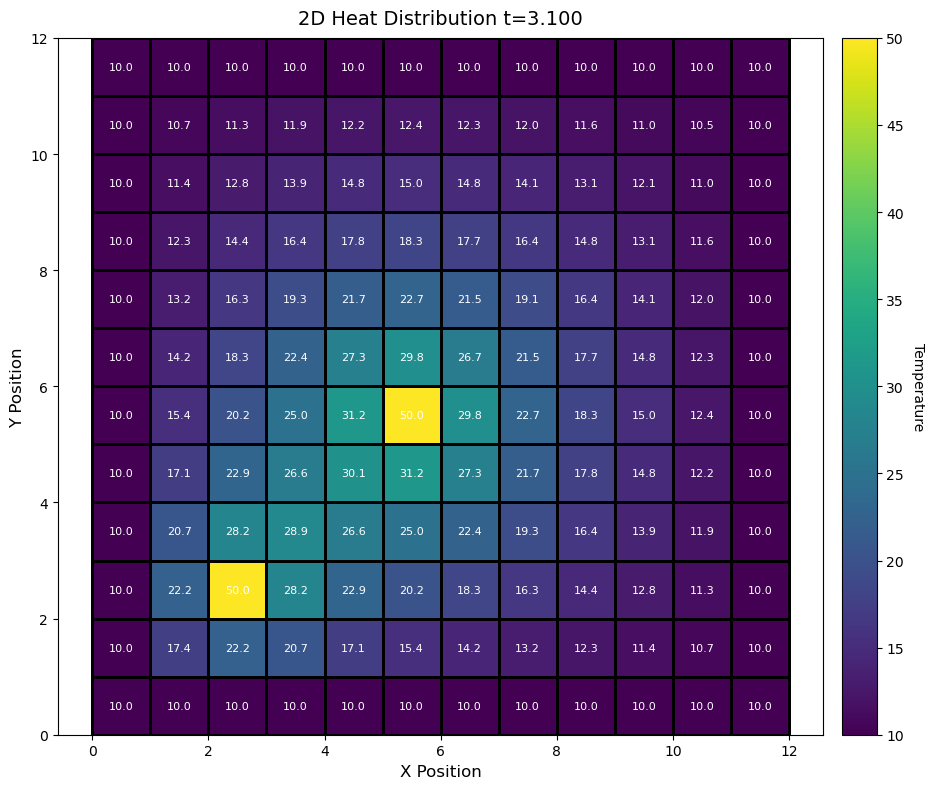

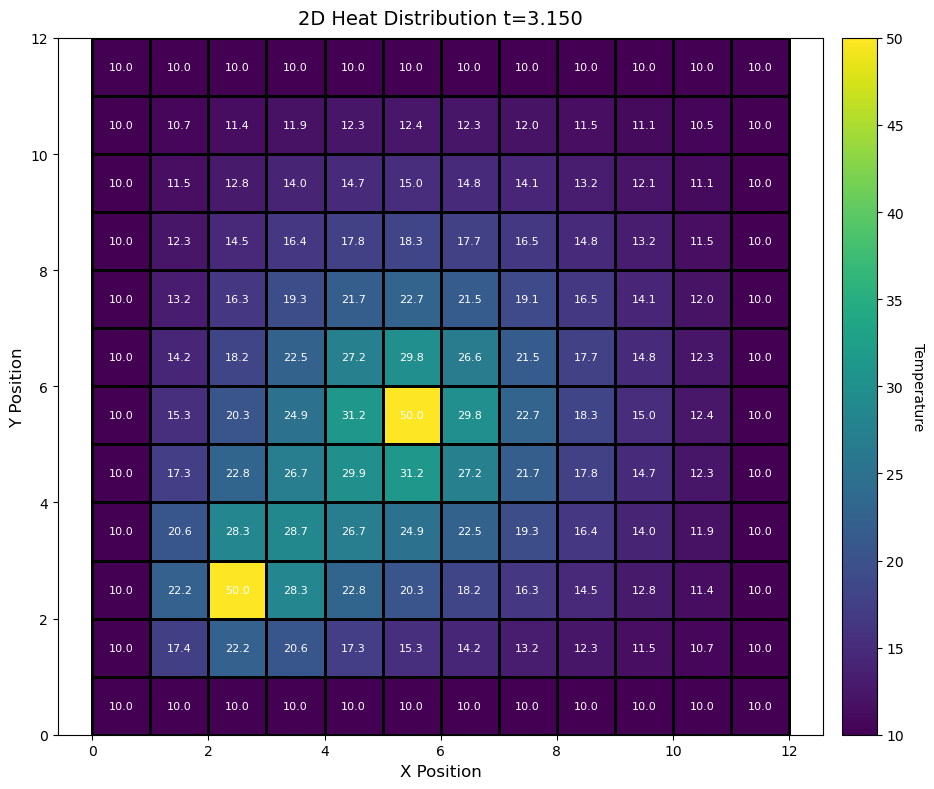

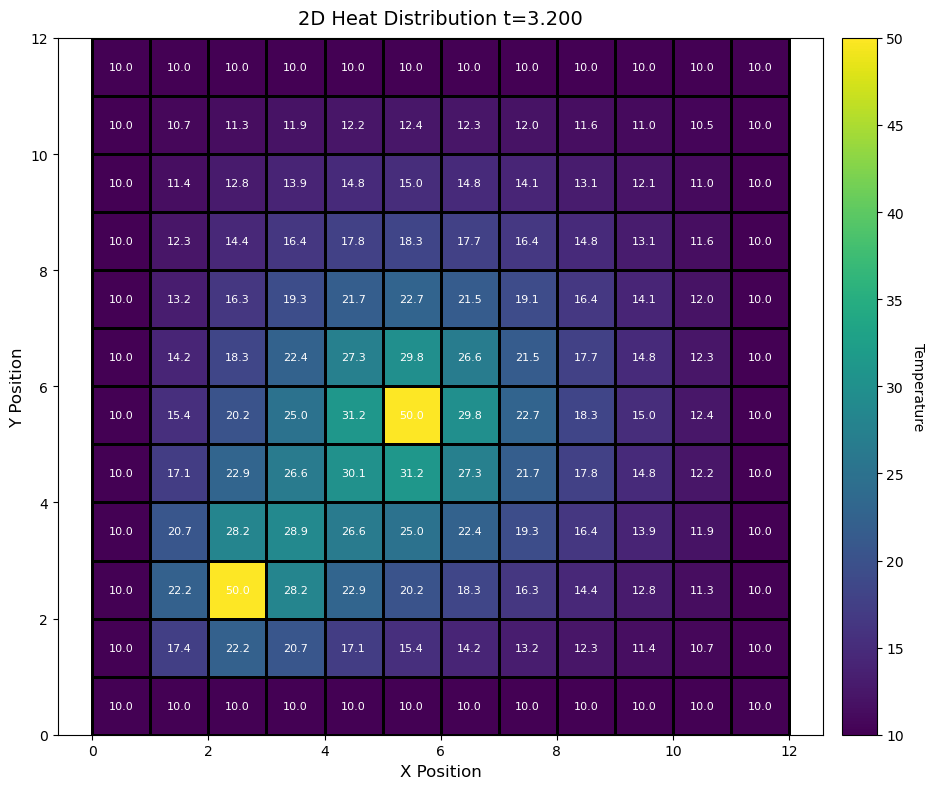

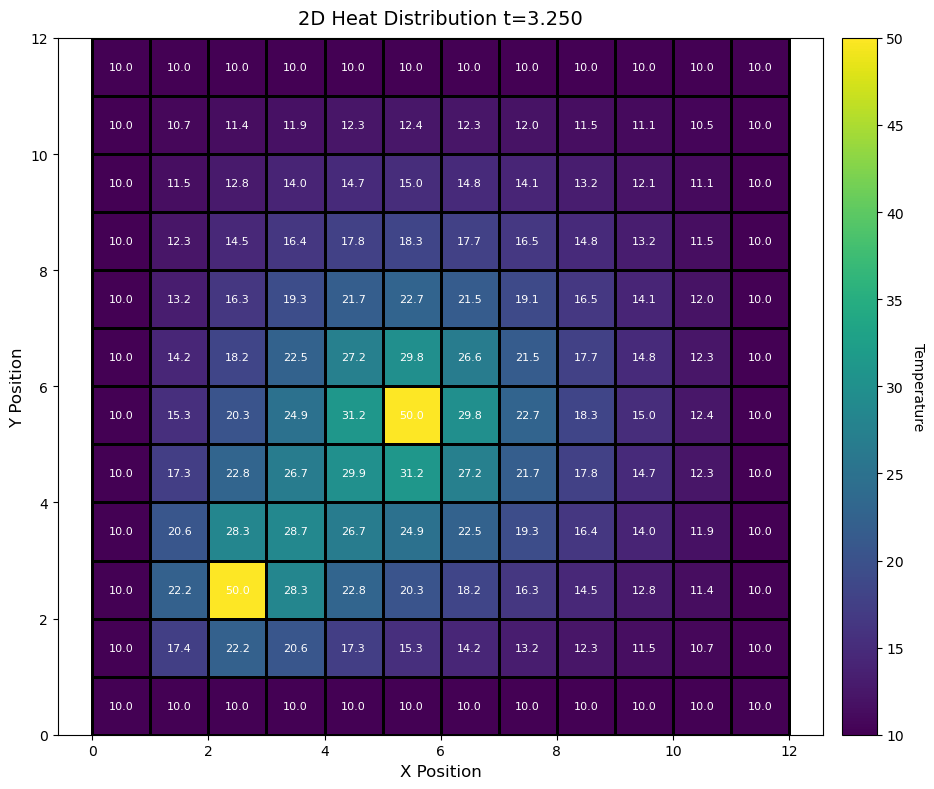

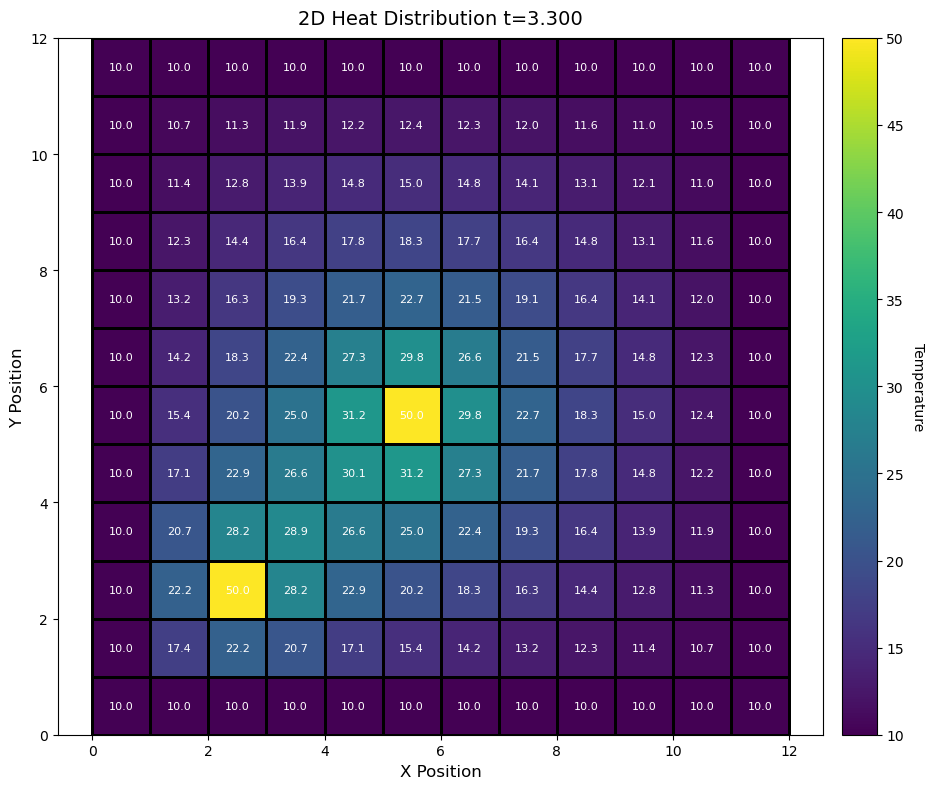

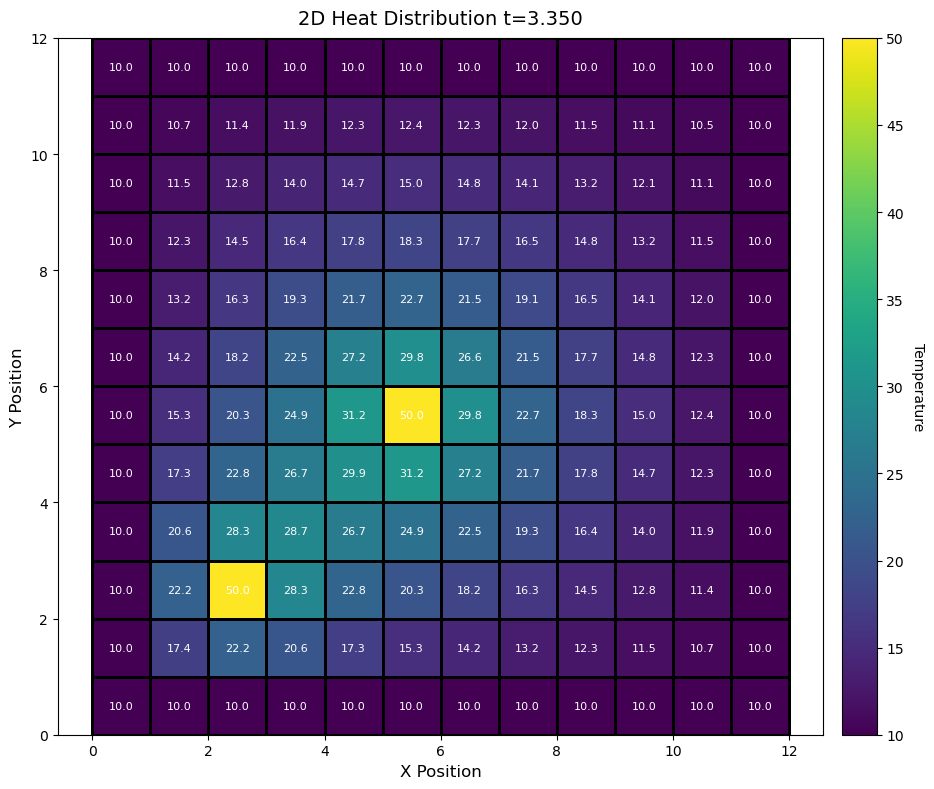

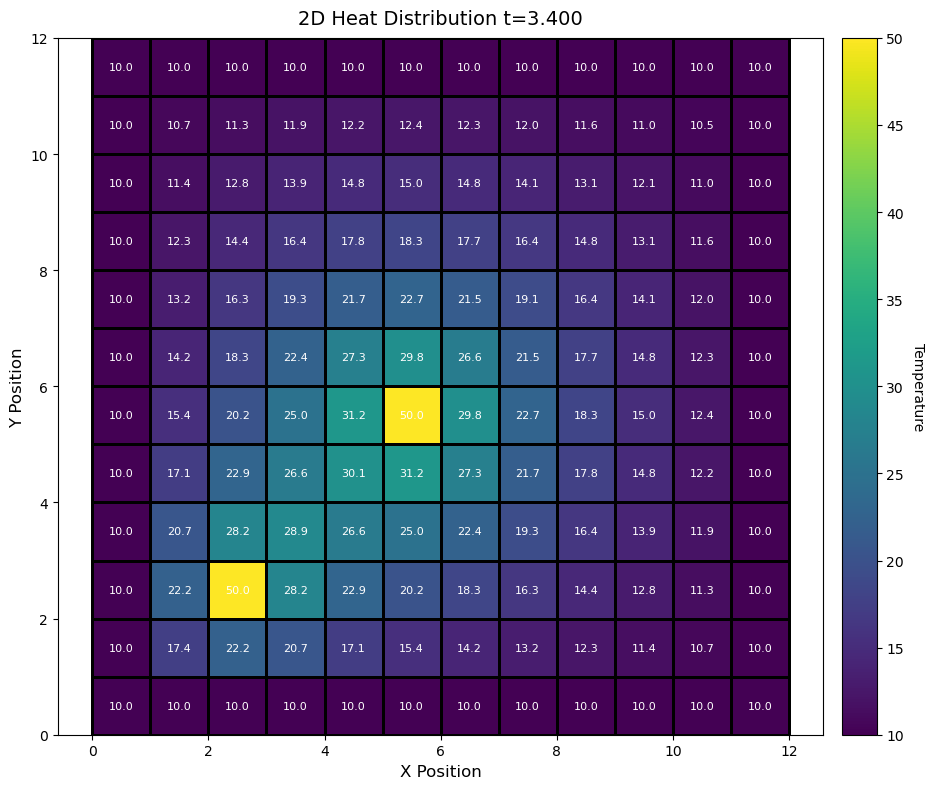

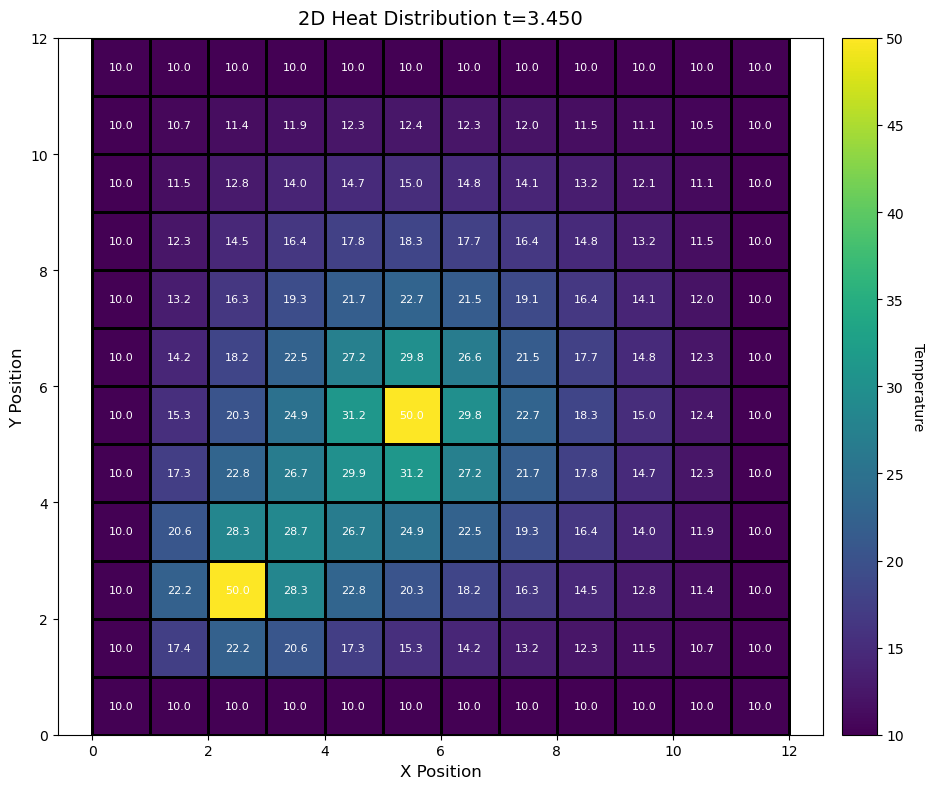

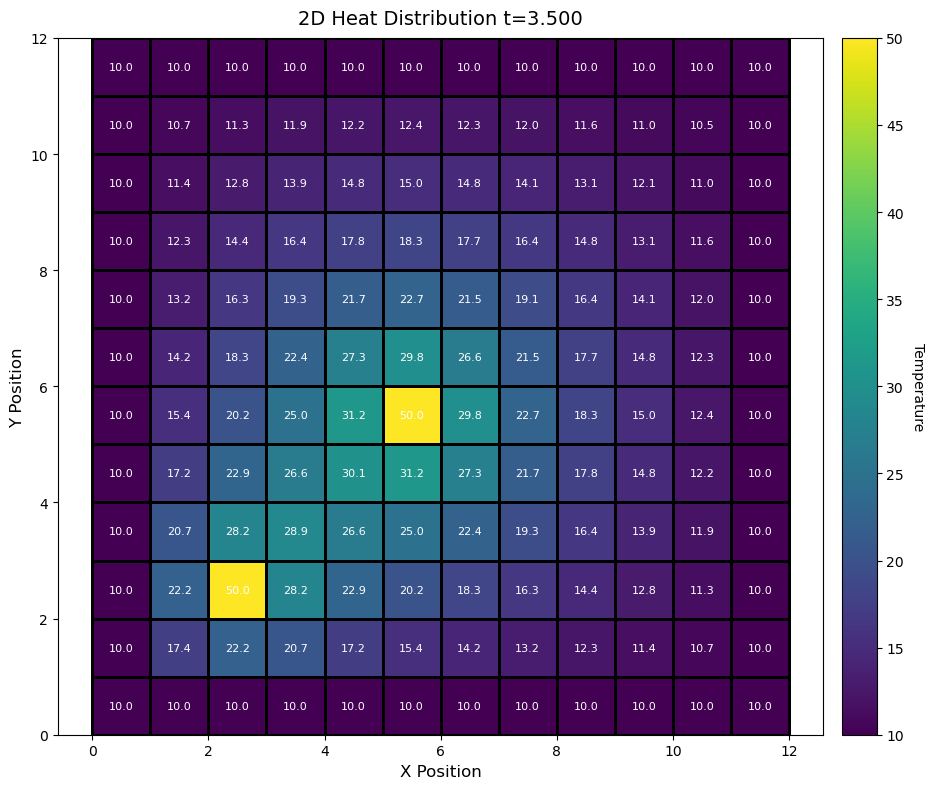

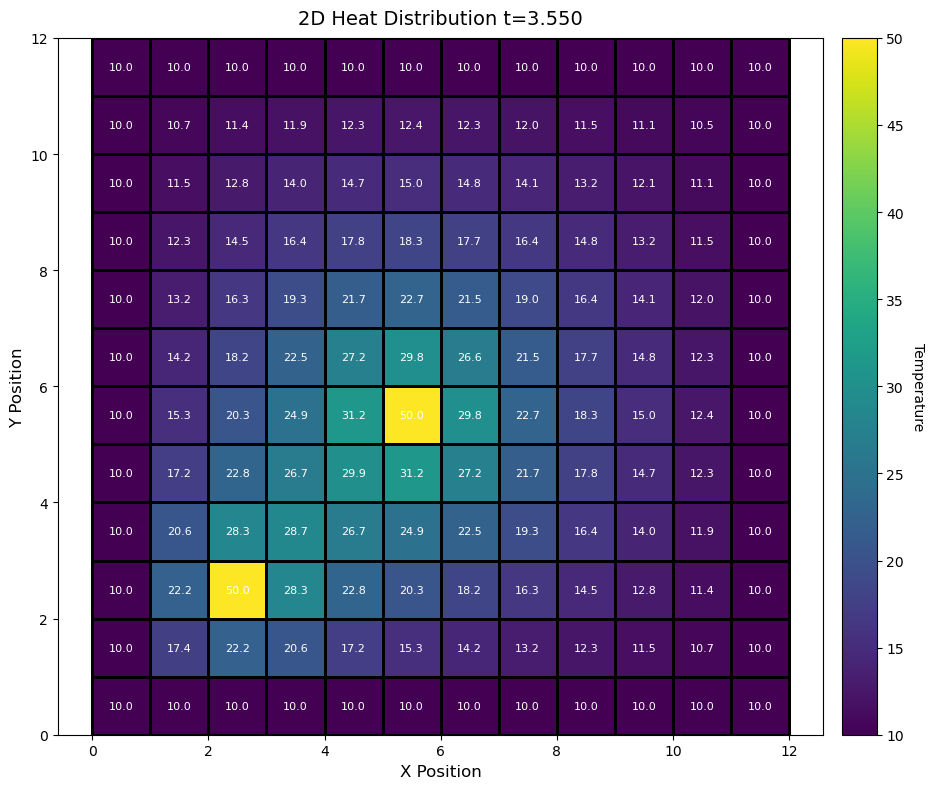

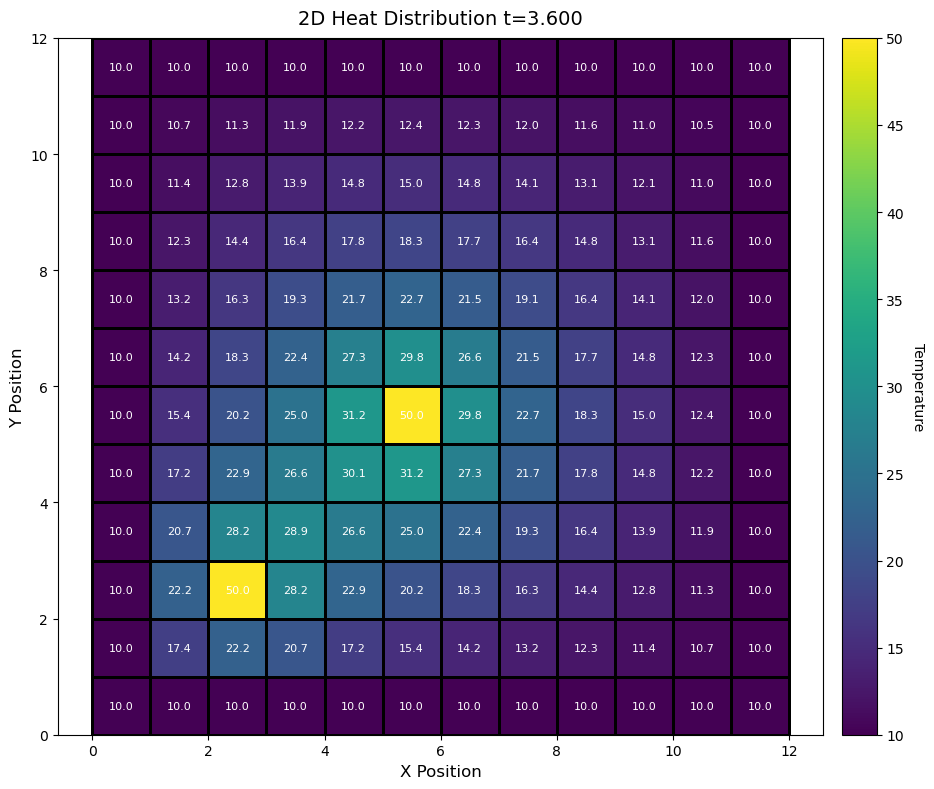

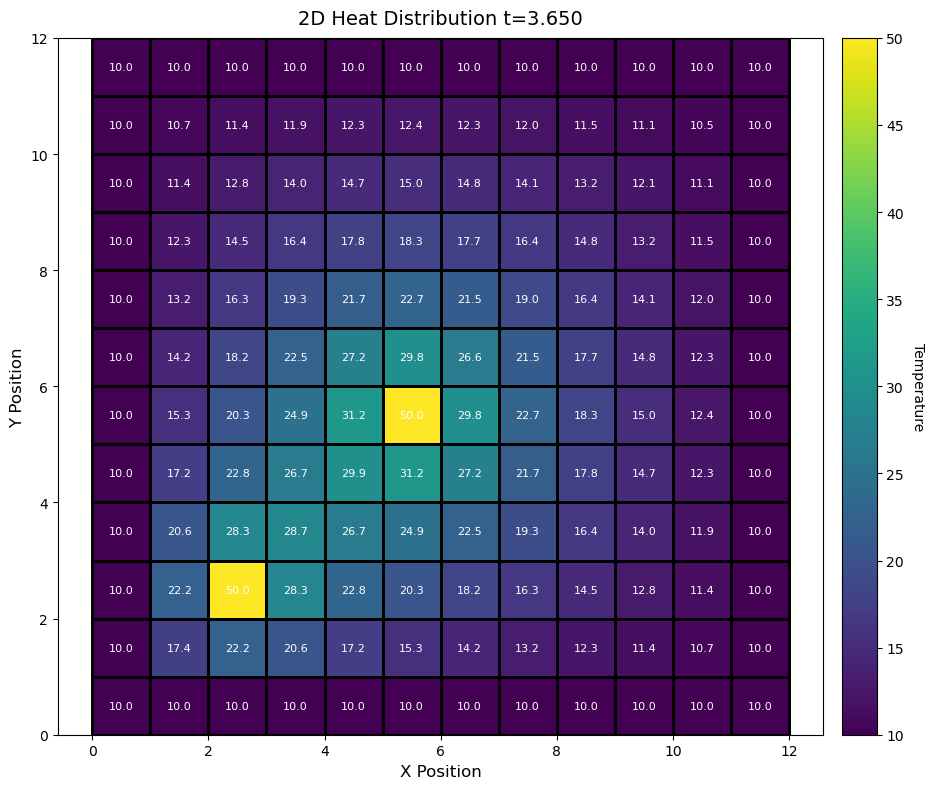

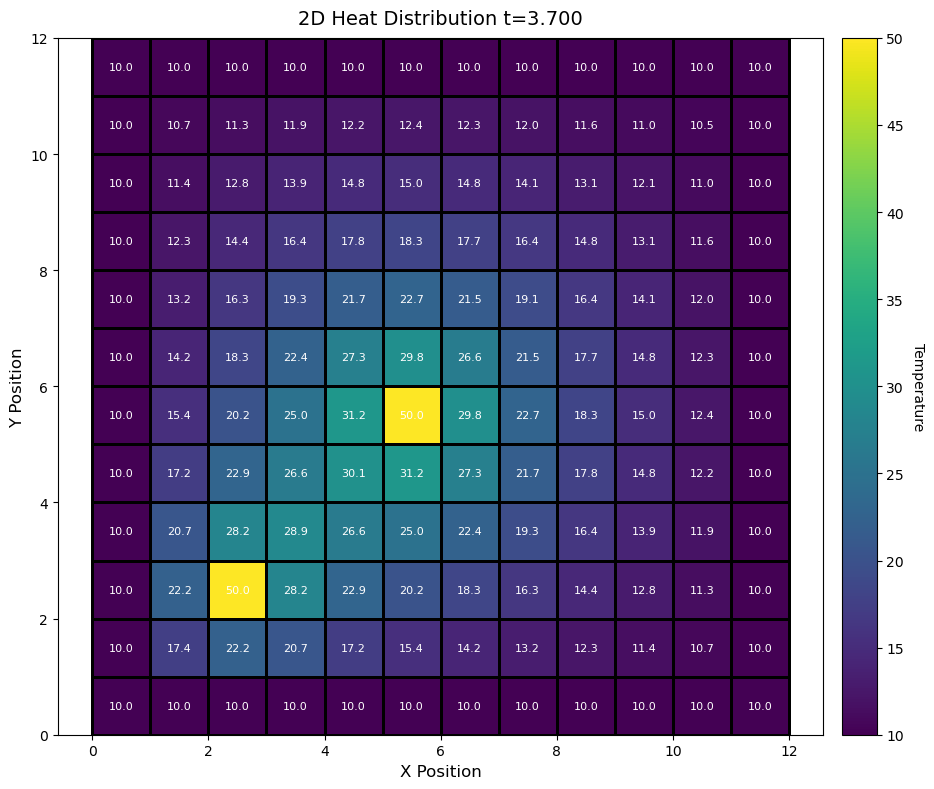

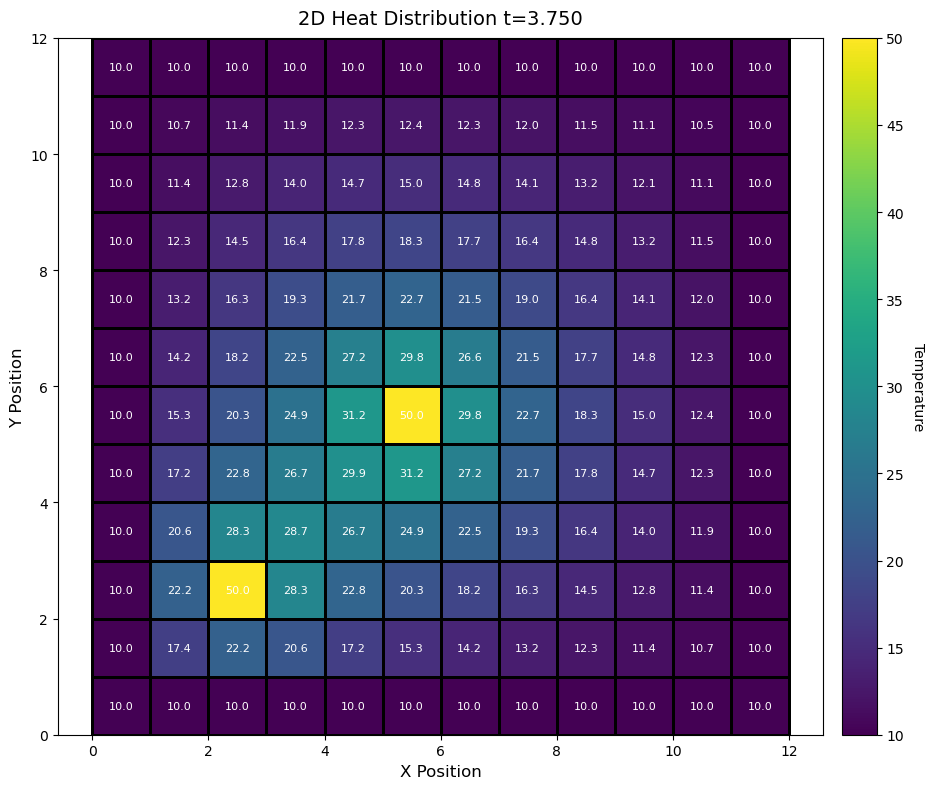

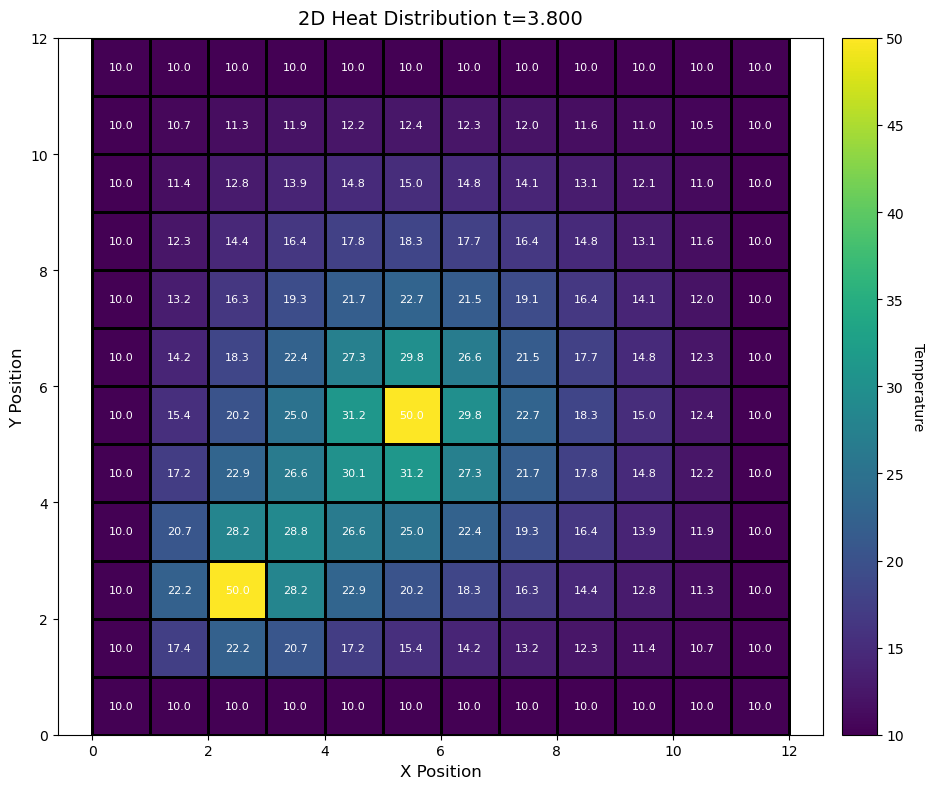

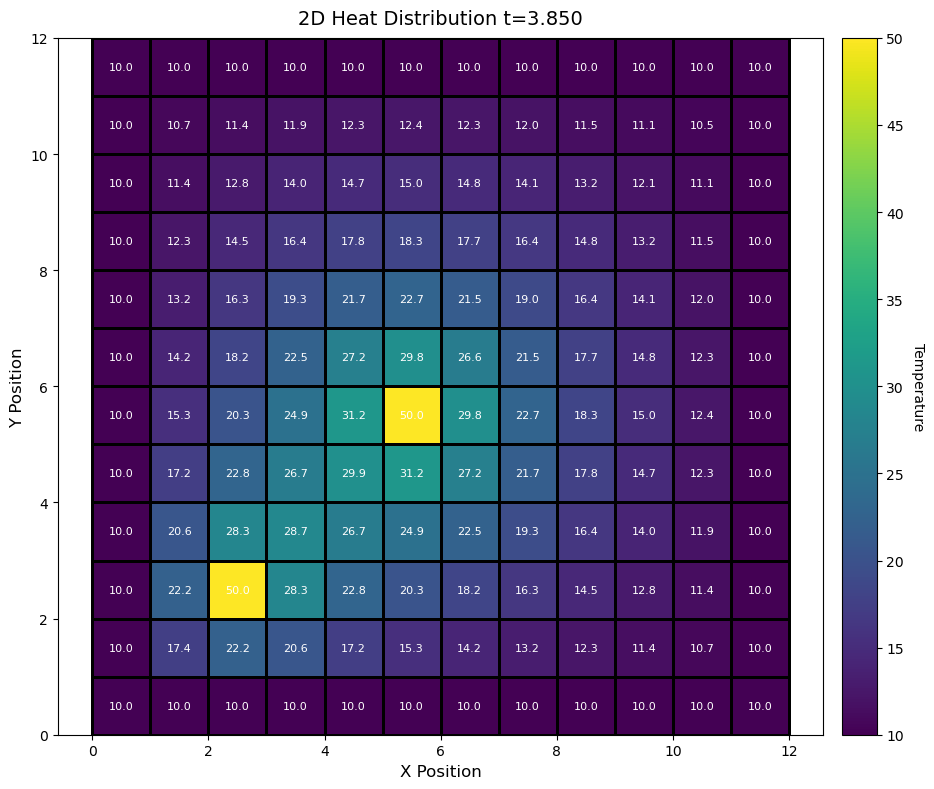

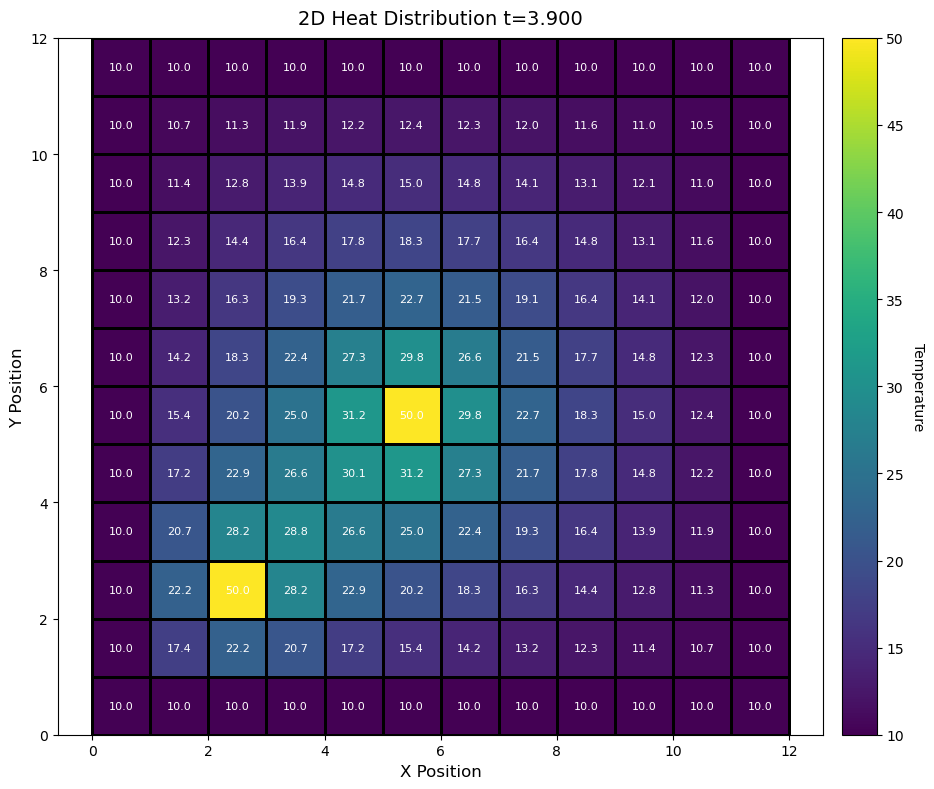

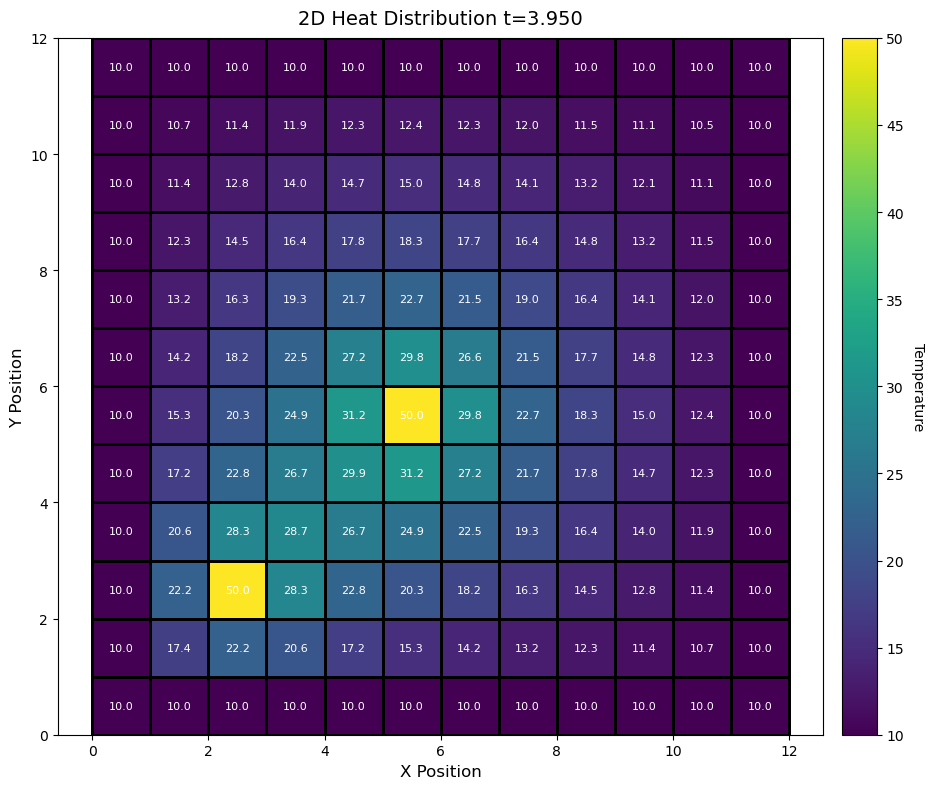

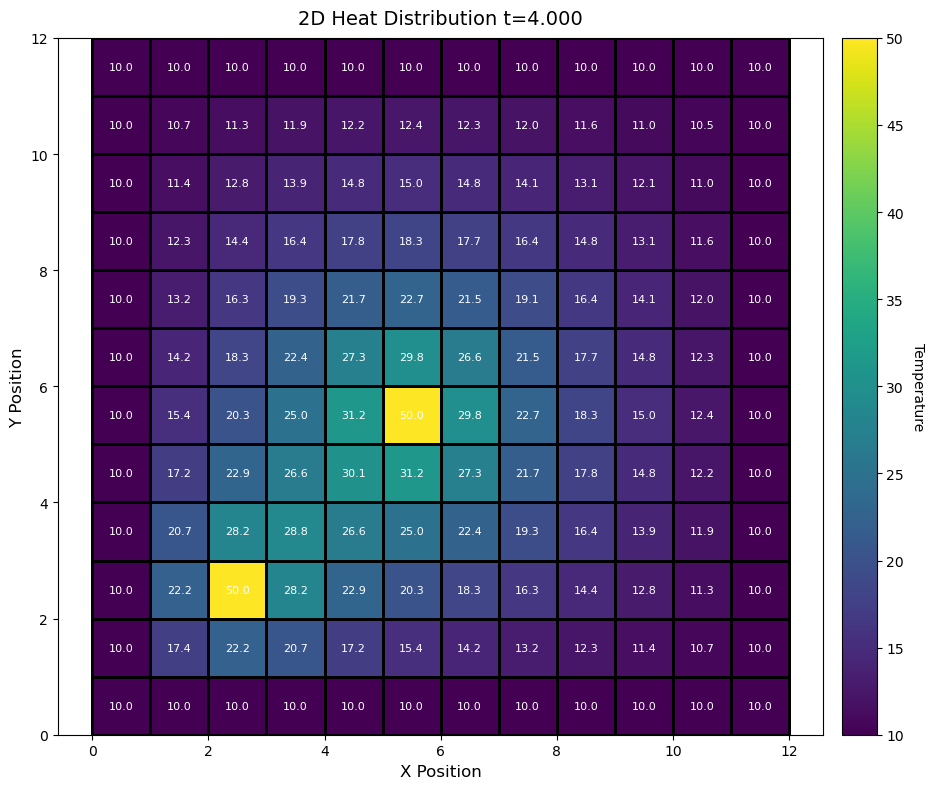

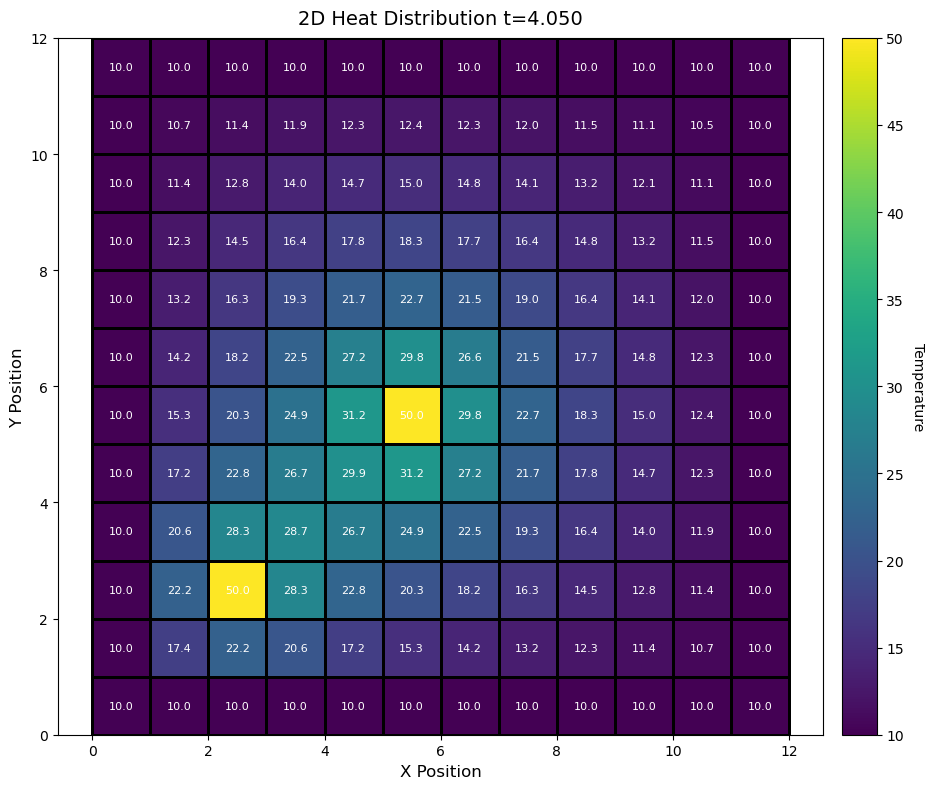

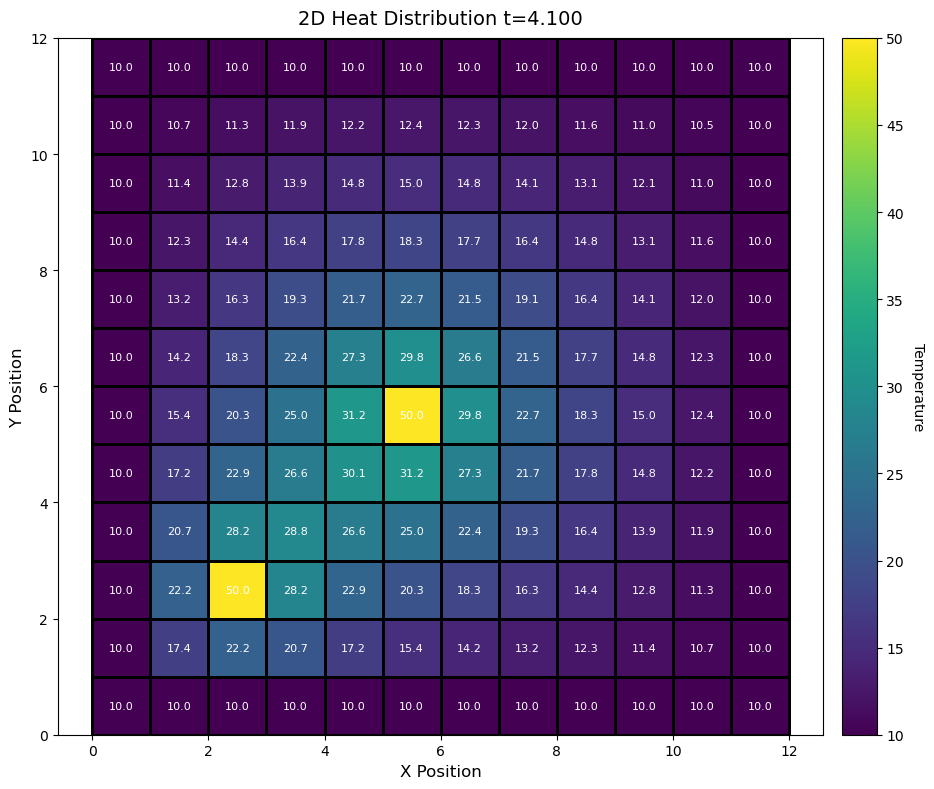

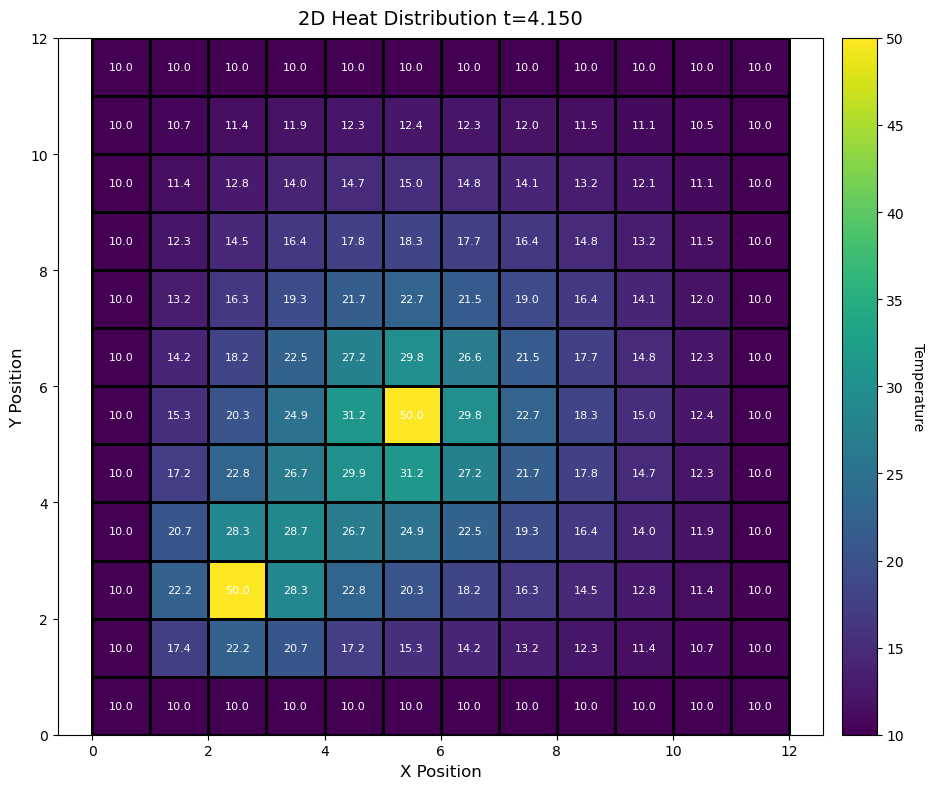

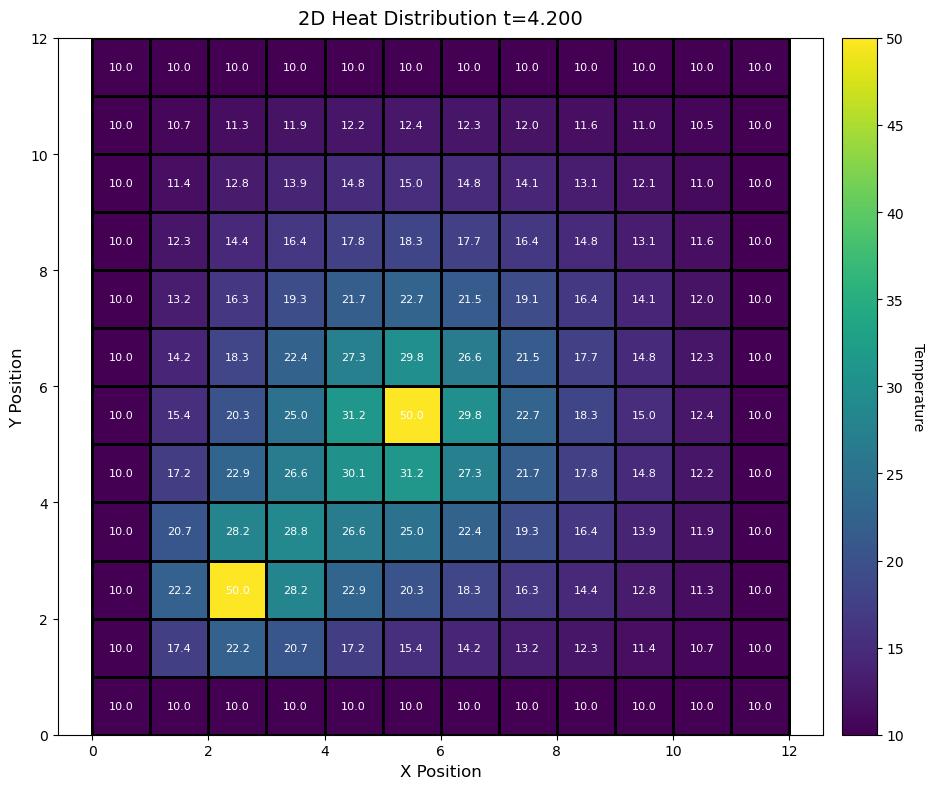

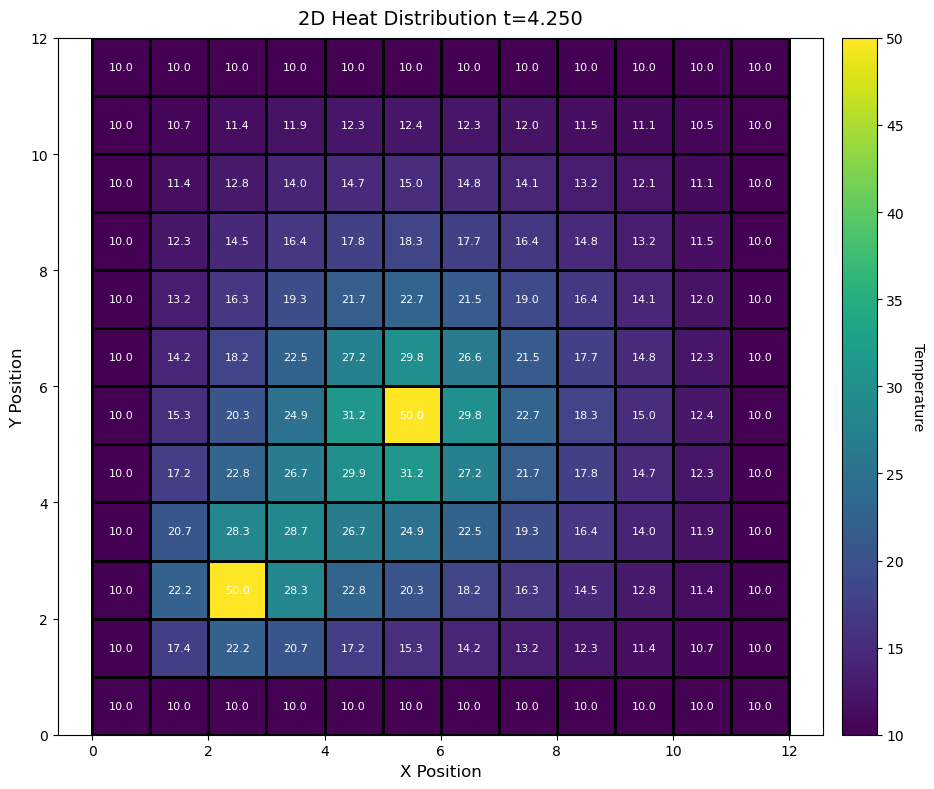

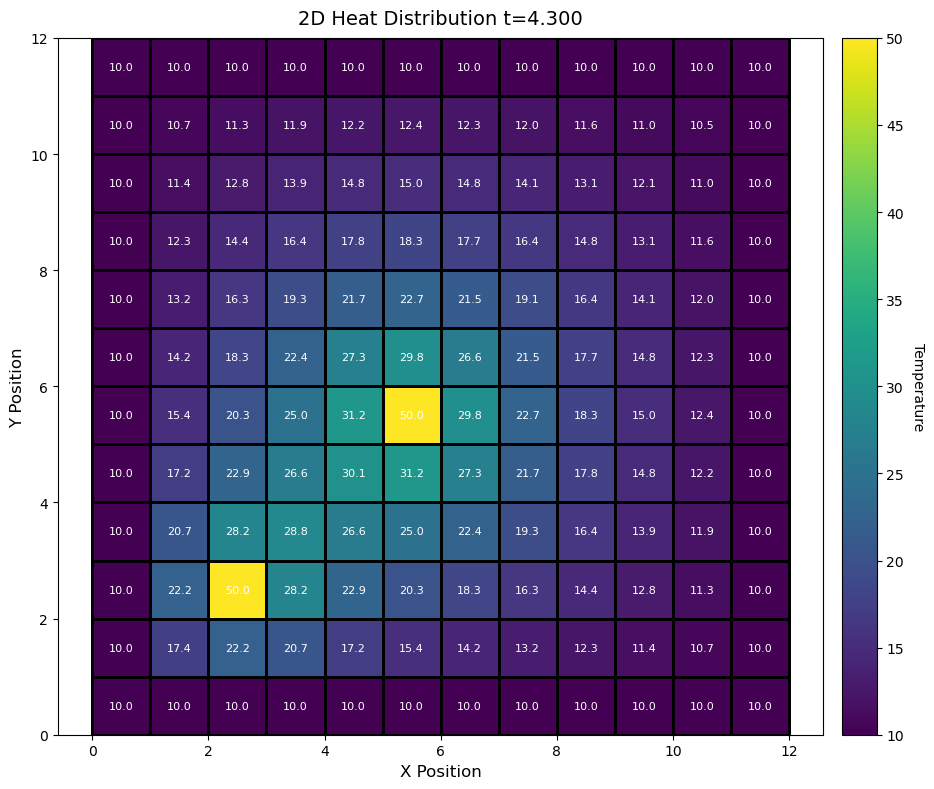

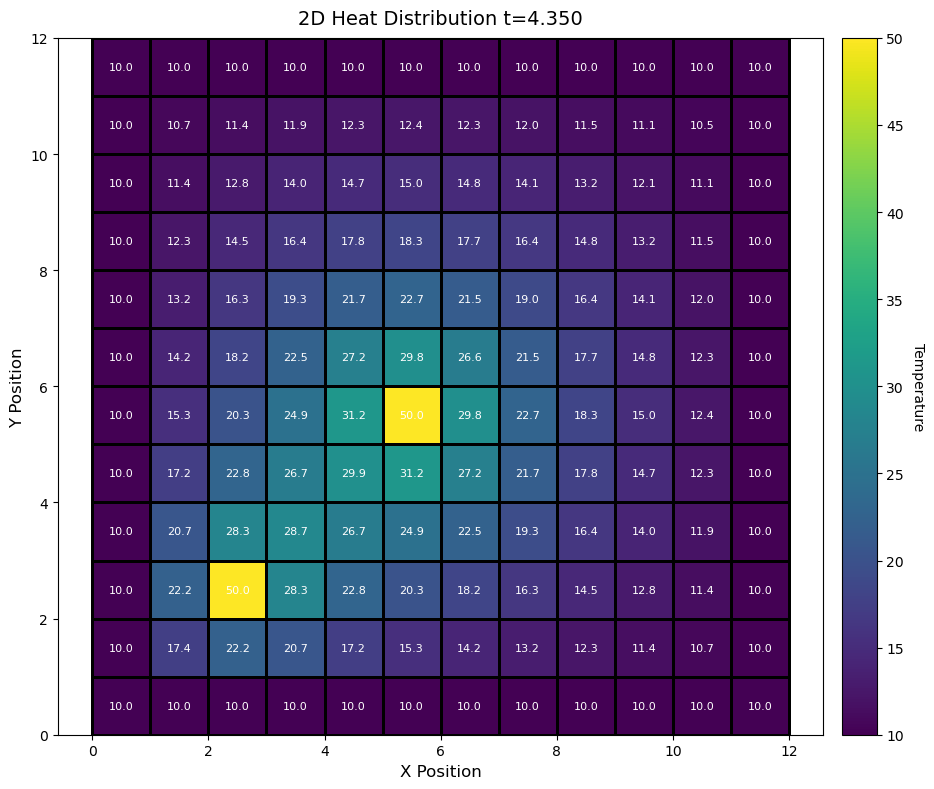

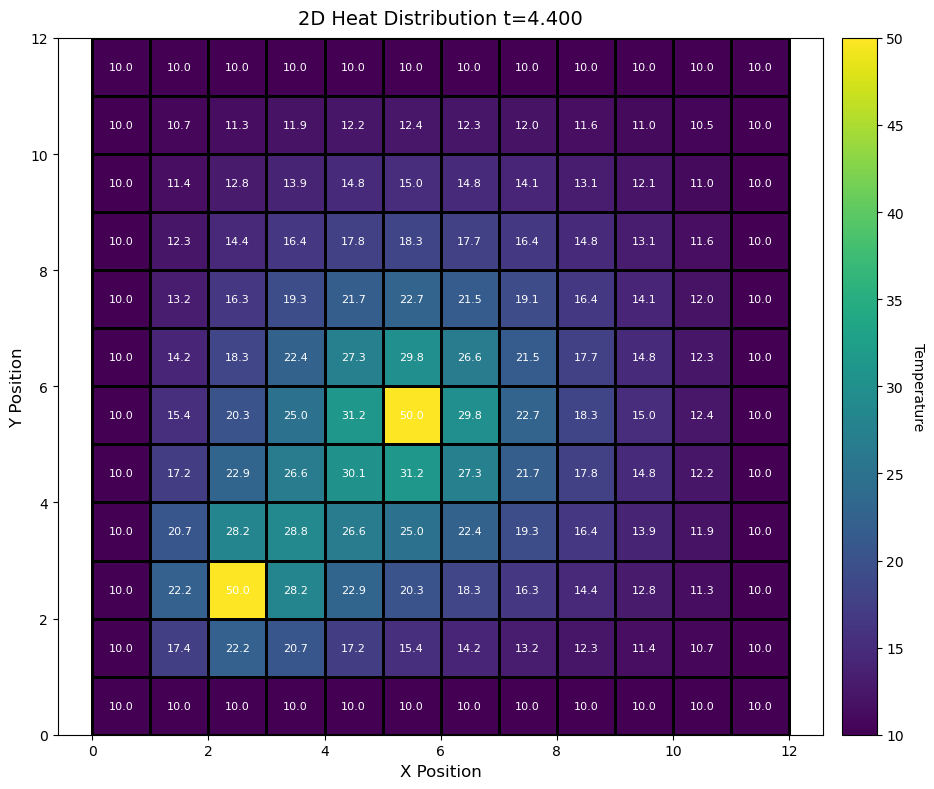

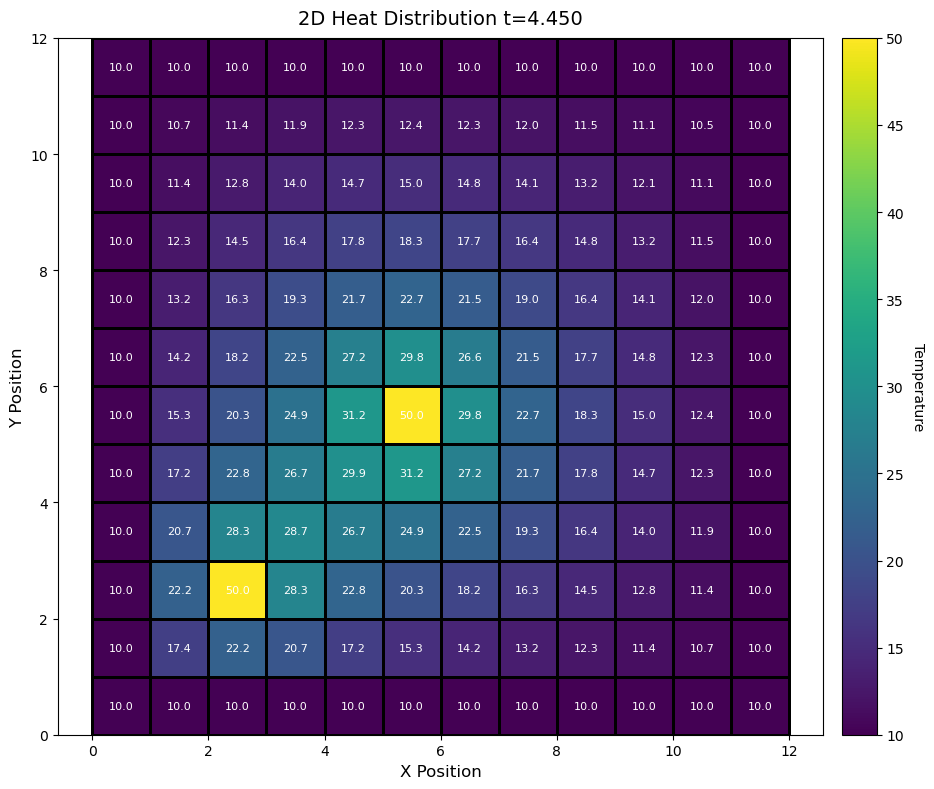

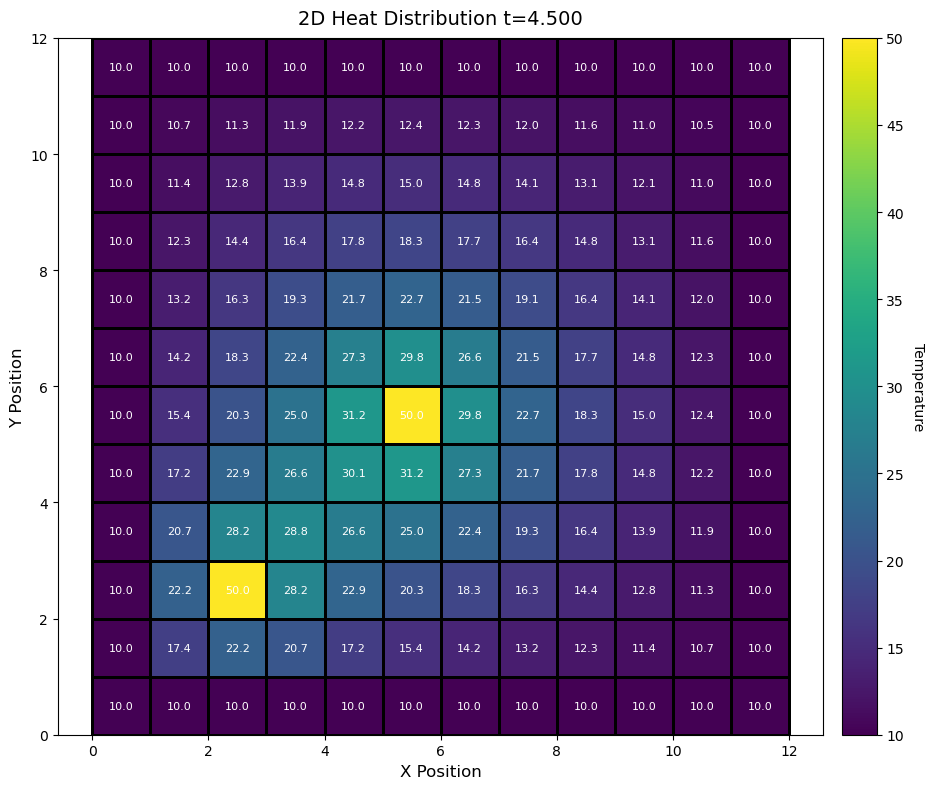

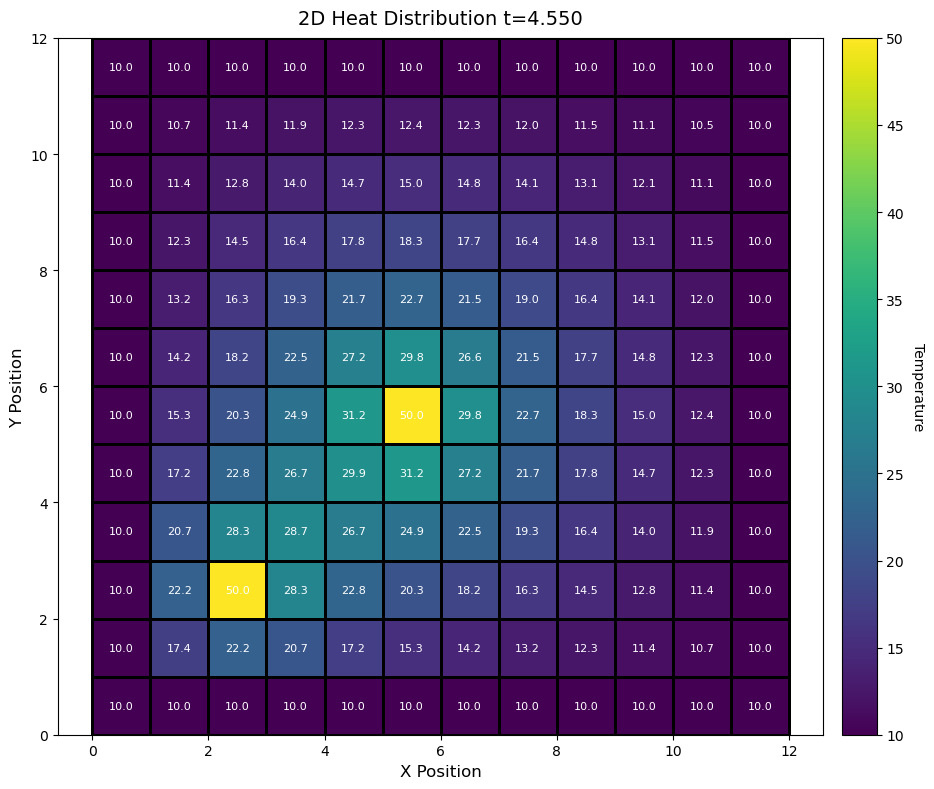

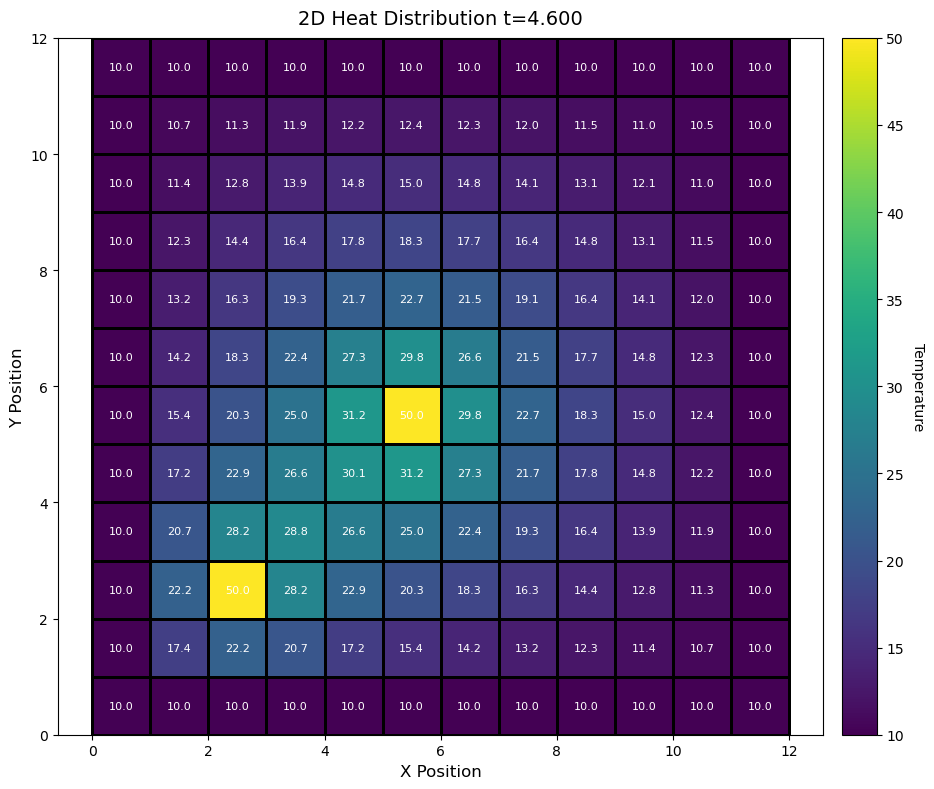

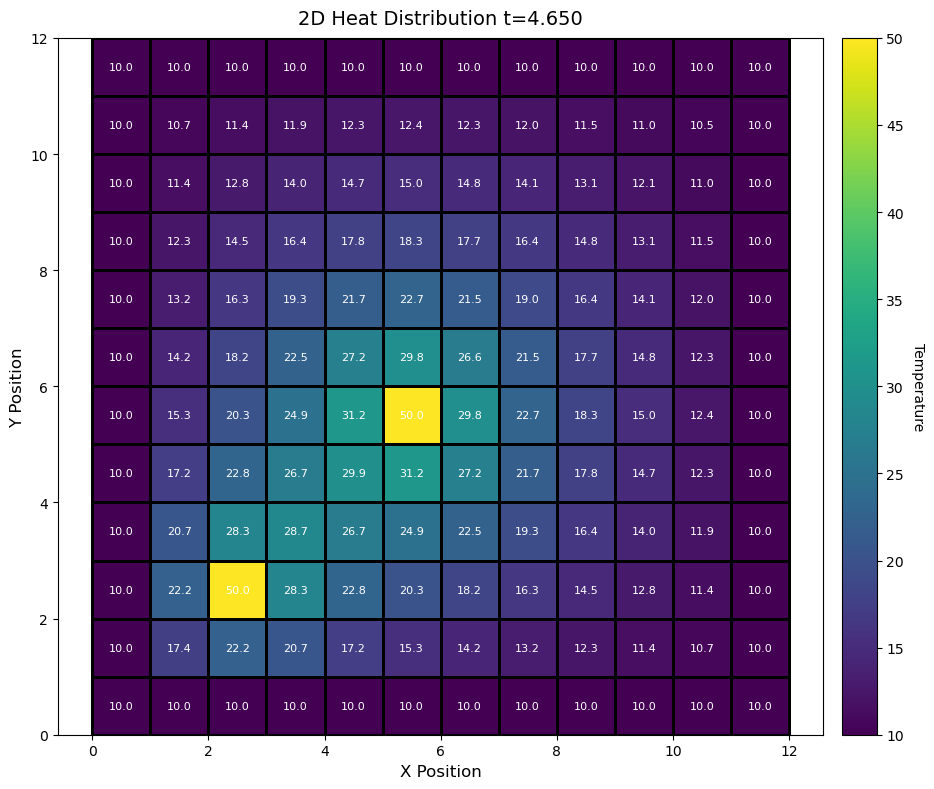

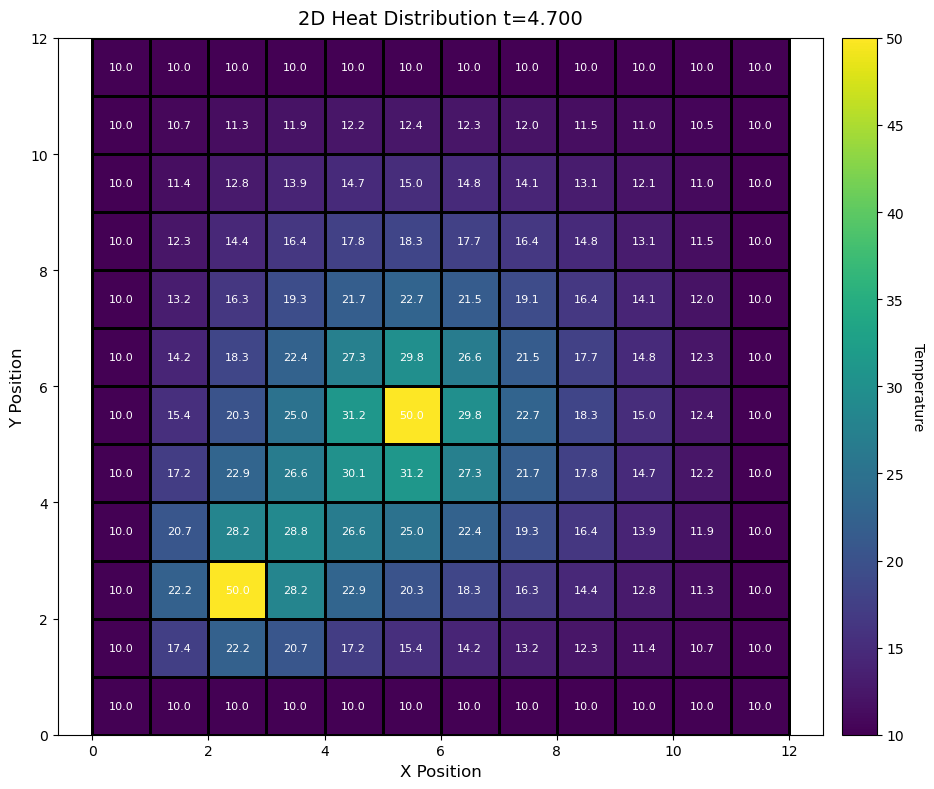

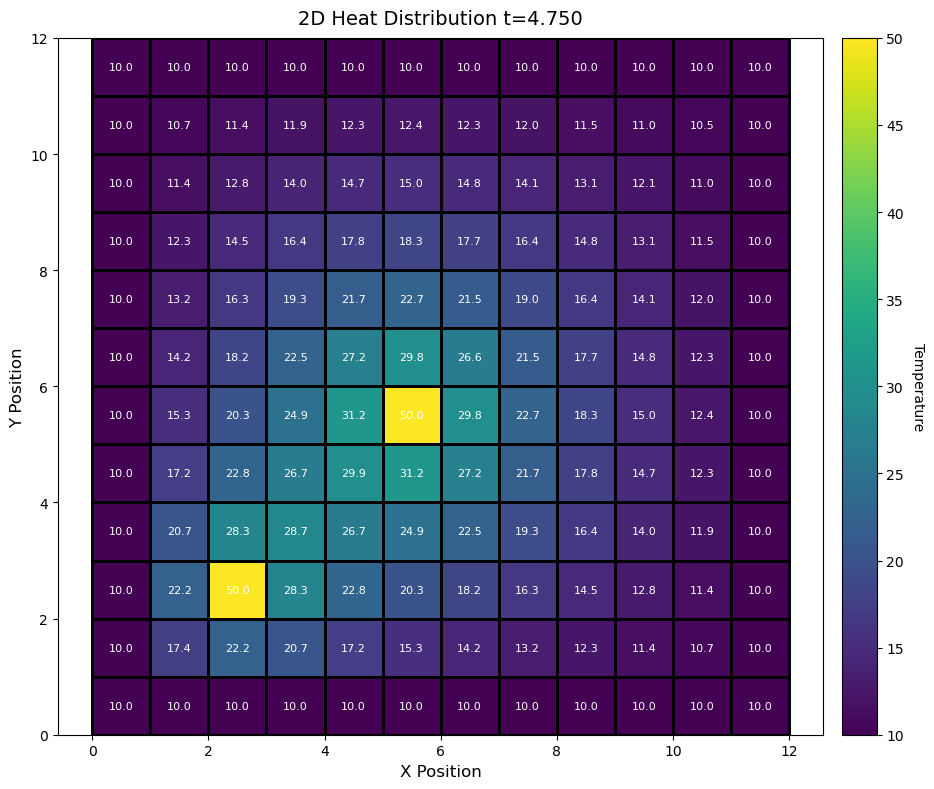

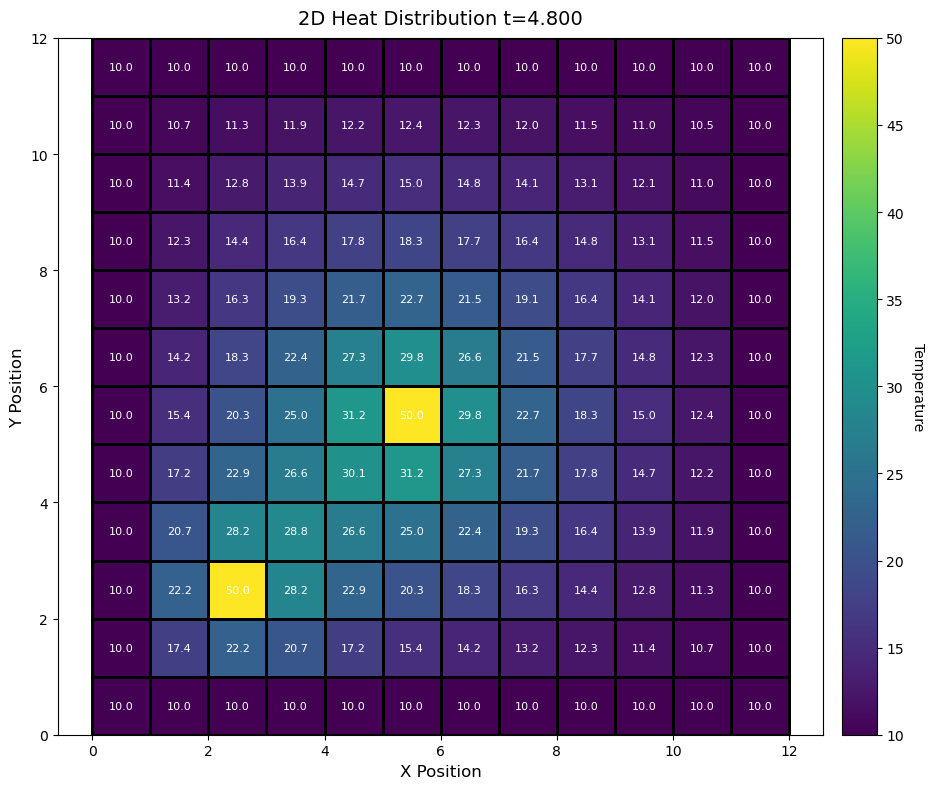

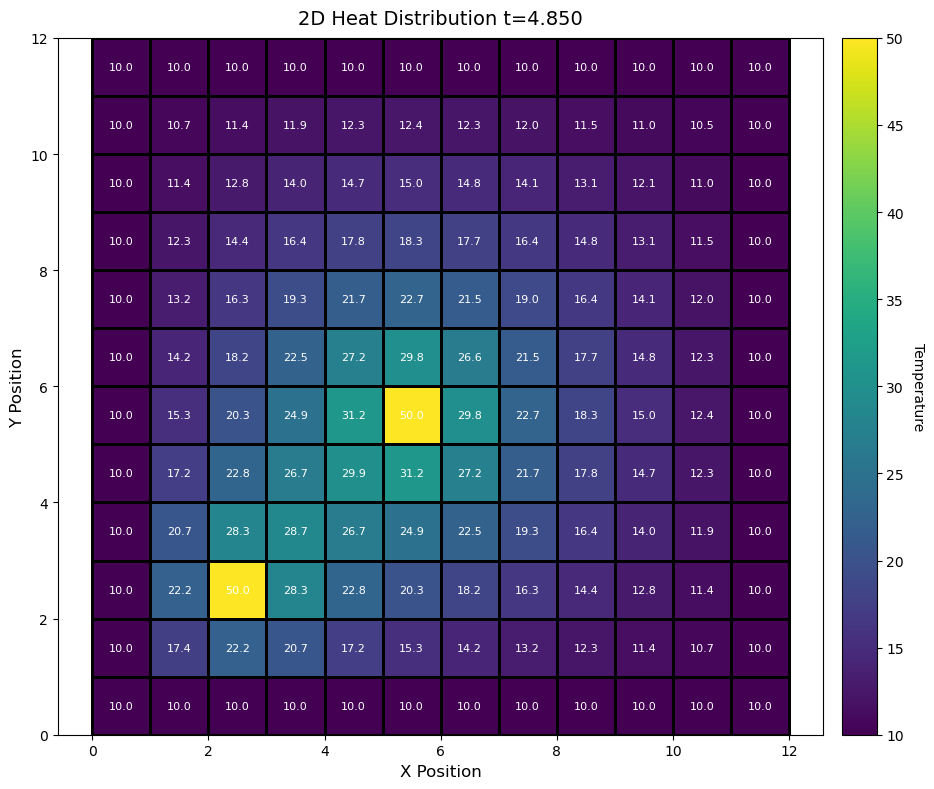

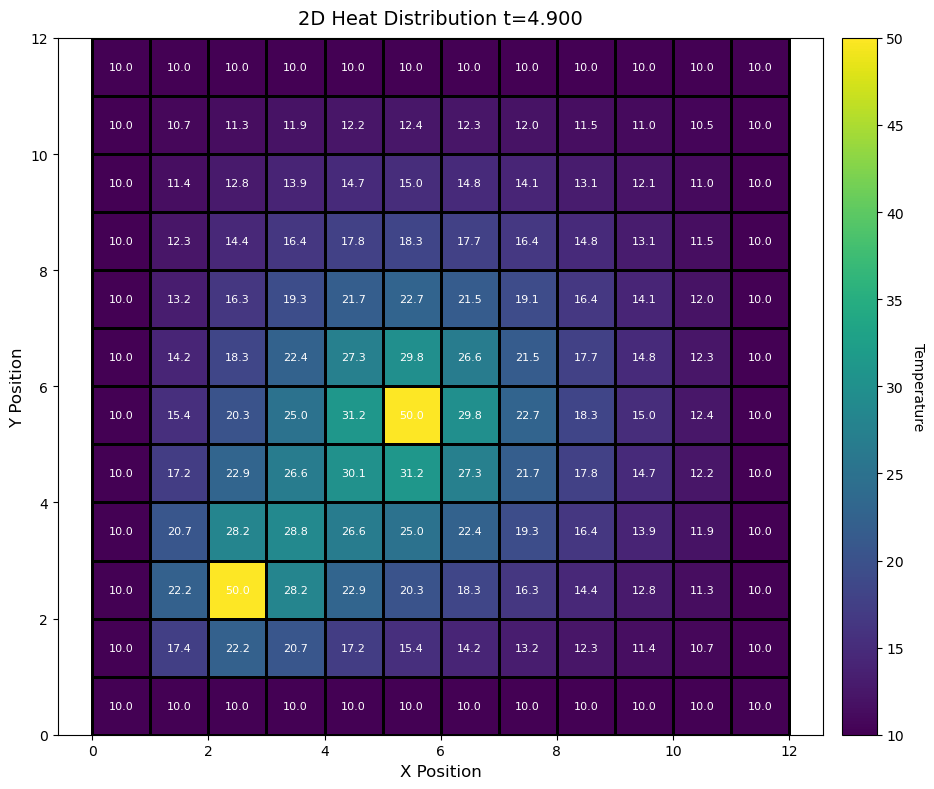

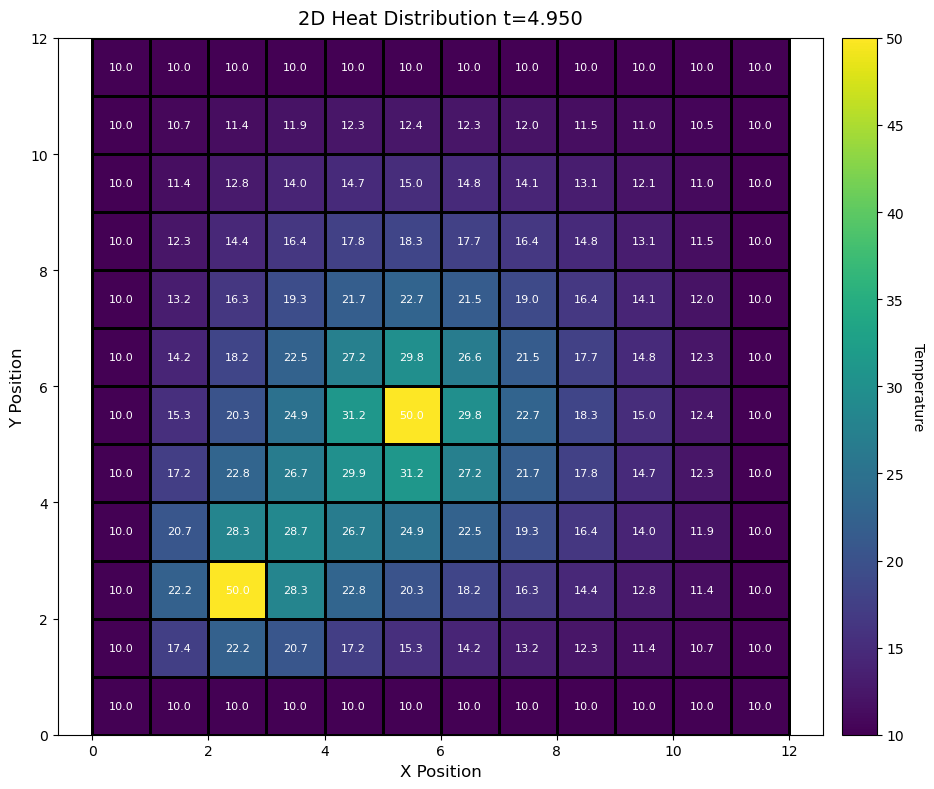

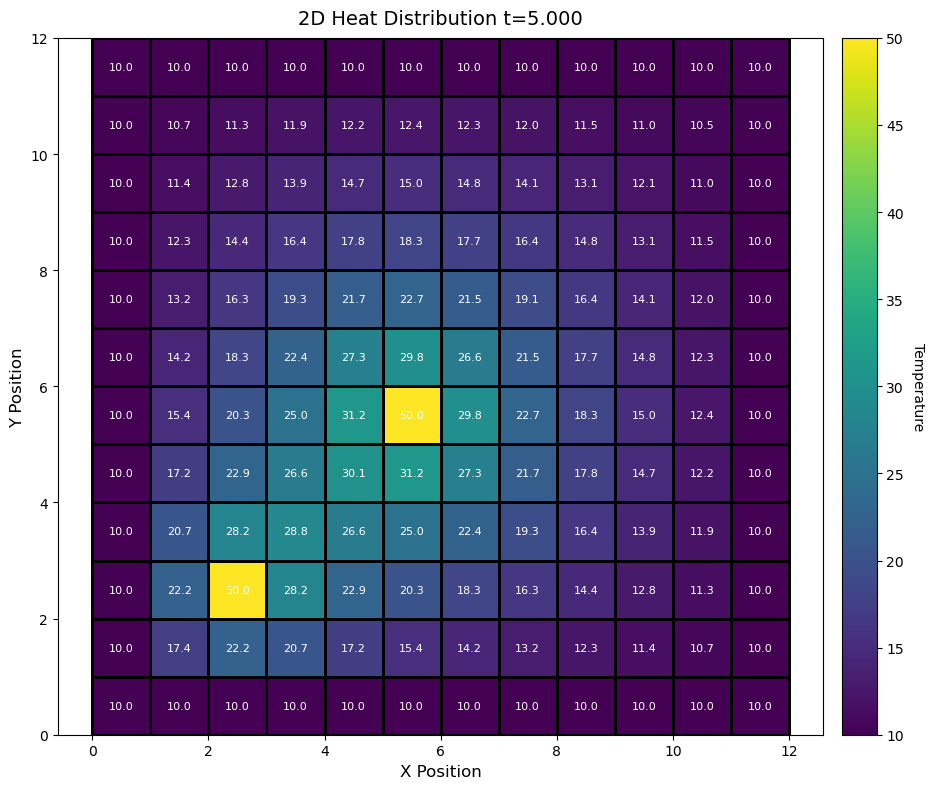

In [11]:
state = State(30.0, 10.0)
sources = [Source(50, 5, 5, 1), Source(50, 2, 2, 1)]
model = Model(state, kappa=0.1, sources=sources)
model.run(0.05, 101, 'test', 1)